# 4: Neural Machine Translation

Data format and input
=====================

First, we will look at the data which we would use to train the neural
translation model. Specifically we will look at the famous WMT15
(Workshop for Statistical Machine Translation 2015) benchmark for NMT.
The data is located at `/opt/data/wmt15`.

There are several training files with the prefix "`train`", namely
`train.tok.clean.bpe.32000.{en,de}` and `train.tok.clean.{en,de}`. They
are pair-wise files of sentence-aligned English and German parallel
data.  
As we have covered in the preprocessing exercises, the "`bpe`" infix in
the file names indicates that those files have BPE applied to them for
training.

1)  Lets check the vocabulary size for each language, with and without
    BPE. As in a previous exercise, to calculate the vocabulary size you
    may use

```bash
$ cat {inputfile} | tr ' ' '\n' | sort | uniq -c | wc -l
```

What are vocabulary sizes of

a)  `train.tok.clean.en`  
b)  `train.tok.clean.de`  
c)  `train.tok.clean.bpe.32000.en`  
d)  `train.tok.clean.bpe.32000.de`  

In [1]:
for f in /opt/data/wmt15/train.*
do
    echo -n "$(basename $f): "
    cat $f | tr ' ' '\n' | sort | uniq -c | wc -l
done

train.tok.clean.bpe.32000.de: 35710
train.tok.clean.bpe.32000.en: 35028
train.tok.clean.de: 1976215
train.tok.clean.en: 970515


|Data Set| Vocab Size|
|--------|-----------|
|train.tok.clean.de| 1976215 |
|train.tok.clean.en| 970515  |
|train.tok.clean.bpe.32000.de| 35710|
|train.tok.clean.bpe.32000.en| 35028|

2)  Did you notice the difference in vocabulary size between the data
    with and without BPE? What would be the consequences of using either
    the one or the other corpus for our neural machine translation?

a)  Which model will have the larger vocabulary size? What are the
    problems of a large vocabulary size?

b)  Did you notice that the English and German vocabularies are
    quite similar in size when using BPE? Could you guess as to why
    that is the case?

In [2]:
cat /opt/data/wmt15/train.tok.clean.bpe.32000.{en,de} |
    tr ' ' '\n' | sort | uniq -c | wc -l

36988


In [3]:
cat /opt/data/wmt15/train.tok.clean.{en,de} |
    tr ' ' '\n' | sort | uniq -c | wc -l

2431865


| Data Set | Vocab Size | % Size of Total |
|----------|------------|-----|
|train.tok.clean.de| 1976215 |   |
|train.tok.clean.en| 970515  |   |
|Both non-BPE data sets combined | 2431865 | 82.5% |
|train.tok.clean.bpe.32000.de| 35710|   |
|train.tok.clean.bpe.32000.en| 35028|   |
|Both BPE data sets combined | 36988| 52.3% |

Recurrent Translation Model
===========================

In `/opt/data/nmt_models/lstm/` you can find the training log which
stores the information during training (even when I actually trained
it). Lets look at the log file, and you will see a description of the
model in the first part.

Can you try to estimate the number of parameters in the whole model? In
order to simplify the tasks, lets estimate the parameters for the
individual components of each layer.  
*Hints:* The embedding layer is basically a matrix with $N$ rows and $D$
columns with $N$ being the size of vocabulary, and $D$ being the
dimension of the word vectors. Each layer of the LSTM has 2 linear
transformation matrices inside, each of them has $D_{in}*4*D_{out}$
parameters with $4*D_{out}$ biases (4 because of the gates). In case of
a bidirectional LSTM the number of parameters will double.  
*Note:* you don't have to give an exact estimate, we just want to give
you a sense of how big the model is.

-   Encoder

    -   Embeddings: $3307 \cdot 500 = 1653500$
    
    -   LSTM: $2 \cdot (2 \cdot (4 \cdot 500 \cdot 250)) + 2 \cdot (4 \cdot 500) = 2004000$


-   Decoder

    -   Embeddings: $34485 \cdot 500 = 17242500$

    -   LSTM: $4 \cdot ((500 + 500) \cdot 500) + 4 \cdot 500^2 + 2 \cdot (4 \cdot 500) = 3004000$

    -   Attention: $2 \cdot 500^2 + 1000 \cdot 500 + 3 \cdot 500 = 1000500$

    -   generator (the output layer with softmax): $34485 \cdot 500 + 34485 = 17276985$

Translating from the model
==========================

Now we can try to generate translations using this model. You can find
the trained model in the following directory and you should link it to
your current directory.  
`/opt/data/nmt_models/lstm/`

To translate an input file (e. g.
`/opt/data/wmt15/newstest2013.tok.bpe.32000.en`) use

```bash
$ onmt_translate \
    -gpu 0 \
    -model <your-model> \
    -src <your-input-file> \
    -output <your-output-file> \
    -beam_size 1 \
    -batch_size 256 \
    -verbose
```

After decoding we want to calculate the translation BLEU score, for
which we use the human reference translation:

```bash
$ sed s/@@ //g | multi-bleu.perl <reference-file>
```

This command first removes the BPE annotations and then calls the script
`multi-bleu.perl` script to calculate the BLEU score.

Depending on your test set, your reference file will change accordingly.
For the `newstest201x` test set, the corresponding reference file would
be `wmt15/newstest201x.tok.de`

In [5]:
onmt_translate \
    -gpu 0 \
    -model /opt/data/nmt_models/lstm/model.lstm.step.500000.pt \
    -src /opt/data/wmt15/newstest2013.tok.bpe.32000.en \
    -output /tmp/newstest2013.hyp.de \
    -beam_size 1 \
    -batch_size 256 \
    -verbose

[2021-07-30 14:12:13,099 INFO] Translating shard 0.

SENT 1: ['A', 'Republic@@', 'an', 'strategy', 'to', 'counter', 'the', 're-@@', 'election', 'of', 'Obama']
PRED 1: Eine repub@@ li@@ kanische Strategie zur Bekämpfung der Wieder@@ wahl Obama
PRED SCORE: -0.4716

SENT 2: ['Republic@@', 'an', 'leaders', 'justified', 'their', 'policy', 'by', 'the', 'need', 'to', 'combat', 'electoral', 'fraud', '.']
PRED 2: Die repub@@ li@@ kanischen Führer begrün@@ deten ihre Politik durch die Notwendigkeit , Wahl@@ betrug zu bekämpfen .
PRED SCORE: -0.0005

SENT 3: ['However', ',', 'the', 'Brenn@@', 'an', 'Centre', 'considers', 'this', 'a', 'my@@', 'th', ',', 'stating', 'that', 'electoral', 'fraud', 'is', 'rar@@', 'er', 'in', 'the', 'United', 'States', 'than', 'the', 'number', 'of', 'people', 'killed', 'by', 'ligh@@', 'tn@@', 'ing', '.']
PRED 3: Das Brenn@@ an Centre betrachtet diese My@@ then jedoch als My@@ thos , indem man sagt , dass Wahl@@ betrug in den Vereinigten Staaten sel@@ tener ist als die Z

PRED SCORE: -0.0006

SENT 24: ['And', 'that', '&apos;s', 'not', 'all', '.']
PRED 24: Und das ist nicht alles .
PRED SCORE: -0.0003

SENT 25: ['Stu@@', 'dents', ',', 'voters', 'considered', 'to', 'be', 'voting', 'more', 'for', 'Democratic', 'candidates', ',', 'are', 'not', 'allowed', 'in', 'several', 'States', 'to', 'use', 'the', 'photo', 'ID', 'card', 'issued', 'by', 'their', 'institution', '.']
PRED 25: Die Studenten , die als mehr für demokratische Kandidaten gelten , sind in mehreren Staaten nicht erlaubt , die von ihrer Institution aus@@ gestellte Karte von der Karte zu verwenden .
PRED SCORE: -0.0008

SENT 26: ['On', 'the', 'other', 'hand', ',', 'these', 'same', 'States', 'allow', 'fishing', 'or', 'hunting', 'club', 'members', ',', 'who', 'vote', 'more', 'Republic@@', 'an', ',', 'to', 'use', 'the', 'cards', 'issued', 'by', 'these', 'clubs', 'when', 'they', 'vote', '.']
PRED 26: Andererseits erlauben diese Staaten die Fischerei oder die Jag@@ d@@ mitglieder , die mehr Republi@@ kan

PRED 49: Ein Bericht von Frau Brenn@@ an im Brenn@@ an Bericht zeigt , dass die Staaten , die diese Gesetze angenommen haben , 17@@ 1 der 2@@ 70 Stimmen vertreten , die im Wahl@@ kampf erforderlich sind , um den Ratsvorsitz zu gewinnen .
PRED SCORE: -0.0003

SENT 50: ['It', 'is', 'too', 'early', 'to', 'say', 'with', 'certainty', 'that', 'these', 'legislative', 'changes', 'in', 'the', 'electoral', 'system', 'will', 'have', 'significant', 'imp@@', 'acts', 'on', 'the', 'outcome', 'of', 'the', '2012', 'presidential', 'elections', '.']
PRED 50: Es ist zu früh , mit Sicherheit zu sagen , dass diese Gesetzes@@ änderungen im Wahl@@ system erhebliche Auswirkungen auf das Ergebnis der Präsidentschafts@@ wahlen 2012 haben werden .
PRED SCORE: -0.0003

SENT 51: ['But', 'one', 'thing', 'is', 'certain', ':', 'these', 'new', 'provisions', 'will', 'have', 'a', 'negative', 'impact', 'on', 'the', 'tur@@', 'n-@@', 'out', '.']
PRED 51: Eines ist jedoch sicher : Diese neuen Bestimmungen werden negative Aus

PRED 72: Sie können das Dokument herunterladen ( in Englisch zum Zeitpunkt der Zeit , eine &#91; Französ@@ ische &#93; Übersetzung wird in Kürze ) an dieser Adresse verfügbar sein : http : / / ca@@ .@@ mo@@ v@@ ember@@ .com / fr / m@@ ens@@ -@@ health / pro@@ stat@@ -@@ can@@ cer@@ -@@ Scre@@ ening
PRED SCORE: -1.0341

SENT 73: ['Pre@@', 'v@@', 'enting', 'the', 'disease']
PRED 73: Prävention der Krankheit
PRED SCORE: -0.0072

SENT 74: ['Unfortunately', ',', 'there', 'is', 'no', 'mi@@', 'racle', 'recip@@', 'e', 'for', 'preventing', 'cancer', '.']
PRED 74: Leider gibt es kein Wunder@@ re@@ zep@@ te für die Prävention von Krebs .
PRED SCORE: -0.0020

SENT 75: ['Despite', 'the', 'progress', 'in', 'research', ',', 'the', 'adoption', 'of', 'healthy', 'living', 'hab@@', 'its', 'remains', 'the', 'best', 'way', 'to', 'reduce', 'the', 'risk', 'of', 'suffering', 'from', 'it', '.']
PRED 75: Trotz der Fortschritte in der Forschung bleibt die Annahme ges@@ under Lebens@@ ge@@ wohnheiten der beste We

PRED 102: Darüber hinaus betont Herr Beau@@ li@@ eu die Bedeutung der Diskussion über Ihre Anliegen und Familien@@ geschichte mit Ihrem Arzt .
PRED SCORE: -0.0005

SENT 103: ['&quot;', 'Taking', 'a', 'screening', 'test', 'doesn', '&apos;t', 'give', 'you', 'cancer', '.', '&quot;']
PRED 103: &quot; Bei der Prüfung eines Screen@@ ing-@@ Tests gibt es keinen Krebs . &quot;
PRED SCORE: -0.0006

SENT 104: ['The', 'H@@', 'ig@@', 'gs', 'bo@@', 'son', 'revealed']
PRED 104: Der H@@ ig@@ gs Bo@@ son offen@@ bar@@ te
PRED SCORE: -1.3285

SENT 105: ['The', 'announcement', 'of', 'the', 'prob@@', 'able', 'discovery', 'of', 'the', 'H@@', 'ig@@', 'gs', 'bo@@', 'son', 'created', 'quite', 'a', 'sti@@', 'r', 'last', 'summer', ',', 'and', 'with', 'good', 'reason', '.']
PRED 105: Die Ankündigung der wahrschein@@ lichen Entdeckung des H@@ ig@@ gs Bo@@ ards hat im letzten Sommer einen großen Auf@@ stand geschaffen und mit gutem Grund .
PRED SCORE: -0.0011

SENT 106: ['Indeed', ',', 'it', 'is', 'believed', 'th

PRED 120: Wenn Sie diesen Artikel lesen können , ist es dank eines außergewöhnlich ban@@ alen Bo@@ ses , das Foto oder die &quot; Licht@@ par@@ tik@@ el &quot; , die der &quot; Ges@@ and@@ te &quot; der elektro@@ magne@@ tischen Kraft ist .
PRED SCORE: -0.0015

SENT 121: ['When', ',', 'in', 'fact', ',', 'a', 'partic@@', 'le', 'having', 'an', 'electric', 'charge', 'acceler@@', 'ates', 'or', 'changes', 'direction', ',', 'this', '&quot;', 'distur@@', 'bs', '&quot;', 'the', 'electro@@', 'magnetic', 'field', 'in', 'this', 'specific', 'place', ',', 'rather', 'like', 'a', 'p@@', 'eb@@', 'ble', 'thrown', 'in', 'a', 'p@@', 'ond', '.']
PRED 121: Wenn ein Par@@ tik@@ el eine elektrische Lad@@ ung beschleunigt oder ändert , so wird das elektro@@ magne@@ tische Feld in diesem speziellen Ort , wie ein P@@ eb@@ el ge@@ worfen , in einem Tei@@ ch .
PRED SCORE: -0.0027

SENT 122: ['This', '&quot;', 'distur@@', 'b@@', 'ance', '&quot;', 'produces', 'an', 'electro@@', 'magnetic', 'wave', '(', 'of', 'light

PRED 138: Denken Sie daran : In den frühen 6@@ 0er Jahren haben die Pi@@ oni@@ ere des Las@@ ers bei B@@ ell Labor@@ at@@ orien die Revolution nicht verd@@ äch@@ tigt , die durch ihre Arbeit ausgelöst würde .
PRED SCORE: -0.0010

SENT 139: ['They', 'had', 'an', 'in@@', 'kl@@', 'ing', 'of', 'the', 'scientific', 'applications', ',', 'but', 'nothing', 'as', 'to', 'the', 'rest', '.']
PRED 139: Sie hatten eine Auf@@ arbeitung der wissenschaftlichen Anwendungen , aber nichts , was den Rest betrifft .
PRED SCORE: -0.0007

SENT 140: ['In', 'fact', ',', 'the', 'late', 'Will@@', 'ard', 'Bo@@', 'yle', '-', 'a', 'physi@@', 'c@@', 'ist', 'who', 'worked', 'at', 'B@@', 'ell', 'Lab@@', 's', ',', 'where', 'the', 'laser', 'was', 'invented', 'in', '1960', ',', 'and', 'who', 'himself', 'developed', 'the', 'first', 'continuous', 'laser', '(', 'the', 'first', 'were', 'pul@@', 'sed', ')', 'in', '1962', '-', 'told', 'us', 'that', 'initially', 'the', 'laser', 'was', 'rather', 'seen', 'as', 'a', '&quot;', 'l@@'

PRED SCORE: -0.0024

SENT 162: ['Reg@@', 'res@@', 'sing', 'to', 'the', 'stage', 'of', 'a', 'child', ',', 'for', 'some', 'people', ',', 'is', 'an', 'unacceptable', 'hum@@', 'ili@@', 'ation', '.']
PRED 162: Die Reg@@ im@@ ation der Kinder@@ stu@@ be ist für einige Menschen eine un@@ annehm@@ bare Dem@@ ü@@ tigung .
PRED SCORE: -0.0004

SENT 163: ['&quot;', 'It', 'depends', 'on', 'the', 'person', '&apos;s', 'ability', '&quot;', 'to', 'accept', 'the', 'reg@@', 'ression', ',', 'he', 'says', '.']
PRED 163: &quot; Es hängt von der Fähigkeit der Person &quot; zu akzeptieren den Reg@@ ression , sagt er .
PRED SCORE: -0.0028

SENT 164: ['Because', ',', 'in', 'the', 'opinion', 'of', 'a', 'number', 'of', 'people', 'working', 'in', 'p@@', 'alli@@', 'ative', 'care', ',', 'great', 'moments', 'occur', 'at', 'the', 'very', 'heart', 'of', 'such', 'reg@@', 'ression', '.']
PRED 164: Denn in der Meinung einer Reihe von Menschen , die in der p@@ alli@@ ativen Pflege arbeiten , treten große Momente im Mittel

PRED 188: &quot; Seit sechs Monaten gab es immer drei bis fünf Betten , die von Kre@@ bsp@@ ati@@ enten weniger als 45 Jahre alt sind &quot; sagt ein besorgt Dr. Christi@@ ane Mar@@ tel .
PRED SCORE: -0.0017

SENT 189: ['53', '%', 'of', 'patients', 'admitted', 'to', 'the', 'Vic@@', 'tor@@', '-@@', 'G@@', 'ad@@', 'bo@@', 'is', 'home', 'come', 'from', 'their', 'homes', ',', '47', '%', 'from', 'hospital', '.']
PRED 189: 53 % der Patienten , die in das Vic@@ tor@@ -@@ G@@ ad@@ bo@@ is Haus aufgenommen wurden , kommen aus ihren Häusern , 47 % aus dem Krankenhaus .
PRED SCORE: -0.0010

SENT 190: ['L@@', 'ack', 'of', 'access', 'to', 'p@@', 'alli@@', 'ative', 'care']
PRED 190: Zugang zu einer p@@ alli@@ ativen Versorgung
PRED SCORE: -0.4880

SENT 191: ['It', 'is', 'said', 'that', '77', '%', 'of', 'Canadi@@', 'ans', 'simply', 'have', 'no', 'access', 'to', 'p@@', 'alli@@', 'ative', 'care', ',', 'which', 'is', 'care', 'designed', 'to', 'ease', 'the', 'pain', 'when', 'a', 'patient', 'has', 'reache

PRED SCORE: -0.0006

SENT 207: ['We', 'can', 'no', 'longer', 'pre@@', 'tend', 'not', 'to', 'understand', 'this', 'part', 'of', 'their', 'suffering', '.']
PRED 207: Wir können nicht länger dazu nei@@ gen , diesen Teil ihres Lei@@ dens nicht zu verstehen .
PRED SCORE: -0.0006

SENT 208: ['Incre@@', 'as@@', 'ingly', ',', 'an', 'un@@', 'rel@@', 'iev@@', 'ed', 'patient', 'will', 'have', 'the', 'option', 'of', 'having', 'such', 'p@@', 'alli@@', 'ative', 'sed@@', 'ation', '.']
PRED 208: Immer mehr wird ein uner@@ mü@@ dlicher Pati@@ ent die Möglichkeit haben , eine solche p@@ alli@@ ative S@@ ession zu haben .
PRED SCORE: -0.0011

SENT 209: ['Pati@@', 'ents', 'who', 'are', 'not', 'rel@@', 'iev@@', 'ed', 'always', 'say', 'the', 'same', 'thing', ':', '&quot;', 'I', 'want', 'to', 'die', '.', '&quot;']
PRED 209: Patienten , die nicht ent@@ last@@ et werden , sagen immer dasselbe : &quot; Ich möchte sterben . &quot;
PRED SCORE: -0.0221

SENT 210: ['But', 'this', 'does', 'not', 'necessarily', 'mean

PRED 224: Als nächstes auf der Liste ist Gil@@ les V@@ ail@@ lan@@ court , der gerade aus seinem Amt als Bürger@@ meister von Lav@@ al , dritt@@ größte Stadt in Qu@@ eb@@ ec zurück@@ getreten ist .
PRED SCORE: -0.0024

SENT 225: ['He', 'is', 'susp@@', 'ected', 'of', 'po@@', 'ck@@', 'eting', 'repeated', 'bri@@', 'bes', 'in', 'exchange', 'for', 'public', 'contracts', '.']
PRED 225: Er wird vermut@@ et , wiederhol@@ te Best@@ ech@@ ungen im Austausch für öffentliche Aufträge zu ver@@ werfen .
PRED SCORE: -0.0017

SENT 226: ['Others', 'formally', 'accused', 'are', 'Montreal', 'highway', 'engineers', 'and', 'Italian', 'entrepreneurs', ',', 'including', 'Tony', 'Ac@@', 'cur@@', 'so', 'and', 'Lin@@', 'o', 'Z@@', 'ambi@@', 'to', '.']
PRED 226: Andere An@@ gekl@@ agte sind die Mon@@ tag@@ el@@ in@@ genie@@ ure von Montreal und italienischen Unternehm@@ ern , darunter Tony Ac@@ cur@@ so und Lin@@ o Z@@ ambi@@ to .
PRED SCORE: -0.0019

SENT 227: ['The', 'latter', 'caused', 'a', 'sens@@', 'ation',

PRED 242: Die W@@ unde wird ger@@ einigt , aber Montreal würde seine eigene Untersuchungs@@ einheit mit fort@@ laufenden Überwachung benötigen , um die Rückkehr dieser frag@@ würdigen Praktiken zu vermeiden .
PRED SCORE: -0.0006

SENT 243: ['How', 'to', 'clean', 'house', '.']
PRED 243: Wie kann man das Haus sauber machen .
PRED SCORE: -0.0055

SENT 244: ['Proper@@', 'ly', '.']
PRED 244: Gut .
PRED SCORE: -0.0231

SENT 245: ['Jacques', 'Du@@', 'ch@@', 'es@@', 'ne@@', 'au', 'notes', 'for', 'his', 'part', 'that', '&quot;', 'officials', 'st@@', 'ole', 'hundreds', 'of', 'millions', 'of', 'dollars', ',', '&quot;', 'but', 'he', 'is', 'especially', 'concerned', 'about', 'the', 'role', 'of', '&quot;', 'elected', 'people', 'aware', 'of', 'the', 'scheme', ',', '&quot;', 'when', 'they', 'were', 'not', 'up', 'to', 'their', 'nec@@', 'ks', 'in', 'the', 'sc@@', 'am', '!']
PRED 245: Jacques Du@@ ch@@ es@@ ne@@ au No@@ tizen für seinen Teil , dass &quot; Beamte st@@ ol@@ per@@ ten Hunderte Millionen Dol

PRED 271: Heute hat er nicht gleich in Lig@@ ue 1 , und er ist eine der besten Trainer in Europa .
PRED SCORE: -0.0019

SENT 272: ['He', 'has', 'mass@@', 'es', 'of', 'experience', 'and', 'has', 'won', 'many', 'titles', 'with', 'top', 'clubs', '.']
PRED 272: Er hat eine Erfahrung und hat viele Titel mit Top-@@ Clubs gewonnen .
PRED SCORE: -0.0039

SENT 273: ['He', '&apos;s', 'worked', 'with', 'great', 'players', '.']
PRED 273: Er ist mit großen Spielern gearbeitet .
PRED SCORE: -0.0049

SENT 274: ['I', 'think', 'he', 'will', 'bring', 'more', 'titles', 'to', 'Paris', '.']
PRED 274: Ich denke , er wird mehr Titel nach Paris bringen .
PRED SCORE: -0.0016

SENT 275: ['In', 'January', ',', 'I', 'had', 'an', 'encouraging', 'discussion', 'with', 'him', '.']
PRED 275: Im Januar hatte ich eine ermuti@@ gende Diskussion mit ihm .
PRED SCORE: -0.0005

SENT 276: ['I', 'was', 'just', 'coming', 'back', 'from', 'a', 'series', 'of', 'in@@', 'jur@@', 'ies', '.']
PRED 276: Ich kam gerade aus einer Reihe 

PRED 311: Es braucht Zeit , um ein Team zu bauen .
PRED SCORE: -0.0021

SENT 312: ['The', 'Champ@@', 'ions', 'League', 'proved', 'we', 'could', 'hold', 'our', 'own', '.']
PRED 312: Die Champ@@ ions League hat sich gezeigt , dass wir uns selbst halten konnten .
PRED SCORE: -0.0036

SENT 313: ['Look', 'at', 'Manchester', 'City', 'who', ',', 'for', 'two', 'seasons', ',', 'have', 'failed', 'to', 'qualify', 'for', 'the', 'last', '16', ',', 'despite', 'also', 'having', 'spent', 'huge', 'amounts', '!']
PRED 313: Schauen Sie sich an Manchester City , die , für zwei Jahres@@ zeiten , nicht für die letzten 16 , obwohl auch riesige Sum@@ men !
PRED SCORE: -0.0026

SENT 314: ['Based', 'on', 'the', 'amounts', 'invested', ',', 'you', 'should', 'be', '15', 'points', 'ahead', 'at', 'the', 'winter', 'break', '!']
PRED 314: Auf der Grundlage der investi@@ erten Beträge sollten Sie 15 Punkte vor dem Winter Pause sein !
PRED SCORE: -0.0017

SENT 315: ['That', 'would', 'be', 'to', 'ignore', 'our', 'opponen

PRED 347: Jeder kämpf@@ te für alle .
PRED SCORE: -0.0013

SENT 348: ['Before', 'that', 'shock', 'in', 'Spain', ',', 'I', '&apos;d', 'never', 'experienced', 'such', 'a', 'match', 'in', 'my', 'career', '.']
PRED 348: Vor diesem Scho@@ ck in Spanien hatte ich nie ein solches Spiel in meiner Karriere .
PRED SCORE: -0.0021

SENT 349: ['With', 'Bit@@', 'coin', ',', 'pay', 'and', 'sell', 'without', 'banks']
PRED 349: Mit Bit@@ coin , zahlen und verkaufen ohne Banken
PRED SCORE: -0.6524

SENT 350: ['The', 'opposite', 'of', 'current', 'monetary', 'exchanges', ',', 'based', 'on', 'central', 'banks', ',', 'identified', 'transactions', 'and', 'processing', 'fees', 'among', 'the', 'parties', 'involved', '.']
PRED 350: Das Gegenteil des aktuellen Währungs@@ austau@@ sch@@ s , basierend auf Zentralbanken , identifiziert Transaktionen und Ver@@ arbeitungs@@ gebühren unter den beteiligten Parteien .
PRED SCORE: -0.0015

SENT 351: ['In', 'addition', ',', 'as', 'often', 'in', 'these', 'technologies', ',

PRED SCORE: -0.0030

SENT 369: ['The', 'key', 'step', 'is', 'entering', 'the', 'new', 'transaction', 'in', 'the', 'book', '.']
PRED 369: Der Schlüssel@@ schritt ist in die neue Trans@@ aktion im Buch .
PRED SCORE: -0.0047

SENT 370: ['It', 'passes', 'through', 'the', 'resolution', 'of', 'a', 'mathemati@@', 'cal', 'challenge', 'issued', 'to', 'the', 'computers', ',', 'and', 'the', 'winner', ',', 'a', 'kind', 'of', 'interim', 'central', 'ban@@', 'ker', ',', 'will', 'have', 'the', 'privilege', 'of', 'adding', 'this', 'extra', 'line', '.']
PRED 370: Es geht durch die Auflösung einer ma@@ them@@ atischen Herausforderung , die den Comp@@ utern ausgestellt wird , und der Gewinner , eine Art Inter@@ bank@@ en@@ ban@@ ker , wird das Privi@@ leg haben , diese zusätzliche Linie hinzuzufügen .
PRED SCORE: -0.0004

SENT 371: ['This', 'is', 'a', 'file', 'h@@', 'ash@@', 'ing', 'phase', ',', 'i.e.', 'the', 'transformation', 'of', 'a', 'large', 'file', 'into', 'a', 'shorter', 'and', 'unique', 'digital'

PRED SCORE: -0.0013

SENT 392: ['His', 'system', ',', 'Pay@@', 't@@', 'uni@@', 'a', ',', 'is', 'equivalent', 'to', 'a', 'credit', 'card', '(', 'in', 'real', 'money', ')', 'or', 'a', 'cont@@', 'ac@@', 'tless', 'payment', 'by', 'mobile', ',', 'but', 'it', 'uses', 'Bit@@', 'coin', 'to', 'vali@@', 'date', 'transactions', ',', 'which', 'are', 'thus', 'cheaper', '.']
PRED 392: Sein System , Pay@@ t@@ uni@@ a , entspricht einer Kreditkarte ( in realen Geld ) oder eine kontak@@ t@@ lose Zahlung per Handy , aber es verwendet Bit@@ coin , um Transaktionen zu vali@@ dieren , die so billiger sind .
PRED SCORE: -0.0002

SENT 393: ['Also', 'the', 'user', 'manages', 'his', 'identity', 'and', 'can', 'therefore', 'be', 'anonymous', '.']
PRED 393: Auch der Benutzer verwaltet seine Identität und kann daher an@@ onym sein .
PRED SCORE: -0.0007

SENT 394: ['The', 'system', 'is', 'easy', 'to', 'implement', 'by', 'merchan@@', 'ts', ',', 'who', 'do', 'not', 'need', 'to', 'install', 'new', 'terminals', 'or', '

PRED 414: Ihre Übernahme des Landes war dann als eine Art Befreiung empf@@ unden worden , eine Rückkehr zur Sicherheit .
PRED SCORE: -0.0015

SENT 415: ['Afghan@@', 'is', 'paid', 'the', 'price', 'of', 'the', 'obs@@', 'cur@@', 'anti@@', 'sm', 'of', 'these', 'pe@@', 'as@@', 'ants', 'by', 'the', 'organisation', 'of', 'Al-@@', 'Q@@', 'a@@', 'eda', ',', 'but', 'their', 'situation', 'has', 'not', 'improved', 'today', '.']
PRED 415: Afghan@@ en hat den Preis für den Ob@@ des@@ cur@@ anti@@ smus dieser Bauern durch die Organisation der Al-@@ Q@@ ai@@ da bezahlt , aber ihre Situation hat sich heute nicht verbessert .
PRED SCORE: -0.0008

SENT 416: ['For@@', 'mer', 'Mu@@', 'ja@@', 'hi@@', 'din', ',', 'the', 'Afghan', 'Government', 'and', 'the', 'current', 'Taliban', 'are', 'alli@@', 'ed', 'in', 'the', 'desire', 'to', 'keep', 'women', 'in', 'an', 'inf@@', 'erior', 'position', '.']
PRED 416: E@@ hem@@ alige Mu@@ ja@@ hi@@ din , die afgh@@ anische Regierung und die gegenwärtigen Taliban sind in der

PRED 435: Alles wird impor@@ tiert , nichts produziert , außer Obst und Gemüse .
PRED SCORE: -0.0030

SENT 436: ['The', 'Pri@@', 'ority', 'is', 'left', 'to', 'private', 'initiative', '.']
PRED 436: Die Priorität bleibt der privaten Initiative überlassen .
PRED SCORE: -0.0009

SENT 437: ['In', 'a', 'country', 'ru@@', 'ined', 'by', 'thirty', 'years', 'of', 'war', ',', 'government', 'control', 'over', 'the', 'infrastructure', 'would', 'have', 'been', 'necessary', '.']
PRED 437: In einem Land , das dreißig Jahre Krieg ru@@ in@@ iert , wäre die Regierung der Regierung in der Lage gewesen , die Infrastruktur zu kontrollieren .
PRED SCORE: -0.0007

SENT 438: ['The', 'rum@@', 'our', 'was', 'spread', 'that', 'Afghanistan', 'had', 'huge', 'mineral', 'wealth', '.']
PRED 438: Der Gerü@@ cht wurde verbreitet , dass Afghanistan riesige Mineral@@ quellen hatte .
PRED SCORE: -0.0017

SENT 439: ['This', 'only', 'added', 'to', 'the', 'feeling', 'that', 'the', 'Wes@@', 'tern@@', 'ers', 'were', 'only', 't

PRED SCORE: -0.0006

SENT 454: ['Taking', 'everyone', 'by', 'surprise', ',', 'he', 'announced', 'on', 'Wednesday', 'that', 'the', 'Constitu@@', 'ent', 'Assembly', 'would', 'vote', 'on', 'its', 'final', 'text', 'the', 'following', 'day', '.']
PRED 454: Jeder überrascht , er kün@@ digte am Mittwoch an , dass die Verfassungs@@ versammlung am nächsten Tag über seinen endgültigen Text abstimmen würde .
PRED SCORE: -0.0008

SENT 455: ['Just', 'a', 'week', 'ago', ',', 'the', 'head', 'of', 'State', 'had', 'given', 'the', 'Assembly', 'two', 'more', 'months', 'to', 'finish', 'its', 'work', '.']
PRED 455: Vor nur einer Woche hatte der Staat@@ so@@ ber@@ haupt die Versammlung zwei Monate lang zur Beendigung ihrer Arbeit beigetragen .
PRED SCORE: -0.0010

SENT 456: ['For', 'two', 'years', 'Egypt', 'has', 'reli@@', 'ed', 'on', 'a', 'pro@@', 'visi@@', 'onal', 'text', ',', 'amended', 'several', 'times', 'and', 'this', 'has', 'weak@@', 'ened', 'institutional', 'stability', 'and', 'led', 'to', 'legal', 

PRED SCORE: -0.0097

SENT 475: ['The', 'Sal@@', 'af@@', 'ist', 'parties', ',', 'for', 'which', 'the', 'establishment', 'of', 'Islamic', 'law', 'is', 'a', 'major', 'claim', ',', 'were', 'hoping', 'to', 'replace', '&quot;', 'the', 'principles', '&quot;', 'by', '&quot;', 'the', 'rules', ',', '&quot;', 'which', 'would', 'have', 'allowed', 'stricter', 'application', '.']
PRED 475: Die Sal@@ af@@ ist Parteien , für die die Errichtung des islamischen Rechts eine wichtige Behauptung ist , hoff@@ ten , &quot; die Grundsätze &quot; durch &quot; die Regeln &quot; ersetzen zu wollen , was eine strengere Anwendung ermögli@@ chte .
PRED SCORE: -0.0006

SENT 476: ['For', 'the', 'Islam@@', 'ists', ',', 'the', 'fact', 'that', 'this', 'article', 'was', 'not', 'amended', 'is', 'a', 'guarantee', 'of', 'their', 'good@@', 'will', 'and', 'their', 'respect', 'for', 'the', 'other', 'elements', 'of', 'Egyptian', 'society', '.']
PRED 476: Für die Islam@@ isten ist die Tatsache , dass dieser Artikel nicht geänder

PRED SCORE: -0.0003

SENT 496: ['In', 'addition', ',', 'no', 'longer', 'does', 'any', 'of', 'the', 'articles', 'refer', 'to', 'the', 'protection', 'of', 'women', ',', 'highlights', 'Heb@@', 'a', 'Mor@@', 'ay@@', 'ef', ',', 'from', 'Human', 'Rights', 'Watch', '.']
PRED 496: Außerdem gibt es nicht mehr eine der Artikel , die den Schutz von Frauen betreffen , die Heb@@ a Mor@@ ay@@ ef , von Human Rights Watch .
PRED SCORE: -0.0016

SENT 497: ['In', 'her', 'opinion', ',', 'the', 'only', 'positive', 'point', 'is', 'the', 'prohi@@', 'bition', 'of', 'torture', 'in', 'article', '36', '.']
PRED 497: Der einzige positive Punkt ist der Ein@@ zug in die Folter in Artikel 36 .
PRED SCORE: -0.0017

SENT 498: ['The', 'word', 'was', 'not', 'included', 'in', 'the', 'previous', 'Constitution', '.']
PRED 498: Das Wort wurde in der vorherigen Verfassung nicht aufgenommen .
PRED SCORE: -0.0006

SENT 499: ['While', 'the', 'Egyptian', 'President', 'was', 'speaking', 'yesterday', 'evening', 'on', 'television'

PRED SCORE: -0.0018

SENT 521: ['In', 'the', 'north', 'of', 'the', 'country', ',', 'at', 'an', 'elev@@', 'ation', 'of', '16@@', '00-@@', '20@@', '40', 'm', ',', 'there', 'is', 'a', 'famous', 'ski', 'resort', 'called', 'Her@@', 'mon', ',', 'which', 'f@@', 'ills', 'up', 'with', 'tourists', 'in', 'winter', 'months', '.']
PRED 521: Im Norden des Landes , auf einer Höhen@@ höhe von 16@@ 00-@@ 20@@ 40 m , gibt es ein berühm@@ tes Ski@@ gebiet namens Her@@ mon , das mit Touristen im Winter .
PRED SCORE: -0.0160

SENT 522: ['A', 'shuttle', 'bus', 'brings', 'people', 'to', 'it', 'from', 'the', 'foot', 'of', 'the', 'mountain', '.']
PRED 522: Ein Shutt@@ le@@ bus bringt die Menschen vom Fuß des Ber@@ ges aus .
PRED SCORE: -0.0030

SENT 523: ['The', 'total', 'length', 'of', 'ski', 'pist@@', 'es', 'is', '45', 'km', '.']
PRED 523: Die Gesamt@@ länge der Ski@@ pi@@ sten beträgt 45 km .
PRED SCORE: -0.0032

SENT 524: ['According', 'to', 'an', 'ancient', 'legend', ',', 'pag@@', 'an', 'go@@', 'ds', 'use

PRED 548: Im übrigen ist es das un@@ gewöhnliche Meer in der Welt , das sich am niedrig@@ sten Punkt des Planeten befindet - 4@@ 17 m unter dem Meeres@@ spiegel .
PRED SCORE: -0.0014

SENT 549: ['Its', 'az@@', 'ure', 'water', 'is', 'sal@@', 'ine', 'and', 'easily', 'keeps', 'you', 'af@@', 'lo@@', 'at', ',', 'even', 'if', 'you', 'don', '&apos;t', 'know', 'how', 'to', 'swim', '.']
PRED 549: Das A@@ real ist Sal@@ ine und ist leicht zu halten , auch wenn Sie nicht wissen , wie man schwi@@ mmen kann .
PRED SCORE: -0.0009

SENT 550: ['The', 'surrounding', 'landscapes', 'are', 'sur@@', 'real', 'in', 'their', 'beauty', '.']
PRED 550: Die umliegenden Landschaften sind in ihrer Schönheit sur@@ real .
PRED SCORE: -0.0019

SENT 551: ['People', 'come', 'here', 'to', 'under@@', 'go', 'a', 'course', 'of', 'treatment', 'using', 'salt', 'water', '-', 'w@@', 'rap@@', 's', 'and', 'medicinal', 'mu@@', 'ds', ',', 'and', 'to', 'improve', 'their', 'health', 'if', 'they', 'have', 'der@@', 'mati@@', 'tis', ','

PRED 572: Viele Cafés , Restaurants und Hotels haben nur ko@@ sch@@ ere Lebensmittel , ohne Schwein@@ ef@@ leisch , Meeres@@ frü@@ chte , Fisch ohne Sk@@ ales oder Gerichte , die Milch mit Fleisch verbinden .
PRED SCORE: -0.0011

SENT 573: ['There', 'is', 'a', 'wide', 'selection', 'of', 'dishes', 'from', 'lam@@', 'b', 'and', 'beef', ',', 'sou@@', 'ps', 'and', 'des@@', 'ser@@', 'ts', 'co@@', 'oked', 'using', 'co@@', 'con@@', 'ut', 'milk', ',', 'traditional', 'Jewish', 'hum@@', 'mus', 'pa@@', 'ste', ',', 'various', 'sau@@', 'ces', ',', 'fal@@', 'af@@', 'el', '(', 'balls', 'made', 'of', 'ground', 'ch@@', 'ick@@', 'pe@@', 'as', ')', ',', 'fruits', 'and', 'vegetables', '.']
PRED 573: Es gibt eine breite Auswahl an Gerichten aus L@@ amm@@ fleisch und Rindfleisch , Su@@ ppen und Des@@ ser@@ ts mit Kok@@ os@@ mil@@ ch , tradition@@ eller jü@@ discher Hum@@ mu@@ st@@ ein@@ pa@@ ste , verschiedenen S@@ auc@@ en , Fal@@ af@@ el ( Ku@@ geln aus Boden@@ sch@@ ick@@ ern ) , Obst und Gemüse .
PRED SC

PRED 597: Menschen , die vor dem Fall der U@@ d@@ SS@@ R im Jahre 1991 Bildungs@@ zerti@@ fik@@ ate und Diplom@@ aten erhielten , sind auch im Gesetz ausgenommen .
PRED SCORE: -0.0013

SENT 598: ['Pur@@', 'pose', ',', 'do@@', 'omed', 'fate', ',', 'and', 'the', 'protection', 'of', 'rights']
PRED 598: Zw@@ ang@@ lich , zum Scheitern verurteilt und der Schutz der Rechte
PRED SCORE: -0.6397

SENT 599: ['Seven', 'testing', 'points', 'will', 'be', 'operating', 'under', 'the', 'au@@', 'sp@@', 'ices', 'of', 'the', 'P@@', 'ush@@', 'kin', 'Institute', 'of', 'Russian', 'Language', ',', 'Pe@@', 'op@@', 'les', '&apos;', 'Fri@@', 'end@@', 'ship', 'University', 'of', 'Russia', ',', 'Moscow', 'State', 'University', '(', 'M@@', 'G@@', 'U', ')', ',', 'St.', 'Petersburg', 'State', 'University', '(', 'SP@@', 'b@@', 'G@@', 'U', ')', ',', 'and', 'other', 'Russian', 'education', 'institutions', '.']
PRED 599: Si@@ eben Prüf@@ punkte werden unter der Schir@@ m@@ herrschaft des P@@ ush@@ kin Institute of Russi

PRED 616: Nach dem Erreichen der Jugendlichen gehen diese Kinder in erster Linie zu Arbeit .
PRED SCORE: -0.0015

SENT 617: ['It', 'is', 'hard', ',', 'if', 'language', 'knowledge', 'is', 'bad', ',', 'they', 'admit', '.']
PRED 617: Es ist schwierig , wenn das Sprach@@ wissen schlecht ist , sie zugeben .
PRED SCORE: -0.0008

SENT 618: ['&quot;', 'You', 'feel', 'hum@@', 'ili@@', 'ated', 'and', 'inf@@', 'erior', '.', '&quot;']
PRED 618: &quot; Sie fühlen sich ge@@ de@@ mü@@ tigt und unter@@ min@@ iert . &quot;
PRED SCORE: -0.0013

SENT 619: ['But', 'human', 'rights', 'activists', 'note', 'one', 'important', 'point', 'about', 'the', 'law', 'on', 'language', '.']
PRED 619: Aber Menschenrechts@@ aktivi@@ sten nehmen einen wichtigen Punkt zum Spra@@ chen@@ gesetz zur Kenntnis .
PRED SCORE: -0.0004

SENT 620: ['Test@@', 'ing', 'will', 'be', 'conducted', 'only', 'for', 'those', 'migrants', 'who', 'have', 'legal', 'status', '.']
PRED 620: Die Tests werden nur für die Migranten durchgeführt , die 

PRED 642: Dies ist die Reaktion der Behörden auf die jüngsten Vor@@ fälle : CL@@ IC@@ K Sch@@ üsse an Hoch@@ zeiten , wo es keine Opfer gab , und das Mass@@ aker von Moskau An@@ walt D@@ mit@@ ry Vin@@ ogra@@ do@@ v , was zu einem der sieben Menschen in CL@@ IC@@ K .
PRED SCORE: -0.0030

SENT 643: ['Po@@', 'lic@@', 'emen', 'want', 'to', 'prohi@@', 'bit', 'the', 'carrying', 'of', 'weapons', 'in', 'public', 'places', 'and', 'raise', 'the', 'legal', 'age', 'of', 'weapons', 'licensing', 'from', '18', 'to', '21', '.']
PRED 643: Poli@@ zi@@ sten wollen die Waffen@@ lieferungen an öffentlichen Stellen verbieten und das rechtliche Alter der Waffen@@ zul@@ assungen von 18 auf 21 erhöhen .
PRED SCORE: -0.0012

SENT 644: ['The', 'idea', 'was', 'supported', 'by', 'the', 'head', 'of', 'the', 'D@@', 'uma', 'Committee', 'on', 'Safety', 'and', 'Anti-@@', 'Cor@@', 'ruption', ',', 'I@@', 'rin@@', 'a', 'Y@@', 'aro@@', 'v@@', 'aya', ',', 'who', 'promised', 'that', 'the', 'amendments', 'to', 'the', 'law', 

PRED 663: Die Hersteller von Waffen leisten ihren Beitrag , nach Bar@@ an@@ ets .
PRED SCORE: -0.0014

SENT 664: ['&quot;', 'There', 'are', 'so', 'many', 'private', 'weapons', 'factories', 'now', ',', 'which', 'do', 'not', 'end@@', 'ure', 'competition', 'on', 'the', 'international', 'market', 'and', 'throw', 'weapons', 'from', 'under', 'the', 'counter', 'to', 'the', 'black', 'market', ',', 'including', 'in', 'Moscow', ',', '&quot;', 'says', 'the', 'expert', '.']
PRED 664: &quot; Es gibt so viele private Waffen@@ fabri@@ ken , die den Wettbewerb auf dem internationalen Markt nicht er@@ tragen und Waffen aus dem Gegen@@ pol zum Schwarz@@ markt , einschließlich in Moskau , werfen &quot; , sagt der Exper@@ te .
PRED SCORE: -0.0051

SENT 665: ['Another', 'source', 'of', 'the', '&quot;', 'black', '&quot;', 'market', 'is', 'trafficking', '.']
PRED 665: Eine weitere Quelle des &quot; schwarzen &quot; Marktes ist der Handel .
PRED SCORE: -0.0014

SENT 666: ['An', 'especially', 'high', 'number',

PRED 686: Um eine Waffe zu bekommen , brau@@ che ich jemanden mit Verbindungen , sagt der Verkäufer , ich habe einen Bekann@@ t@@ machung , aber ich bin nicht sicher , dass es zuverlässig ist .
PRED SCORE: -0.0001

SENT 687: ['There', 'are', 'sal@@', 'es@@', 'men', 'on', 'labour', 'markets', ',', 'but', 'one', 'needs', 'to', '&quot;', 'come', '&quot;', 'there', 'condi@@', 'tionally', '&quot;', 'from', 'John', 'Do@@', 'e', ',', 'who', 'asked', 'to', 'tell', 'that', 'his', 'daughter', 'lost', 'a', 't@@', 'ooth', '.', '&quot;']
PRED 687: Es gibt Verkäufer auf Arbeits@@ märkten , aber man muss &quot; kommen &quot; , die es unter dem Namen John Do@@ e gibt , der zu sagen , dass seine Tochter einen Zah@@ n verloren . &quot;
PRED SCORE: -0.0019

SENT 688: ['Right', 'now', ',', 'even', 'if', 'I', 'need', 'a', 'few', 'k@@', 'nu@@', 'ck@@', 'le@@', 'du@@', 'sters', ',', 'I', 'get', 'them', 'through', 'someone', 'I', 'trust', '.']
PRED 688: Jetzt , selbst wenn ich ein paar K@@ nu@@ ck@@ le@@ du@@

PRED 713: Vi@@ ktor Bar@@ an@@ ets bestätigt , dass nach dem Ver@@ lassen eines An@@ trags auf der Website können Sie ohne Waffen bleiben und gehen zu Gefängnis .
PRED SCORE: -0.0015

SENT 714: ['The', 'Federal', 'Security', 'Service', 'now', 'spre@@', 'ads', 'a', 'big', 'network', 'of', 'f@@', 'ake', 'sites', 'and', 'there', 'are', 'tons', 'of', 'potential', 'bu@@', 'yers', 'of', 'military', 'weapons', '.']
PRED 714: Der Bundes@@ sicherheits@@ dienst brei@@ tet sich nun ein großes Netz von gefäl@@ schten Standorten aus und gibt es mit einer Vielzahl von potenziellen K@@ äu@@ fern von Militär@@ waffen .
PRED SCORE: -0.0023

SENT 715: ['&quot;', 'People', 'are', 'like', 'hung@@', 'ry', 'fish', 'after', 'ba@@', 'it', ',', 'and', 'end', 'in', 'Si@@', 'ber@@', 'ia', 'mining', 'coal', ',', '&quot;', '-', 'he', 'says', '.']
PRED 715: &quot; Menschen sind wie hung@@ ri@@ ge Fische nach Kö@@ den und Ende in Si@@ bi@@ ri@@ en Berg@@ bau , &quot; - sagt er .
PRED SCORE: -0.0039

SENT 716: ['Mak@

PRED 733: Die Produkte in ihren Geschäften liegen im Durchschnitt 8 % auf 27 % billiger als in den großen Super@@ märkten .
PRED SCORE: -0.0013

SENT 734: ['So', 'many', 'low-@@', 'paid', 'Wal@@', 'mar@@', 't', 'employees', 'shop', 'only', 'at', 'their', 'workplace', '.']
PRED 734: So viele niedrig bezahl@@ te Wal@@ mar@@ t-@@ Mitarbeiter laden nur zu ihrem Arbeitsplatz .
PRED SCORE: -0.0018

SENT 735: ['Avail@@', 'ability', 'and', 'ass@@', 'ort@@', 'ment', 'made', 'Wal@@', 'mar@@', 't', 'one', 'of', 'the', 'biggest', 'American', 'corporations', '.']
PRED 735: Die Verfügbarkeit und das Sortiment von Wal@@ mar@@ t machen Wal@@ mar@@ t zu den größten amerikanischen Unternehmen .
PRED SCORE: -0.0025

SENT 736: ['According', 'to', 'critics', ',', 'Wal@@', 'mar@@', 't', 'can', 'afford', 'to', 'sell', 'the', 'products', 'che@@', 'ap@@', 'ly', 'partly', 'because', 'it', 'pays', 'little', 'to', 'its', 'employees', '.']
PRED 736: Nach Kri@@ tiker kann Wal@@ mar@@ t es sich leisten , die Produkt

PRED 754: Niemand verdient in dieser te@@ uren Stadt weniger .
PRED SCORE: -0.0011

SENT 755: ['I', 'cannot', 'understand', 'how', 'one', 'can', 'survive', 'in', 'New', 'York', 'on', 'this', 'money', '.']
PRED 755: Ich kann nicht verstehen , wie man in New York über dieses Geld überleben kann .
PRED SCORE: -0.0005

SENT 756: ['Once', 'upon', 'a', 'time', ',', 'almost', 'a', 'fourth', 'of', 'American', 'teen@@', 'agers', 'went', 'through', 'Mc@@', 'Donald', '&apos;s', ',', 'working', 'part-@@', 'time', 'after', 'school', ',', 'living', 'with', 'parents', '.']
PRED 756: Ein@@ mal mehr als ein Viertel der amerikanischen Te@@ en@@ ager ging über Mc@@ Donald &apos; s , die Teil@@ zeit nach der Schule , mit Eltern .
PRED SCORE: -0.0138

SENT 757: ['Fe@@', 'w', 'saw', 'this', 'as', 'a', 'source', 'of', 'living', 'or', 'planned', 'to', 'stay', 'there', 'for', 'long', '.']
PRED 757: Nur wenige sahen dies als eine Quelle des Lebens oder geplant , um dort lange zu bleiben .
PRED SCORE: -0.0005

S

PRED SCORE: -0.0020

SENT 775: ['At', 'first', ',', 'a', 'functional', 'model', 'was', 'shown', 'by', 'Google', 'in', 'the', 'summer', ',', 'at', 'its', 'annual', 'conference', '.', 'Then', ',', 'in', 'November', ',', 'it', 'was', 'announced', 'that', 'Microsoft', 'filed', 'an', 'application', 'for', 'patent', 'too', '.']
PRED 775: Als erstes wurde Google im Sommer von Google im Sommer gezeigt , auf seiner Jahres@@ konferenz , dann wurde es angekündigt , dass Microsoft eine Anwendung für Patente .
PRED SCORE: -0.0011

SENT 776: ['However', ',', 'according', 'to', 'the', 'conversation', 'with', 'the', 'leader', 'of', 'the', 'group', 'of', 'interactive', '3D', 'technologies', 'in', 'the', 'Cambridge', 'laboratory', 'of', 'Microsoft', ',', 'Sha@@', 'h@@', 'ram', 'Iz@@', 'a@@', 'di', ',', 'gl@@', 'asses', 'are', 'a', 'thing', 'of', 'the', 'past', 'for', 'scientists', 'in', 'this', 'company', '.']
PRED 776: Nach dem Gespräch mit dem Führer der Gruppe der inter@@ aktiven 3D-@@ Technologien i

PRED 798: Im Allgemeinen liegt die Zukunft in der gemis@@ chten Kontrolle , z.B. Bewegung + Stimme .
PRED SCORE: -0.0019

SENT 799: ['-', 'What', 'do', 'you', 'mean', '?']
PRED 799: - Was bedeutet das ?
PRED SCORE: -0.0025

SENT 800: ['-', 'For', 'example', ',', 'how', 'would', 'you', 'ask', 'me', 'to', 'give', 'you', 'this', 'bottle', 'of', 'water', '?']
PRED 800: - Wie würden Sie mich bitten , Ihnen diese Fla@@ sche Wasser zu geben ?
PRED SCORE: -0.0007

SENT 801: ['You', 'will', 'talk', 'and', 'show', 'at', 'the', 'same', 'time', '.']
PRED 801: Sie werden gleichzeitig reden und zeigen .
PRED SCORE: -0.0027

SENT 802: ['-', 'U@@', 'su@@', 'ally', 'I', 'just', 'say', '.']
PRED 802: - Ich sage es , wenn ich nur sagen möchte .
PRED SCORE: -0.0015

SENT 803: ['-', 'O@@', 'h', ',', 'that', 'will', 'be', 'very', 'hard', 'to', 'detect', '.']
PRED 803: - O@@ h , das wird sehr schwer zu erkennen .
PRED SCORE: -0.0018

SENT 804: ['-', 'So', 'you', 'want', 'to', 'make', 'the', 'users', 'adapt',

PRED SCORE: -0.0007

SENT 827: ['-', 'As', 'far', 'as', 'I', 'remember', ',', 'Microsoft', 'did', 'not', 'present', 'its', 'gl@@', 'asses', 'to', 'the', 'public', ',', 'unlike', 'Google', '.']
PRED 827: - Soweit ich mich erinnere , hat Microsoft seine Bri@@ lle nicht der Öffentlichkeit präsentiert , anders als Google .
PRED SCORE: -0.0011

SENT 828: ['Don', '&apos;t', 'you', 'think', 'this', 'is', 'one', 'of', 'the', 'most', 'promising', 'platforms', 'from', 'the', 'point', 'of', 'view', 'the', 'everyday', 'use', 'of', 'au@@', 'gm@@', 'ented', 'reality', 'technologies', '?']
PRED 828: Denken Sie nicht , dass dies eine der viel@@ ver@@ sprech@@ endsten Plattformen ist , die aus dem Blick@@ winkel der täglichen Nutzung der er@@ wer@@ b@@ ten Re@@ alit@@ y-@@ Technologien resul@@ tieren ?
PRED SCORE: -0.0005

SENT 829: ['-', 'Certainly', 'it', 'is', 'not', 'very', 'convenient', 'to', 'walk', 'around', 'with', 'a', 'smart', 'phone', 'in', 'your', 'raised', 'hands', 'all', 'the', 'time', ',


SENT 846: ['That', '&apos;s', 'what', 'makes', 'working', 'on', 'virtual', 'reality', 'so', 'attractive', 'to', 'researchers', '-', 'many', 'things', 'are', 'in', 'their', 'very', 'beginn@@', 'ings', '.']
PRED 846: Das macht die Arbeit an der virtuellen Realität so attraktiv für Forscher - viele Dinge sind in ihren Anf@@ ängen .
PRED SCORE: -0.0011

SENT 847: ['Ju@@', 'd@@', 'gement', 'calls', 'instead', 'of', 'culture', '-', 'Ros@@', 'bal@@', 't.@@', 'ru']
PRED 847: Die Ju@@ d@@ gement bezeichnet statt Kultur - Ros@@ bal@@ t.@@ ru
PRED SCORE: -0.5577

SENT 848: ['Ros@@', 'b@@', 'alt', 'continues', 'the', 'project', 'St.', 'Petersburg', 'Av@@', 'ant-@@', 'garde', ',', 'dedicated', 'to', 'residents', 'who', 'are', 'ahead', ',', 'in', 'the', 'av@@', 'ant-@@', 'garde', 'of', 'culture', 'and', 'art', '.']
PRED 848: Ros@@ b@@ alt setzt das Projekt St. Petersburg Av@@ ant@@ garde fort , das sich für die Bewohner der Welt engagiert , die sich in der Av@@ ant@@ garde von Kultur und Kunst befi

PRED 869: - Und all dies ist in Ihrer Ar@@ t-@@ Klin@@ ik vereint ... - es war wichtig , mich im Zentrum der Kultur von St. Petersburg zu finden , wo alle besten kreativen Kräfte zusammen@@ kommen sollten .
PRED SCORE: -0.0005

SENT 870: ['In', '1995', ',', 'I', 'occupied', 'the', 'territory', 'on', 'P@@', 'ush@@', 'kin@@', 'sk@@', 'ay@@', 'a-@@', '10', ',', 'and', 'while', 'the', 'renovation', 'work', 'had', 'not', 'started', ',', 'there', 'was', 'a', 'musical', 'and', 'creative', 'club', ',', 'a', 'Boh@@', 'em@@', 'ian', 'club', ',', 'the', 'house', 'of', 'the', 'St.', 'Petersburg', 'Boh@@', 'em@@', 'ia', '.']
PRED 870: 1995 besetz@@ te ich das Gebiet auf P@@ ush@@ kin@@ sk@@ ay@@ a-@@ 10 , und während die Renovi@@ erungs@@ arbeiten nicht begonnen hatten , gab es einen musi@@ kalischen und kreativen Club , ein B@@ öh@@ mischen Club , das Haus der St. Petersburg B@@ öh@@ men .
PRED SCORE: -0.0011

SENT 871: ['Many', 'were', 'born', 'there', ':', 'NO@@', 'My', ',', 'Te@@', 'qu@@', 'ila

PRED SCORE: -0.0024

SENT 898: ['There', 'is', 'a', 'dis@@', 'integration', 'of', 'cultures', '.']
PRED 898: Es gibt eine Zer@@ split@@ terung der Kulturen .
PRED SCORE: -0.0008

SENT 899: ['People', 'used', 'to', 'get', 'together', 'in', 'flo@@', 'cks', ',', 'Boh@@', 'emi@@', 'ans', 'liked', 'one', 'thing', ',', 'the', 'simple', 'people', ',', 'something', 'else', '.']
PRED 899: Die Menschen , die sich in den M@@ äch@@ tigen zusammen@@ fassen , haben sich eine Sache ge@@ fühlt , die einfachen Menschen , etwas anderes .
PRED SCORE: -0.0014

SENT 900: ['Now', ',', 'everybody', 'is', 'divided', 'into', 'mic@@', 'ro', 'societies', ',', 'it', '&apos;s', 'hard', 'to', 'be', 'liked', 'by', 'everyone', '.']
PRED 900: Jetzt ist jeder in die Mikro@@ gesellschaften gesp@@ alten , es ist schwer zu sein , von allen zu sein .
PRED SCORE: -0.0011

SENT 901: ['I', 'am', 'not', 'a', 'hundred', 'dollar', 'bill', 'to', 'please', 'all', '.']
PRED 901: Ich bin nicht hundert@@ proz@@ en@@ tig Rechnung , um


SENT 929: ['Here', ',', 'this', 'layer', 'is', 'thin', '.']
PRED 929: Hier ist diese Ebene dün@@ n .
PRED SCORE: -0.0011

SENT 930: ['We', 'need', 'to', 'make', 'art', 'fashionable', ',', 'as', 'it', 'was', 'in', 'the', 'beginning', 'of', 'last', 'century', '.']
PRED 930: Wir müssen Kunst modi@@ fizieren , wie es Anfang des letzten Jahrhunderts war .
PRED SCORE: -0.0011

SENT 931: ['The', 'project', 'is', 'supported', 'by', 'the', 'St.', 'Petersburg', 'grant', '.']
PRED 931: Das Projekt wird von der San@@ kt@@ -@@ Peters@@ burger Stiftung unterstützt .
PRED SCORE: -0.0019

SENT 932: ['Gi@@', 've', 'birth', 'in', 'space']
PRED 932: Er@@ hoh@@ le Geburt
PRED SCORE: -1.0549

SENT 933: ['The', 'earth', 'is', 'in', 'danger', '.']
PRED 933: Die Erde ist in Gefahr .
PRED SCORE: -0.0007

SENT 934: ['Global', 'warming', 'or', 'an', 'encounter', 'with', 'a', 'k@@', 'iller', 'ast@@', 'ero@@', 'id', '.']
PRED 934: Die globale Erwärmung oder eine Begegn@@ ung mit einem K@@ iller A@@ ster@@ o@@ id 

PRED 959: Im Prinzip gab es dort nichts Außer@@ gewöhn@@ liches .
PRED SCORE: -0.0006

SENT 960: ['&quot;', 'This', 'was', 'on', 'bi@@', 'o-@@', 'satelli@@', 'tes', ',', 'but', 'again', ',', 'it', 'was', 'a', 'sing@@', 'ular', 'experiment', 'and', 'such', 'research', 'needs', 'to', 'be', 'conducted', ',', '&quot;', 'says', 'V@@', 'ladimir', 'Sy@@', 'ch@@', 'ev', '.']
PRED 960: &quot; Das war auf Bi@@ o-@@ Satelli@@ ten , aber wieder , es war ein einzigartiges Experim@@ ent und solche Forschung muss durchgeführt werden &quot; , sagt V@@ ladimir Sy@@ ch@@ ev .
PRED SCORE: -0.0026

SENT 961: ['After', 'landing', ',', 'the', 'co@@', 'sm@@', 'ic', 'rats', 'had', 'bab@@', 'ies', '.']
PRED 961: Nach der Land@@ ung hatten die ko@@ sm@@ ischen R@@ atten Bab@@ ies .
PRED SCORE: -0.0018

SENT 962: ['But', 'it', '&apos;s', 'hard', 'to', 'solve', 'the', 'problem', 'of', 'reproduction', 'directly', 'in', 'space', '.']
PRED 962: Aber es ist schwer , das Problem der Re@@ produktion direkt im Raum zu l

PRED SCORE: -0.0005

SENT 987: ['In', 'principle', ',', 'it', 'is', 'logical', ',', 'because', 'only', 'two', 'weeks', 'pass', 'from', 'birth', 'until', 'the', 'first', 'bathing', '.']
PRED 987: Prin@@ zipiell ist es log@@ isch , denn nur zwei Wochen gehen von Geburt bis zum ersten B@@ aden .
PRED SCORE: -0.0012

SENT 988: ['&quot;', 'This', 'is', 'very', 'little', 'time', 'to', 'forget', 'something', ',', '&quot;', 'says', 'inf@@', 'ant', 'swimming', 'instruc@@', 'tor', 'Marina', 'Ak@@', 'sen@@', 'ova', '.']
PRED 988: &quot; Das ist sehr wenig Zeit , etwas zu vergessen &quot; , sagt Säu@@ g@@ ling Schwi@@ mmen Marina Ak@@ sen@@ ova .
PRED SCORE: -0.0019

SENT 989: ['In', 'other', 'words', ',', 'if', 'for', 'a', 'new@@', 'born', 'wei@@', 'ght@@', 'less@@', 'ness', 'is', 'more', 'natural', ',', 'a', 'woman', 'needs', 'gra@@', 'vity', ',', 'earth', '&apos;s', 'pull', '.']
PRED 989: Anders ausgedrückt , wenn für eine neue , un@@ gebor@@ ene Gewi@@ chts@@ losigkeit natürlicher ist , brauch

PRED 1008: &quot; Das Gesetz muss einen Weg aus@@ setzen oder die andere , und wenn es etwas ver@@ bietet , dann kann auch der Kopf der Regierung nicht verhindern , dass die Arbeit seiner Abteilung , die z@@ oll@@ gebunden ist , um die Kontrolle und Durchsetzung &quot; , sagt Kal@@ a .
PRED SCORE: -0.0099

SENT 1009: ['At', 'the', 'audit', 'committee', '&apos;s', 'session', 'in', 'the', 'House', 'of', 'Dep@@', 'u@@', 'ties', ',', 'you', 'spoke', 'about', 'a', 'joint', 'project', 'between', 'the', 'Czech', 'Republic', 'and', 'Germany', ',', 'within', 'which', 'legislation', 'relating', 'to', 'public', 'contracts', 'in', 'both', 'countries', 'was', 'compared', '.']
PRED 1009: Auf der Sitzung des Prüf@@ ungs@@ ausschusses im Plenum der Mitglieder haben Sie über ein gemeinsames Projekt zwischen der Tschechischen Republik und Deutschland gesprochen , in dem die Rechtsvorschriften über öffentliche Aufträge in beiden Ländern verglichen wurden .
PRED SCORE: -0.0003

SENT 1010: ['What', 'exactl

PRED SCORE: -0.0009

SENT 1027: ['When', 'it', 'comes', 'to', 'their', 'legislation', ',', 'is', 'it', 'more', 'straightforward', 'than', 'ours', '?']
PRED 1027: Ist es in Bezug auf ihre Gesetzgebung einfacher als unsere ?
PRED SCORE: -0.0017

SENT 1028: ['Overall', ',', 'I', 'would', 'not', 'like', 'to', 'make', 'a', 'comparison', 'without', 'any', 'specific', 'data', ',', 'nevertheless', 'in', 'certain', 'respects', 'Germany', 'serves', 'as', 'an', 'example', ',', 'but', 'it', 'certainly', 'cannot', 'be', 'said', 'that', 'it', 'is', 'better', 'in', 'every', 'aspect', '.']
PRED 1028: Insgesamt möchte ich nicht einen Vergleich ohne konkrete Daten machen , doch in gewisser Hinsicht ist Deutschland als Beispiel fun@@ giert , aber es kann sicherlich nicht gesagt werden , dass es in jedem Aspekt besser ist .
PRED SCORE: -0.0002

SENT 1029: ['Is', 'this', 'because', ',', 'perhaps', ',', 'they', 'have', 'better', 'enforcement', '?']
PRED 1029: Ist dies denn , weil sie vielleicht besser durch

PRED 1048: Ist das S@@ var@@ c System verboten oder erlaubt ?
PRED SCORE: -0.0012

SENT 1049: ['The', 'Law', 'must', 'be', 'set', 'out', 'one', 'way', 'or', 'the', 'other', ',', 'and', 'if', 'it', 'prohi@@', 'bits', 'something', ',', 'then', 'even', 'the', 'Government', '&apos;s', 'head', 'cannot', 'prevent', 'the', 'work', 'of', 'its', 'department', ',', 'which', 'is', 'dut@@', 'y-@@', 'bound', 'to', 'monitor', 'and', 'enforce', '.']
PRED 1049: Das Gesetz muss einen Weg oder die andere festgelegt werden , und wenn es etwas ver@@ bietet , kann auch der Kopf der Regierung die Arbeit seiner Abteilung nicht verhindern , die z@@ oll@@ gebunden ist , um zu überwachen und durchzusetzen .
PRED SCORE: -0.0002

SENT 1050: ['He', 'may', 'say', ':', '&quot;', 'Let', 'us', 'change', 'this', 'law', 'and', 'relax', 'it', ',', '&quot;', 'but', 'he', 'cannot', 'say', 'we', 'should', 'pre@@', 'tend', 'it', 'is', 'not', 'there', '.']
PRED 1050: Er mag sagen : &quot; Wir sollten dieses Gesetz ändern und 

PRED SCORE: -0.0017

SENT 1072: ['The', 'I', '/', '43', 'and', 'I', '/', '34', 'roads', 'have', 'been', 'chem@@', 'ically', 'treated', 'around', 'S@@', 'vit@@', 'av@@', 'y', '.']
PRED 1072: Die I / 43 und I / 34 Straßen wurden chem@@ isch behandelt um S@@ vit@@ av@@ y .
PRED SCORE: -0.0024

SENT 1073: ['S@@', 'now', 'is', 'particularly', 'affecting', 'the', 'roads', 'in', 'the', 'Kr@@', 'kon@@', 'ose', 'and', 'Or@@', 'li@@', 'cke', 'mountains', '.']
PRED 1073: Gerade die Straßen in Kr@@ kon@@ ose und Or@@ li@@ cke sind besonders betroffen .
PRED SCORE: -0.0121

SENT 1074: ['At', 'higher', 'al@@', 'ti@@', 'tudes', ',', 'there', 'is', 'a', 'comp@@', 'acted', 'snow', 'layer', 'on', 'the', 'roads', 'around', 'Ry@@', 'ch@@', 'no@@', 'v', 'n@@', 'ad', 'K@@', 'ne@@', 'zn@@', 'ou', 'and', 'Tr@@', 'ut@@', 'no@@', 'v', '.']
PRED 1074: Bei höheren Höhen@@ lagen gibt es eine komp@@ akte Schne@@ eb@@ lage auf den Straßen um Ry@@ ch@@ no@@ v n@@ ad K@@ ne@@ zn@@ ou und Tr@@ ut@@ no@@ v .
PRED SCORE:

PRED 1096: Die Straßen Ol@@ om@@ ou@@ c sind ohne Einschränkung nutzbar , während im Bereich Stern@@ ber@@ k Fahrer sich in Wald@@ gebieten hü@@ ten sollten , wo Straßen n@@ ass geblieben sind .
PRED SCORE: -0.0017

SENT 1097: ['U@@', 'sti', 'n@@', 'ad', 'Lab@@', 'em', 'region', ',', 'Liber@@', 'ec', 'region']
PRED 1097: U@@ sti n@@ ad Lab@@ em Region , Liber@@ ec Region
PRED SCORE: -0.2729

SENT 1098: ['Since', 'this', 'morning', ',', 'the', 'snow@@', 'pl@@', 'ou@@', 'ghs', 'have', 'reported', 'several', 'places', ',', 'which', 'are', 'difficult', 'to', 'pass', 'in', 'northern', 'Boh@@', 'em@@', 'ia', '.']
PRED 1098: Seit heute Morgen haben die Schne@@ esch@@ u@@ hen mehrere Orte berichtet , die in Nord@@ b@@ öh@@ men schwer passieren können .
PRED SCORE: -0.0019

SENT 1099: ['Besides', 'certain', 'snow@@', '-@@', 'covered', 'places', ',', 'or', 'some', 'ic@@', 'y', 'fro@@', 'st', 'pat@@', 'ches', ',', 'the', 'mountain', 'road', 'from', 'Tel@@', 'nice', 'to', 'Kn@@', 'ini@@', 'ce', 'i

PRED 1118: Abgesehen davon , dass wir genug positive Energie sammeln wollen , um das Ende der Welt zu stoppen , wollen wir uns auch und die Öffentlichkeit erlauben , einige Gedanken für den Zustand unseres Planeten zu er@@ sparen , wenn wir einen Tag , den sie an unsere Kinder übergeben .
PRED SCORE: -0.0011

SENT 1119: ['On', 'the', 'occasion', 'of', 'the', 'end', 'of', 'the', 'May@@', 'an', 'calendar', ',', 'we', 'have', 'also', 'prepared', 'a', 'range', 'of', 'unique', 'items', ',', 'shoes', ',', 't-@@', 'shi@@', 'rts', ',', 'bags', ',', 'and', 'original', 'keys', 'against', 'the', 'end', 'of', 'the', 'world', ',', 'which', 'can', 'be', 'purchased', 'at', 'www.@@', 'e-@@', 'tap@@', '.@@', 'cz', 'to', 'support', 'our', 'cause', '.']
PRED 1119: Bei der Veranstaltung des May@@ a-@@ Kal@@ en@@ ders haben wir auch eine Reihe von einzigartigen Artikeln , Schuhe , T@@ -S@@ hi@@ rts , Ta@@ schen und Origin@@ al-@@ Schlüssel gegen das Ende der Welt vorbereitet , die auf www.@@ e-@@ tap@@ .@@

PRED SCORE: -0.0018

SENT 1142: ['Next', 'year', ',', 'we', 'would', 'like', 'to', 'play', 'at', 'the', 'Czech', 'National', 'House', 'in', 'New', 'York', ',', 'and', 'I', 'personally', '-', 'since', 'we', 'will', 'be', 'in', 'the', 'USA', '-', 'would', 'like', 'to', 'build', 'in', 'appear@@', 'ances', 'in', 'Washington', 'and', 'Chicago', '.']
PRED 1142: Im nächsten Jahr möchten wir im tschechischen National@@ haus in New York spielen , und ich persönlich - da wir in den USA sein werden - möchten in Washington und Chicago auf den Auf@@ tr@@ itten aufbauen .
PRED SCORE: -0.0009

SENT 1143: ['Your', 'international', 'plans', 'are', 'not', 'modest', ';', 'you', 'have', 'already', 'performed', ',', 'for', 'instance', ',', 'in', 'Madrid', ',', 'Brussels', ',', 'London', ',', 'and', 'Moscow', '.']
PRED 1143: Ihre internationalen Pläne sind nicht beschei@@ den ; Sie haben beispielsweise bereits in Madrid , Brüssel , London und Moskau stattgefunden .
PRED SCORE: -0.0010

SENT 1144: ['The', 'T

PRED 1163: Die T@@ ap T@@ ap Band ist derzeit sehr popul@@ är , aber lassen Sie uns ein paar Jahre zurück , was haben Sie 1998 veranlasst , es zu bilden ?
PRED SCORE: -0.0013

SENT 1164: ['I', 'began', 'my', 'job', 'as', 'a', 'tut@@', 'or', 'at', 'the', 'Jed@@', 'li@@', 'ck@@', 'a', 'Institute', ',', 'where', 'I', 'was', 'surrounded', 'by', 'a', 'lot', 'of', 'young', 'people', ',', 'who', 'were', 'interested', 'in', 'doing', 'something', '.']
PRED 1164: Ich begann meine Arbeit als Tut@@ or am Jed@@ li@@ ck@@ a Institut , wo ich von vielen jungen Menschen umgeben war , die daran interessiert waren , etwas zu tun .
PRED SCORE: -0.0014

SENT 1165: ['Since', 'I', 'am', 'a', 'musi@@', 'cian', 'myself', '-', 'among', 'others', 'I', 'play', 'the', 'sa@@', 'x@@', 'oph@@', 'one', '-', 'I', 'started', 'a', 'music', 'club', 'with', 'a', 'colleague', '.']
PRED 1165: Da ich selbst Musiker bin - unter anderem ich spiele das Sax@@ oph@@ one - habe ich einen Musik@@ club mit einem Kollegen angefangen 

PRED 1188: Wir sind eine offene Gruppe , Menschen kommen und Menschen gehen , das ist unvermei@@ dlich .
PRED SCORE: -0.0003

SENT 1189: ['Those', 'who', 'have', 'the', 'interest', 'and', 'the', 'drive', 'will', 'always', 'find', 'our', 'door', 'open', '.']
PRED 1189: Wer das Interesse und das Lauf@@ werk hat , wird immer unsere Tür öffnen .
PRED SCORE: -0.0023

SENT 1190: ['The', 'event', 'takes', 'place', 'the', 'day', 'before', 'the', 'end', 'of', 'the', 'world', 'is', 'expected', ',', 'on', 'Thursday', '20.@@', '12.@@', '2012', 'from', '9@@', 'pm', '.']
PRED 1190: Die Veranstaltung findet am Donnerstag , am Donnerstag 20.@@ 12.@@ 2012 , statt , am Donnerstag 20.@@ 12.@@ 2012 von 9@@ pm .
PRED SCORE: -0.0019

SENT 1191: ['The', 'venues', 'will', 'be', 'Pra@@', 'ha', 'In@@', 'ch@@', 'eb@@', 'a', ',', 'Br@@', 'no', 'Fle@@', 'da', ',', 'and', 'O@@', 'stra@@', 'va', 'Pl@@', 'y@@', 'no@@', 'j@@', 'em', 'with', 'performances', 'from', '12', 'bands', 'and', 'other', 'musicians', 'from', 't

PRED 1207: Leider sind sowohl der Designer als auch die Details des Projekts un@@ bekannt .
PRED SCORE: -0.0045

SENT 1208: ['It', 'is', 'not', 'even', 'clear', ',', 'whether', 'the', 'ro@@', 'cket', 'was', 'intended', 'to', 'start', 'the', 'hand@@', 'car', 'or', 'to', 'slow', 'it', 'down', '.']
PRED 1208: Es ist nicht einmal klar , ob die Rak@@ ete beabsichtigt , das Hand@@ auto zu starten oder sie herunter@@ zu@@ schrau@@ ben .
PRED SCORE: -0.0006

SENT 1209: ['Information', 'about', 'this', 'rail', 'track', 'is', 'only', 'known', 'from', 'press', 'articles', 'of', 'the', 'time', '.']
PRED 1209: Informationen über diese Bahn@@ strecke sind nur aus Presse@@ artik@@ eln bekannt .
PRED SCORE: -0.0045

SENT 1210: ['In', '1933', 'the', 'Polish', 'arti@@', 'll@@', 'ery', 'started', 'their', 'engagement', 'in', 'flying', 'bom@@', 'bs', '.']
PRED 1210: 1933 begann die polnische Ar@@ till@@ erie mit ihrem Engagement bei fli@@ eg@@ enden Bom@@ ben .
PRED SCORE: -0.0020

SENT 1211: ['The', 'res

PRED SCORE: -0.0012

SENT 1226: ['The', 'first', 'R@@', 'M-@@', '1', 'model', 'was', 'completed', 'in', '1957', 'and', 'the', 'first', 'launch', 'took', 'place', 'on', 'the', '10th', 'of', 'October', '1958', '.']
PRED 1226: Das erste R@@ M-@@ 1-@@ Modell wurde 1957 abgeschlossen und der erste Start fand am 10. Oktober 1958 statt .
PRED SCORE: -0.0018

SENT 1227: ['The', 'ro@@', 'cket', ',', 'with', 'a', 'ceiling', 'of', '18@@', '00', 'metres', ',', 'measured', 'around', '80', 'cm', 'in', 'length', 'and', 'weigh@@', 'ed', 'a', 'little', 'under', '5', 'kg', '.']
PRED 1227: Die Rak@@ ete mit einer Dec@@ ke von 18@@ 00 Metern , gemessen an 80 cm Länge und gewo@@ gen ein wenig unter 5 kg .
PRED SCORE: -0.0018

SENT 1228: ['Later', ',', 'the', 'improved', 'R@@', 'M-@@', '1@@', 'A', 'version', 'was', 'constructed', 'and', 'in', 'the', 'summer', 'of', '1959', 'launch', 'tests', 'were', 'initiated', 'for', 'the', 'two-@@', 'stage', 'R@@', 'M-@@', '2', 'ro@@', 'cket', 'in', 'the', 'B@@', 'led@@'

PRED 1247: Sein Effekt bedeutet , dass einzelne Finanz@@ unternehmen und nationale Wirtschafts@@ systeme untereinander in einem ständigen Konflikt stehen .
PRED SCORE: -0.0005

SENT 1248: ['The', 'cause', 'is', 'the', 'principle', 'of', 'free', 'trade', 'and', 'free', ',', 'completely', 'un@@', 'regulated', 'movement', 'of', 'private', 'capital', 'together', 'with', 'un@@', 'controlled', 'financial', 'speculation', '.']
PRED 1248: Die Ursache ist das Prinzip des freien Handels und der freien , völlig un@@ regu@@ lierten Kapital@@ bewegungen des privaten Kapit@@ als zusammen mit un@@ kontrol@@ lierten Finanz@@ spek@@ ul@@ ationen .
PRED SCORE: -0.0006

SENT 1249: ['Due', 'to', 'significant', 'labour', 'cost', 'differences', '(', 'salaries', ')', 'there', 'is', 'pressure', 'on', 'prices', '.']
PRED 1249: Aufgrund erheb@@ licher Lohn@@ kosten ( Geh@@ älter ) gibt es Druck auf die Preise .
PRED SCORE: -0.0019

SENT 1250: ['On', 'this', 'basis', ',', 'it', 'should', 'be', 'understood', 'tha

PRED 1265: Die Spar@@ maßnahmen für alle südlichen EU-@@ Staaten werden zweifellos zu einer gleichen Situation führen , wo Menschen durch einen katastrophal@@ en Rückgang der Lebens@@ standards , wie sie im 19. Jahrhundert aus@@ wandern , ausgesetzt sind oder eine Existenz auf den Hung@@ er@@ l@@ öh@@ nen am Rand der Gesellschaft aus@@ geh@@ öh@@ lt , in der Hoffnung , dass das Land letztlich einige ausländische Investitionen sehen wird .
PRED SCORE: -0.0003

SENT 1266: ['At', 'this', 'point', 'we', 'have', 'to', 'ask', 'where', 'this', 'may', 'come', 'from', '?']
PRED 1266: An dieser Stelle müssen wir fragen , wo dies kommen kann ?
PRED SCORE: -0.0010

SENT 1267: ['If', 'it', 'is', 'to', 'come', 'from', 'other', 'EU', 'states', ',', 'then', 'poverty', 'is', 'being', 'shi@@', 'fted', 'from', 'one', 'country', 'to', 'another', ',', 'or', 'it', 'will', 'not', 'come', 'at', 'all', ',', 'because', 'Chinese', ',', 'Indian', ',', 'Brazilian', ',', 'Turkish', ',', 'Moroc@@', 'can', ',', 'Egyp

PRED SCORE: -0.0005

SENT 1283: ['The', 'outcome', 'is', 'now', ',', 'as', 'it', 'was', 'then', ',', 'an', 'unprecedented', 'dec@@', 'ad@@', 'ence', 'of', 'the', 'elite', 'with', 'no', 'attempts', 'whatsoever', 'on', 'deeper', 'reaching', 'reforms', '.']
PRED 1283: Das Ergebnis ist nun , wie es damals war , eine beispiel@@ lose Dek@@ ad@@ enz der Elite ohne Versuche , die Reformen zu vertiefen .
PRED SCORE: -0.0019

SENT 1284: ['The', 'caus@@', 'ality', 'of', 'the', 'rise', 'of', 'the', 'fasc@@', 'ist', 'and', 'communist', 'regimes', 'should', 'therefore', 'be', 'sought', 'in', 'the', 'mis@@', 'guided', 'liberalisation', 'of', 'the', 'economic', 'system', 'in', 'the', '19th', 'and', '20th', 'centuries', '.']
PRED 1284: Die K@@ aus@@ alität des Auf@@ stieg@@ s der fa@@ sch@@ istischen und kommunistischen Regimes sollte daher in der fehl@@ geleiteten Liberalisierung des Wirtschafts@@ systems im 19. und 20. Jahrhundert gesucht werden .
PRED SCORE: -0.0006

SENT 1285: ['The', 'current', 's


SENT 1298: ['Some', 'of', 'my', 'thoughts', 'are', 'supported', 'by', 'available', 'historical', 'facts', ',', 'while', 'others', 'are', 'derived', 'from', 'my', 'own', 'understanding', 'of', 'who', ',', 'that', 'is', ',', 'which', 'group', 'of', 'people', 'is', 'the', 'main', 'source', 'of', 'events', 'in', 'modern', 'history', '.']
PRED 1298: Einige meiner Gedanken werden von den verfügbaren historischen Fakten unterstützt , während andere aus meinem eigenen Verständnis stammen , wer , das ist , was die Gruppe der Menschen die Haupt@@ quelle der Ereignisse in der modernen Geschichte ist .
PRED SCORE: -0.0001

SENT 1299: ['Human', 'history', 'is', 'in', 'the', 'first', 'instance', 'about', 'the', 'struggle', 'for', 'power', '.']
PRED 1299: Die menschliche Geschichte ist in erster Linie über den Macht@@ kampf .
PRED SCORE: -0.0007

SENT 1300: ['In', 'every', 'era', 'we', 'can', 'find', 'an', 'Alexander', 'the', 'Great', 'or', 'a', 'Napol@@', 'eon', '.']
PRED 1300: In jeder Zeit können

PRED 1312: Der erste Krieg war , die großen mon@@ arch@@ ischen Staats@@ organe in Europa zu beseitigen , die zweite war die Abschaffung der Kolonial@@ herrschaft , vor allem aus Großbritannien , und der dritte wird die Welt@@ bevölkerung auf 0,@@ 5 - 1 Milliarde Menschen reduzieren , und die Welt wird sich für ihren Komfort und Luxus verringern und nicht so viele Ressourcen nutzen , die Schaffung eines univers@@ ellen Glaub@@ ens ( Ö@@ kum@@ el@@ ismus ist nur ein Ap@@ petit für diese Lösung ) und schließlich die Besch@@ lag@@ nahme der absoluten Macht .
PRED SCORE: -0.0002

SENT 1313: ['The', 'method', ',', 'which', 'the', 'group', 'of', 'weal@@', 'thy', 'families', 'with', 'the', 'Roth@@', 'schil@@', 'ds', 'leading', 'the', 'way', ',', 'employ', 'is', 'the', 'ins@@', 'tig@@', 'ation', 'of', 'crises', ',', 'followed', 'by', 'the', 'offering', 'of', 'a', 'solution', '(', 'order', 'ab', 'ch@@', 'ao', '-', 'order', 'from', 'chaos', ')', '.']
PRED 1313: Die Methode , die die Gruppe wohlh

PRED SCORE: -0.0035

SENT 1324: ['Israel', 'is', 'like', 'a', 'huge', 'laboratory', ',', 'a', 'source', 'of', 'dis@@', 'cor@@', 'd', 'and', 'chaos', 'not', 'only', 'within', 'the', 'country', ',', 'but', 'on', 'an', 'international', 'level', '(', 'just', 'look', 'at', 'how', 'strongly', 'people', 'are', 'split', 'into', 'supporters', 'and', 'opponents', 'of', 'Israel', ')', '.']
PRED 1324: Israel ist wie ein großes Labor , eine Quelle von Dis@@ cor@@ d und Chaos nicht nur innerhalb des Landes , sondern auf internationaler Ebene ( nur schauen , wie stark Menschen in Anhänger und Gegner Israels aufgeteilt sind ) .
PRED SCORE: -0.0007

SENT 1325: ['Who', 'is', 'the', 'wron@@', 'g-@@', 'do@@', 'er', 'and', 'who', 'is', 'the', 'victim', 'in', 'the', 'Palest@@', 'in@@', 'e-@@', 'Israel', 'conflict', ',', 'where', 'in@@', 'justice', 'bre@@', 'eds', 'in@@', 'justice', 'in', 'an', 'endless', 'cycle', 'of', 'violence', ',', 'while', 'everything', 'began', 'from', 'the', 'gre@@', 'ed', 'of', 'a',

PRED SCORE: -0.0011

SENT 1339: ['The', 'release', 'of', 'the', 'host@@', 'ages', 'in', 'Iran', ',', 'where', 'the', 'revolution', 'resulted', 'in', 'the', 'establishment', 'of', 'the', 'the@@', 'oc@@', 'ratic', 'regime', ',', 'could', 'not', 'be', 'achieved', '.']
PRED 1339: Die Freilassung der Gei@@ seln im Iran , wo die Revolution zur Errichtung des the@@ ok@@ rati@@ schen Regimes führte , konnte nicht erreicht werden .
PRED SCORE: -0.0011

SENT 1340: ['This', 'was', 'a', 'blow', 'to', 'the', 'pres@@', 'tige', 'of', 'the', 'United', 'States', ',', 'which', 'was', 'later', 'compo@@', 'unded', 'by', 'the', 'fi@@', 'as@@', 'co', 'of', 'attempting', 'to', 'free', 'the', 'host@@', 'ages', 'by', 'force', '.']
PRED 1340: Dies war ein Schlag für das Prestige der Vereinigten Staaten , die später durch das Fi@@ as@@ ko noch verstärkt wurde , um die Gei@@ seln durch Gewalt zu befreien .
PRED SCORE: -0.0004

SENT 1341: ['The', 'inc@@', 'ar@@', 'cer@@', 'ated', 'diplom@@', 'ats', 'were', 'finall

PRED SCORE: -0.0005

SENT 1359: ['Ar@@', 'go', 'is', 'his', 'third', 'big@@', '-@@', 'screen', 'movie', ',', 'following', 'his', 'dark', 'crime', 'movie', 'G@@', 'one', 'Baby', 'G@@', 'one', '(', '2007', ')', 'and', 'the', 'thri@@', 'ller', 'The', 'Town', '(', '2010', ')', '.']
PRED 1359: Ar@@ go ist sein dritt@@ es Groß@@ bild@@ film , nach seinem dun@@ klen Verbrechen , das G@@ one Baby G@@ one ( 2007 ) und der Th@@ ri@@ ller The Town ( 2010 ) .
PRED SCORE: -0.0019

SENT 1360: ['It', 'is', 'also', 'Aff@@', 'l@@', 'eck', '&apos;s', 'first', 'picture', ',', 'which', 'does', 'not', 'take', 'place', 'in', 'the', 'director', '&apos;s', 'hom@@', 'et@@', 'own', 'of', 'Boston', '.']
PRED 1360: Es ist auch Aff@@ l@@ eck erste Bild , die nicht im Vor@@ stand@@ sh@@ aus von Boston stattfindet .
PRED SCORE: -0.0073

SENT 1361: ['The', 'atmosp@@', 'her@@', 'ic', 'feel', 'in', 'different', 'locations', 'is', 'one', 'of', 'the', 'characteristics', ',', 'which', 'took', 'his', 'earlier', 'films', 'a

PRED 1376: So ist beispielsweise die jüngste Entscheidung des Europäischen Gerichtshofs , die Versicherungs@@ prä@@ mien für Männer und Frauen zu verein@@ heitlichen , zu den jüngsten Ab@@ sur@@ di@@ täten .
PRED SCORE: -0.0012

SENT 1377: ['Until', 'now', ',', 'women', 'were', 'favoured', 'in', 'life', 'insurance', 'prices', ',', 'because', 'they', 'constitute', 'a', 'lower', 'risk', 'for', 'ins@@', 'ur@@', 'ers', '.']
PRED 1377: Bis jetzt wurden Frauen in Lebens@@ versicherungs@@ preisen bevorzugt , weil sie ein gering@@ eres Risiko für Ver@@ sicherer darstellen .
PRED SCORE: -0.0008

SENT 1378: ['&quot;', 'Other', 'un@@', 'believ@@', 'able', 'ideas', 'from', 'the', 'EU', 'can', 'be', 'nominated', 'by', 'anyone', 'until', 'the', 'end', 'of', 'the', 'year', '.']
PRED 1378: &quot; Andere unglaub@@ liche Ideen der EU können von jedem bis zum Jahres@@ ende nomin@@ iert werden .
PRED SCORE: -0.0028

SENT 1379: ['The', 'actual', 'voting', 'will', 'then', 'take', 'place', 'until', 'the', 'e

PRED 1392: Der Ban@@ k@@ ow@@ ni@@ pop@@ lat@@ k@@ y@@ .com Server in Zusammenarbeit mit dem Liber@@ al@@ -S@@ ektor , La@@ isse@@ z F@@ aire , hat auch aus den genannten Ab@@ sur@@ di@@ täten , zum Beispiel die Verordnung der Union über die Menge der Lebensmittel@@ vor@@ räte in einem EU-@@ Mitglieds@@ staat .
PRED SCORE: -0.0025

SENT 1393: ['The', 'EU', 'stipul@@', 'ated', 'the', 'maximum', 'volumes', 'of', 'food', 'provisions', ',', 'which', 'may', 'be', 'present', 'within', 'the', 'CR', 'on', 'the', 'day', 'of', 'our', 'entry', 'to', 'the', 'Union', '.']
PRED 1393: Die EU hat die Höchst@@ mengen an Lebensmittel@@ vorschriften festgelegt , die im Rahmen des Bei@@ tritts der Union am Tag unseres Ein@@ trags zur Union anwesend sein könnten .
PRED SCORE: -0.0005

SENT 1394: ['The', 'Czech', 'Republic', 'there@@', 'after', 'exceeded', ',', 'for', 'instance', ',', 'the', 'permitted', 'volume', 'of', 'mus@@', 'h@@', 'room', 'preser@@', 'ves', ',', 'which', 'incurred', 'a', 'high', 'penal

SENT 1409: ['Car@@', 'ls@@', 'bad', 'w@@', 'af@@', 'ers', ',', 'P@@', 'oh@@', 'or@@', 'el@@', 'ick@@', 'y', 'and', 'Tre@@', 'bon@@', 'sky', 'car@@', 'p', ',', 'and', 'Z@@', 'at@@', 'ec', 'h@@', 'ops', 'have', 'been', 'added', 'to', 'the', 'official', 'list', 'of', 'registered', 'products', 'of', 'the', 'EU', ',', 'alongside', 'the', 'world-@@', 'renowned', 'f@@', 'eta', 'cheese', 'and', 'gor@@', 'gon@@', 'z@@', 'ola', ',', 'German', 'mar@@', 'zip@@', 'an', 'from', 'L@@', 'ub@@', 'eck', ',', 'and', 'Par@@', 'ma', 'ham', '.']
PRED 1409: Die K@@ ief@@ ern@@ k@@ ammer , P@@ oh@@ or@@ el@@ ick@@ y und Tre@@ bon@@ ski@@ -@@ Kar@@ pfen , und Z@@ at@@ ec Hop@@ fen wurden in die offizielle Liste der registri@@ erten Produkte der EU aufgenommen , neben dem welt@@ bekannten F@@ et@@ s@@ kä@@ se und Gor@@ gon@@ z@@ ola , deutscher Mar@@ zip@@ an aus L@@ ub@@ eck und Par@@ ma Sch@@ inken .
PRED SCORE: -0.0026

SENT 1410: ['The', 'EU', '&apos;s', 'st@@', 'amp', 'of', 'protection', 'can', 'also', 'be

PRED 1433: Als ich als Bürger Lobby@@ arbeit für den Frei@@ zei@@ tak@@ tivitäten be@@ durfte , war es erfolgreich .
PRED SCORE: -0.0037

SENT 1434: ['The', 'problem', 'is', 'political', 'squ@@', 'ab@@', 'bling', '-', 'when', 'someone', 'comes', 'with', 'a', 'good', 'idea', 'from', 'the', 'left', 'or', 'the', 'right', ',', 'it', 'will', 'be', 'deliberately', 'rejected', ',', 'causing', 'delays', 'for', 'the', 'public', '.']
PRED 1434: Das Problem ist politischer St@@ än@@ diger , wenn jemand mit einer guten Idee von links oder rechts kommt , wird er bewusst abgelehnt und die Öffentlichkeit zu Verzögerungen führt .
PRED SCORE: -0.0018

SENT 1435: ['As', 'an', 'independent', 'non-@@', 'party', 'man', ',', 'I', 'stand', 'a', 'far', 'better', 'chance', 'of', 'gaining', 'support', 'from', 'all', 'parliamentary', 'sides', '.']
PRED 1435: Als unabhängiger Nicht@@ partei@@ er bin ich eine weitaus bessere Chance , von allen parlamentarischen Seiten Unterstützung zu gewinnen .
PRED SCORE: -0.000

PRED 1459: Ich habe gerade in der Politik begonnen , und ich suche eine Mehrheit für meine Agenda .
PRED SCORE: -0.0008

SENT 1460: ['I', 'will', 'try', 'to', 'make', 'things', 'progress', ',', 'but', 'it', 'if', 'does', 'not', 'work', 'out', ',', 'in', 'six', 'years', 'I', 'will', 'finish', 'and', 'return', 'to', 'the', 'private', 'sector', '.']
PRED 1460: Ich werde versuchen , Fortschritte zu machen , aber es ist , wenn nicht funktioniert , in sechs Jahren werde ich zum Abschluss und Rückkehr zum privaten Sektor .
PRED SCORE: -0.0006

SENT 1461: ['It', 'sounds', 'a', 'little', 'like', 'Ok@@', 'am@@', 'ura', 'is', 'trying', 'to', 'save', 'the', 'Czech', 'Republic', '.']
PRED 1461: Es klingt ein wenig wie Ok@@ am@@ ura versucht , die Tschechische Republik zu retten .
PRED SCORE: -0.0012

SENT 1462: ['I', 'am', 'no', 'sa@@', 'vi@@', 'our', '.']
PRED 1462: Ich bin kein Sa@@ un@@ a@@ der .
PRED SCORE: -0.0010

SENT 1463: ['I', 'know', 'that', 'alone', 'I', 'will', 'not', 'achieve', 'anyth

PRED 1486: Ich habe keine Verpflichtung , für meine eigene Kampagne zu bezahlen .
PRED SCORE: -0.0008

SENT 1487: ['The', 'expenditure', 'on', 'my', 'campaign', 'is', 'basically', 'covered', 'by', 'the', 'pay', 'I', 'will', 'be', 'receiving', 'as', 'a', 'sen@@', 'ator', '.']
PRED 1487: Die Ausgaben für meine Kampagne werden im Wesentlichen durch die Bezahlung abgedeckt , die ich als Sen@@ ator erhalten werde .
PRED SCORE: -0.0006

SENT 1488: ['However', ',', 'I', 'would', 'not', 'be', 'able', 'to', 'live', 'on', 'it', ',', 'for', 'instance', ',', 'I', 'could', 'not', 'pay', 'for', 'my', 'son', '&apos;s', 'English', 'school', ',', 'which', 'costs', '30', 'thousand', 'a', 'month', '.']
PRED 1488: Ich würde jedoch nicht davon leben können , zum Beispiel , ich konnte nicht für die englische Schule , die 30 Taus@@ end einen Monat kostet , bezahlen .
PRED SCORE: -0.0009

SENT 1489: ['If', 'I', 'were', 'only', 'interested', 'in', 'making', 'money', ',', 'I', 'would', 'not', 'be', 'standing', 

PRED 1512: Win@@ y Ma@@ as der Firma der Firma S@@ OR@@ D@@ T , Meister der au@@ d@@ ger@@ ischen Bar@@ charts und der Produ@@ z@@ ent@@ produktion von hum@@ or@@ ösen und oft zy@@ nis@@ ischen Gebäuden , nahm das Projekt mit seiner üblichen Komp@@ ass und hat sich im Jahr 2003 mit fünf Büchern unter seinem Ar@@ m und einem gr@@ in auf seinem Gesicht .
PRED SCORE: -0.0021

SENT 1513: ['And', 'with', 'the', 'jud@@', 'ging', 'panel', 'still', 'looking', 'at', 'him', 'with', 'be@@', 'wil@@', 'der@@', 'ment', ',', 'shr@@', 'ug@@', 'ging', 'their', 'shoul@@', 'ders', ',', 'the', 'imper@@', 'tin@@', 'ent', 'Ma@@', 'as', 'st@@', 'ack@@', 'ed', 'his', 'chosen', 'pro@@', 'ps', 'by', 'order', 'of', 'size', 'to', 'form', 'a', 'p@@', 'yr@@', 'amid', 'and', 'rounded', 'off', 'his', 'presentation', '-', 'now', 'su@@', 'itably', 'backed', 'up', 'with', 'action', '-', 'with', 'the', 'words', ':', '&quot;', 'De@@', 'ar', 'Mun@@', 'icip@@', 'ality', '!', '&quot;']
PRED 1513: Und mit dem Urteil , das ihn

PRED 1531: Besonders spezielle Merkmale sind die schwarzen Buch@@ reg@@ ale , die gleichzeitig als Wand@@ kl@@ app@@ en@@ - , Par@@ ap@@ ette und Bahn@@ stei@@ ge für die Tre@@ ppe fun@@ gieren .
PRED SCORE: -0.0023

SENT 1532: ['The', 'appearance', ',', 'feel', 'and', 'sc@@', 'ent', 'are', 'foreign', '.']
PRED 1532: Das Aussehen , das Gefühl und die Du@@ ft sind frem@@ d .
PRED SCORE: -0.0014

SENT 1533: ['Even', 'di@@', 'e-@@', 'hard', 'architects', 'and', 'construction', 'engineers', 'sha@@', 'ke', 'their', 'heads', 'at', 'the', 'unknown', 'construction', 'materials', '.']
PRED 1533: Selbst die Di@@ e@@ ß@@ archit@@ ekten und Bau@@ in@@ genie@@ ure sch@@ ü@@ tt@@ eln ihren Kopf bei den un@@ bekannten Bau@@ materialien .
PRED SCORE: -0.0023

SENT 1534: ['&quot;', 'Here', 'we', 'wanted', 'to', 'work', 'with', 'recy@@', 'cl@@', 'able', 'materials', ',', '&quot;', 'explained', 'Jo@@', 'op', 'Tro@@', 'ub@@', 'or@@', 'st', ',', 'Project', 'Manager', 'for', 'the', 'Mun@@', 'icip@@', 'ality

PRED SCORE: -0.0054

SENT 1555: ['This', 'was', ',', 'for', 'the', 'time', 'being', ',', 'to', 'fill', 'the', 'optical', 'gaps', 'in', 'the', 'not', 'yet', 'fully', 'sto@@', 'cked', 'library', '-', 'currently', 'there', 'are', '70@@', ',000', 'items', '.']
PRED 1555: Dies war zum Zeitpunkt der Zeit , die op@@ tischen Lücken in der noch nicht vollständig ge@@ prü@@ ften Bibliothek zu füllen - derzeit gibt es 7@@ 0.000 Artikel .
PRED SCORE: -0.0006

SENT 1556: ['The', 'concept', 'has', 'been', 'a', 'success', '.']
PRED 1556: Das Konzept war ein Erfolg .
PRED SCORE: -0.0018

SENT 1557: ['The', 'shel@@', 'ves', 'are', 'full', 'to', 'capacity', '.']
PRED 1557: Die Reg@@ ale sind voll zu bewältigen .
PRED SCORE: -0.0026

SENT 1558: ['&quot;', 'Nothing', 'is', 'worse', 'than', 'a', 'half-@@', 'empty', 'library', ',', '&quot;', 'said', 'architect', 'Win@@', 'y', 'Ma@@', 'as', '.']
PRED 1558: &quot; Nichts ist schlimmer als eine halbe le@@ ere Bibliothek &quot; , sagte Archit@@ ekt Win@@ y Ma@@

PRED 1585: Eine Außenpolitik ähnlich der von Frankreich oder Großbritannien .
PRED SCORE: -0.0028

SENT 1586: ['So', 'what', 'specifically', 'does', 'a', '&quot;', 'normal', '&quot;', 'foreign', 'policy', 'ent@@', 'ail', ',', 'from', 'a', 'German', 'perspective', '?']
PRED 1586: Was ist also eine &quot; normale &quot; Außenpolitik , die aus deutscher Sicht ?
PRED SCORE: -0.0014

SENT 1587: ['It', 'shows', 'a', 'willingness', 'to', 'adopt', 'positions', 'on', 'international', 'matters', ',', 'which', 'are', 'independent', 'of', 'those', 'of', 'the', 'USA', 'or', 'European', 'partners', '.']
PRED 1587: Es zeigt eine Bereitschaft , Positionen zu internationalen Angelegenheiten zu übernehmen , die von den USA oder europäischen Partnern unabhängig sind .
PRED SCORE: -0.0005

SENT 1588: ['I', 'believe', 'that', 'the', 'German', 'foreign', 'policy', 'is', 'motivated', 'by', 'the', 'economic', 'policy', ',', 'that', 'is', ',', 'by', 'export', 'and', 'its', 'relations', 'with', 'certain', 'regi

PRED SCORE: -0.0008

SENT 1610: ['I', 'think', 'that', 'this', 'is', 'precisely', 'what', 'makes', 'things', 'so', 'difficult', 'for', 'the', 'Germans', '.']
PRED 1610: Ich denke , das ist genau das , was die Deutschen so schwer machen .
PRED SCORE: -0.0004

SENT 1611: ['It', 'would', 'of', 'course', 'be', 'a', 'little', 'simpler', 'for', 'the', 'Germans', 'if', 'there', 'were', 'a', 'coherent', 'and', 'standardis@@', 'ed', 'European', 'policy', ',', 'which', 'is', 'currently', 'not', 'the', 'case', '.']
PRED 1611: Es wäre natürlich etwas einfacher für die Deutschen , wenn es eine kohär@@ ente und einheitliche europäische Politik gäbe , die derzeit nicht der Fall ist .
PRED SCORE: -0.0005

SENT 1612: ['Thus', 'they', 'are', 'unable', 'to', 'be', 'part', 'of', 'a', 'wider', 'authority', 'and', 'must', 'instead', 'drive', 'matters', 'forward', 'from', 'their', 'own', 'position', '.']
PRED 1612: So können sie nicht an einer größeren Behörde teilnehmen und müssen stattdessen die Dinge aus 

PRED SCORE: -0.0013

SENT 1635: ['Nonetheless', ',', 'it', 'is', 'enjoying', 'protection', ',', 'provided', 'the', 'actual', 'cre@@', 'ators', 'of', 'the', 'names', 'do', 'not', 'sue', '.']
PRED 1635: Dennoch genießt er Schutz , vorausgesetzt die tatsächlichen Schö@@ pf@@ er der Namen nicht verk@@ lagen .
PRED SCORE: -0.0005

SENT 1636: ['And', 'even', 'then', 'it', 'is', 'not', 'clear', 'whether', 'they', 'will', 'have', 'any', 'rights', '.']
PRED 1636: Und selbst dann ist es nicht klar , ob sie irgendwelche Rechte haben werden .
PRED SCORE: -0.0004

SENT 1637: ['&quot;', 'It', 'is', 'becoming', 'increasingly', 'more', 'difficult', 'for', 'foreigners', 'to', 'protect', 'their', 'brands', 'in', 'China', ',', '&quot;', 'said', 'Thomas', 'P@@', 'att@@', 'lo@@', 'ch', ',', 'lawyer', 'within', 'the', 'Tay@@', 'lor', 'W@@', 'essing', 'law', 'firm', ',', 'who', 'speci@@', 'alis@@', 'es', 'in', 'copyright', 'infringement', 'in', 'the', 'Far', 'East', '.']
PRED 1637: &quot; Es wird immer schwi

PRED 1657: Ver@@ mut@@ lich berichtet der Gerichtshof , dass die Fälle nicht in Frage gestellt werden , weil nach langer Zeit der Name , dem der Ein@@ wand aufge@@ worfen wird , zu einer &quot; Markt@@ Realität &quot; geworden ist .
PRED SCORE: -0.0029

SENT 1658: ['If', 'the', 'compl@@', 'ain@@', 'ant', 'is', 'un@@', 'lucky', ',', 'he', 'may', 'even', 'have', 'to', 'pay', 'the', 'pl@@', 'ag@@', 'i@@', 'ar@@', 'ist', 'money', 'for', 'having', 'infr@@', 'ing@@', 'ed', 'on', 'his', 'trademark', 'in', 'China', ',', 'said', 'P@@', 'att@@', 'lo@@', 'ch', '.']
PRED 1658: Wenn der Besch@@ wer@@ de@@ führer unglück@@ lich ist , kann er sogar das pl@@ ag@@ ar@@ istische Geld bezahlen , um seine Marke in China verletzt zu haben , sagte P@@ att@@ lo@@ ch .
PRED SCORE: -0.0010

SENT 1659: ['Sometimes', 'the', 'law', 'of', 'the', 'jung@@', 'le', 'prev@@', 'ails', 'here', '.']
PRED 1659: Manchmal herrscht hier das Gesetz des D@@ sch@@ ung@@ els .
PRED SCORE: -0.0011

SENT 1660: ['Fam@@', 'ous', 'cas

PRED 1681: Die Copy@@ cat hat jedoch noch immer die chinesischen Rechte an die Marke Fre@@ u@@ den@@ berg gesichert .
PRED SCORE: -0.0018

SENT 1682: ['This', 'is', 'something', 'we', 'missed', 'ourselves', ',', 'as', 'family', 'names', 'cannot', 'be', 'protected', 'in', 'Germany', ',', 'said', 'H@@', 'ann@@', 'o', 'W@@', 'ent@@', 'z@@', 'ler', ',', 'Chairman', 'of', 'the', 'Board', 'of', 'Management', 'at', 'Fre@@', 'u@@', 'den@@', 'berg', 'Chem@@', 'ical', 'Speci@@', 'alities', 'in', 'Munich', '.']
PRED 1682: Das ist etwas , was wir uns ver@@ passt haben , da die Famili@@ enn@@ amen in Deutschland nicht geschützt werden können , sagte H@@ ann@@ o W@@ ent@@ z@@ ler , Vorsitzender des Verwaltungs@@ rats bei Fre@@ u@@ den@@ berg Chem@@ ical Speci@@ alities in München .
PRED SCORE: -0.0032

SENT 1683: ['The', 'CT@@', 'M@@', 'O', 'trademark', 'office', 'then', 'also', 'dis@@', 'missed', 'the', 'M@@', 'uni@@', 'ch-@@', 'based', 'company', '&apos;s', 'appeal', '.']
PRED 1683: Das Marken@@ a

PRED SCORE: -0.0018

SENT 1705: ['First', 'of', 'all', ',', 'the', 'st@@', 'amp@@', 'ing', ':', 'co@@', 'w@@', 'boy', 'bo@@', 'ots', ',', 'bas@@', 'ketball', 'shoes', ',', 'ladies', '&apos;', 'pumps', 'and', 'men', '&apos;s', 'lo@@', 'af@@', 'ers', 'attempt', 'to', 'find', 'the', 'beat', 'on', 'the', 'par@@', 'quet', 'floor', ',', 'and', 'quickly', 'do', 'just', 'that', '.']
PRED 1705: Zunächst einmal : Die St@@ amp@@ en : Co@@ w@@ boy Bo@@ ots , Bas@@ ket@@ ball@@ schu@@ he , Dam@@ p@@ umpen und Männer , die den Sieg auf dem Park@@ ett finden , und schnell tun .
PRED SCORE: -0.0069

SENT 1706: ['O@@', 'ne-@@', 'two-@@', 'three-@@', 'four', '.']
PRED 1706: Zwei drei vier .
PRED SCORE: -0.0013

SENT 1707: ['Only', 'then', 'do', 'the', 'voices', 'of', 'the', 'sing@@', 'ers', 'slowly', 's@@', 'well', '-', 'alto', ',', 'bass', ',', 'ten@@', 'or', 'and', 's@@', 'op@@', 'ran@@', 'o', 'sur@@', 'ge', ',', 'beg@@', 'u@@', 'ile', 'and', 'ha@@', 'unt', '.']
PRED 1707: Nur dann werden die Stimmen 

PRED 1727: Mehr als 300 von ihnen haben nicht mehr Eltern , da sie dem H@@ IV@@ -@@ Virus nach@@ gekommen sind .
PRED SCORE: -0.0009

SENT 1728: ['In', 'E@@', 'sit@@', 'jen@@', 'i', 'you', 'get', 'a', 'small', 'fores@@', 'ha@@', 'dow', 'of', 'the', 'illness', 'from', 'which', 'all', 'of', 'S@@', 'wa@@', 'z@@', 'il@@', 'and', 'is', 'suffering', ':', 'according', 'to', 'Uni@@', 'c@@', 'ef', ',', 'the', 'region', 'has', 'the', 'highest', 'HIV', 'infection', 'rates', 'and', 'the', 'lowest', 'life', 'expect@@', 'ancy', 'in', 'the', 'world', '.']
PRED 1728: In E@@ sit@@ jen@@ i bekommen Sie ein kleines Vor@@ her@@ sehen der Krankheit , von der alle S@@ wa@@ z@@ il@@ and leiden : nach Uni@@ c@@ ef hat die Region die höchsten H@@ IV@@ -@@ Inf@@ ektionen und die niedrig@@ ste Leben@@ ser@@ war@@ tung der Welt .
PRED SCORE: -0.0014

SENT 1729: ['Cir@@', 'cum@@', 'c@@', 'ision', ',', 'which', 'has', 'been', 'proven', 'to', 'reduce', 'the', 'risk', 'of', 'contracting', 'the', 'virus', 'by', 'half'

PRED 1747: Auch in diesem Land werden menschliche Pap@@ ill@@ om@@ vir@@ en häufig in jungen Menschen gefunden .
PRED SCORE: -0.0022

SENT 1748: ['How', 'has', 'the', 'number', 'of', 'inf@@', 'ections', 'developed', '?']
PRED 1748: Wie hat die Zahl der Inf@@ ektionen entwickelt ?
PRED SCORE: -0.0007

SENT 1749: ['Not', 'all', 'sex@@', 'ually', 'transmitted', 'diseases', 'are', 'noti@@', 'fiable', '.']
PRED 1749: Nicht alle sexu@@ ell übertrag@@ baren Krankheiten sind bekannt .
PRED SCORE: -0.0011

SENT 1750: ['According', 'to', 'the', 'Robert', 'K@@', 'och', 'Institute', ',', 'the', 'number', 'of', 's@@', 'yp@@', 'hi@@', 'lis', 'inf@@', 'ections', 'has', 'more', 'than', 'doub@@', 'led', 'from', '1,@@', '6@@', '97', 'cases', 'in', '2001', ',', 'to', '3,@@', '6@@', '98', 'cases', 'in', '2011', '.']
PRED 1750: Laut Robert K@@ och Institute hat die Zahl der S@@ yp@@ hi@@ lis Inf@@ ektionen im Jahr 2001 mehr als 1.@@ 6@@ 97 Fälle von 1,@@ 6@@ 98 Fällen im Jahr 2011 ver@@ doppelt .
PRED SCOR

PRED SCORE: -0.0017

SENT 1770: ['This', 'is', 'nothing', 'to', 'be', 'taken', 'for', 'granted', ',', 'as', 'is', 'clearly', 'the', 'attitude', 'towards', 'illness', 'throughout', 'the', 'entire', 'country', ',', 'the', 'best', 'way', 'of', 'keeping', 'things', 'under', 'w@@', 'rap@@', 's', 'is', 'if', 'people', 'are', 'dead', '.']
PRED 1770: Das ist nichts für selbstverständlich , ebenso wie die Einstellung zu Krankheit im gesamten Land , die beste Möglichkeit , die Dinge unter den W@@ rap@@ s zu halten , wenn die Menschen tot sind .
PRED SCORE: -0.0002

SENT 1771: ['A', 'king', 'with', '14', 'wi@@', 'ves']
PRED 1771: Ein König mit 14 Frauen
PRED SCORE: -0.0065

SENT 1772: ['&quot;', 'AIDS', 'is', 'an', 'absolute', 't@@', 'abo@@', 'o', 'subject', ',', '&quot;', 'said', 'An@@', 'nette', 'L@@', 'enn@@', 'art@@', 'z', ',', '&quot;', 'because', 'it', 'is', 'associated', 'with', 'sexu@@', 'ality', '.', '&quot;']
PRED 1772: &quot; AIDS ist ein absol@@ utes Tab@@ u@@ thema &quot; , sagte An@

PRED 1792: Das wird im Osten 30 Z@@ en@@ tim@@ eter und vielleicht bis zu 20 Meter di@@ ck sein .
PRED SCORE: -0.0021

SENT 1793: ['The', 'water', 'presum@@', 'ably', 'came', 'from', 'com@@', 'ets', 'or', 'perhaps', 'also', 'ast@@', 'ero@@', 'ids', 'that', 'imp@@', 'acted', 'with', 'Mer@@', 'cury', '.']
PRED 1793: Das Wasser kam vermutlich aus Kom@@ eten oder vielleicht auch A@@ ast@@ ero@@ iden , die mit Qu@@ ecksil@@ ber imp@@ liziert .
PRED SCORE: -0.0018

SENT 1794: ['However', ',', 'no-@@', 'one', 'is', 'linking', 'the', 'discovery', 'of', 'ice', 'with', 'the', 'existence', 'of', 'life', 'on', 'the', 'planet', ',', 'said', 'Chief', 'Scienti@@', 'st', 'for', 'the', 'Messenger', 'probe', ',', 'S@@', 'ean', 'Sol@@', 'om@@', 'on', '.']
PRED 1794: Niemand verbindet die Entdeckung von Eis mit dem Leben auf dem Planeten , sagte , Chief Scienti@@ st für die Mess@@ eb@@ es@@ est , S@@ ean Sol@@ om@@ on .
PRED SCORE: -0.0021

SENT 1795: ['The', 'temperature', 'on', 'Mer@@', 'cury', 'can', '

PRED 1813: Eine Kombination aus normalen und In@@ fr@@ ar@@ ot@@ fot@@ ogra@@ fen produzi@@ erte die spektakul@@ äre Farb@@ gebung .
PRED SCORE: -0.0027

SENT 1814: ['This', 'baby', 'star', 'could', 'only', 'be', 'captured', 'in', 'its', 'full', 'beauty', 'using', 'the', 'Spit@@', 'zer', 'tel@@', 'esc@@', 'ope', '&apos;s', 'infr@@', 'ared', 'det@@', 'ectors', '.']
PRED 1814: Dieser Bab@@ y-@@ Stern konnte nur in seiner vollen Schönheit mit dem In@@ fr@@ ar@@ ot@@ -@@ T@@ rü@@ mm@@ ern von Spit@@ zer in der Nähe erfasst werden .
PRED SCORE: -0.0036

SENT 1815: ['Satur@@', 'n', 'and', 'its', 'rings', ':', 'How', 'these', 'occurred', 'is', 'the', 'greatest', 'pu@@', 'zzle', 'in', 'the', 'field', 'of', 'astronom@@', 'y', '.']
PRED 1815: Satur@@ n und seine R@@ inge : Wie diese auf@@ getreten sind , ist das größte Pu@@ zzle im Bereich der Astronom@@ ie .
PRED SCORE: -0.0036

SENT 1816: ['Perhaps', 'they', 'are', 'the', 'rem@@', 'n@@', 'ants', 'of', 'a', 'moon', 'of', 'Satur@@', 'n', ',', 'w

PRED SCORE: -0.0011

SENT 1835: ['Our', 'view', 'of', 'the', 'universe', ':', 'the', 'most', 'important', 'tel@@', 'es@@', 'cop@@', 'es']
PRED 1835: Unsere Ansicht über das Universum : die wichtigsten Tel@@ esk@@ ope
PRED SCORE: -0.1570

SENT 1836: ['The', 'tel@@', 'esc@@', 'ope', 'is', 'thought', 'to', 'have', 'been', 'invented', 'in', '16@@', '08', 'by', 'Hans', 'Li@@', 'p@@', 'per@@', 'h@@', 'ey', '-', 'even', 'before', 'Galileo', 'Gal@@', 'il@@', 'ei', 'used', 'the', 'device', 'to', 'observe', 'the', 'stars', 'one', 'year', 'later', '.']
PRED 1836: Das Tel@@ esk@@ op wird von Hans Li@@ p@@ per@@ h@@ ey er@@ funden , sogar bevor Galileo Gal@@ il@@ ei das Gerät ein Jahr später die Ster@@ nen benutzt .
PRED SCORE: -0.0091

SENT 1837: ['Since', 'then', ',', 'the', 'mir@@', 'rors', 'in', 'optical', 'tel@@', 'es@@', 'cop@@', 'es', 'have', 'become', 'increasingly', 'large', 'and', 'the', 'insi@@', 'ghts', 'that', 'they', 'provide', 'increasingly', 'profound', '.']
PRED 1837: Seitdem sind 

PRED SCORE: -0.0037

SENT 1859: ['They', 'each', 'have', 'two', 'mir@@', 'rors', ',', 'each', 'with', 'a', 'diameter', 'of', 'ten', 'meters', '.']
PRED 1859: Sie haben jeweils zwei Spiegel , jeder mit einem Durch@@ messer von zehn Metern .
PRED SCORE: -0.0024

SENT 1860: ['The', 'K@@', 'eck', 'Tel@@', 'es@@', 'cop@@', 'es', 'are', 'part', 'of', 'the', 'Ma@@', 'una', 'K@@', 'ea', 'Ob@@', 'serv@@', 'atory', ',', 'which', 'alongside', 'the', 'K@@', 'eck', 'tel@@', 'es@@', 'cop@@', 'es', ',', 'can', 'look', 'to', 'the', 'heav@@', 'ens', 'with', 'the', 'help', 'of', 'the', 'Sub@@', 'ar@@', 'u', 'tel@@', 'esc@@', 'ope', 'and', 'the', 'IR@@', 'TT@@', 'F', '.']
PRED 1860: Die K@@ eck Tel@@ es@@ kop@@ ien sind Teil des Ma@@ una K@@ ea Ob@@ serv@@ atory , das neben den K@@ eck Tel@@ esk@@ open mit Hilfe des Sub@@ ar@@ u Tel@@ esk@@ ops und der IR@@ TT@@ F mit den Himm@@ eln aussehen kann .
PRED SCORE: -0.0018

SENT 1861: ['Another', 'huge', 'new', 'tel@@', 'esc@@', 'ope', 'is', 'also', 'to', 'be

PRED 1884: Über@@ all grü@@ n und üpp@@ ig - man könnte sich ver@@ zei@@ hen , wenn man im Schwar@@ zw@@ ald denkt .
PRED SCORE: -0.0051

SENT 1885: ['However', ',', 'this', 'is', 'the', 'deep', 'south', 'of', 'Azer@@', 'bai@@', 'jan', ',', 'and', 'the', 'border', 'with', 'Iran', 'is', 'just', 'a', 'few', 'kilometres', 'away', '.']
PRED 1885: Das ist jedoch der tiefe Süden A@@ ser@@ ba@@ idsch@@ ans , und die Grenze zum Iran ist nur wenige Kilometer entfernt .
PRED SCORE: -0.0005

SENT 1886: ['This', 'is', 'the', 'home', 'of', 'the', 'C@@', 'auc@@', 'asi@@', 'an', 'people', 'group', ',', 'the', 'T@@', 'aly@@', 'sh', ',', 'of', 'whom', 'not', 'much', 'is', 'known', 'except', 'that', 'they', 'speak', 'perfect', 'Per@@', 'sian', 'and', 'Az@@', 'eri', 'and', 'live', 'long', 'lives', '.']
PRED 1886: Das ist das Zuhause der C@@ auc@@ asi@@ aner Gruppe , der T@@ aly@@ sh , von denen nicht viel bekannt ist , außer dass sie das Wort für perfekte Per@@ s@@ ische und Az@@ eri sprechen und lange l

PRED 1906: Aufgrund mangel@@ nder Dokumentation gibt es jedoch keinen wissenschaftlichen Nachweis , insbesondere da es keine Geburts@@ register gibt .
PRED SCORE: -0.0009

SENT 1907: ['Mel@@', 'ted', 'but@@', 'ter', 'by', 'the', 'glass', ',', 'every', 'day']
PRED 1907: Sch@@ mel@@ ze But@@ ter durch das Glas , jeden Tag
PRED SCORE: -0.7152

SENT 1908: ['However', ',', 'the', 'fact', 'remains', 'that', 'the', 'people', 'of', 'the', 'region', 'surrounding', 'L@@', 'eri@@', 'k', 'reach', 'a', 'bi@@', 'b@@', 'lical', 'age', 'with', 'striking', 'regul@@', 'arity', '.']
PRED 1908: Allerdings ist es weiterhin , dass die Menschen in der Region , die L@@ eri@@ k um@@ gebenden L@@ eri@@ k , ein bi@@ bli@@ sches Zeitalter mit auff@@ äl@@ liger Regel@@ mäßigkeit erreichen .
PRED SCORE: -0.0005

SENT 1909: ['There', 'are', 'currently', '20', 'individuals', 'older', 'than', '100', 'years', 'of', 'age', '.']
PRED 1909: Derzeit sind 20 Personen älter als 100 Jahre alt .
PRED SCORE: -0.0030

SENT 1910:

PRED 1930: Die Propag@@ anda scheint selts@@ am aus dem Mund einer alten Dame zu kommen .
PRED SCORE: -0.0032

SENT 1931: ['Yet', 'the', 'cul@@', 't', 'that', 'revol@@', 'ved', 'around', 'the', 'father', 'figure', 'for', 'the', 'nation', ',', 'who', 'governed', 'his', 'country', 'like', 'a', 'dict@@', 'ator', 'practically', 'knows', 'no', 'limits', 'in', 'Azer@@', 'bai@@', 'jan', '.']
PRED 1931: Doch der K@@ ult , der um die V@@ ater@@ fig@@ ur der Nation auf@@ trat , der sein Land wie ein Dikt@@ ator regi@@ erte , kennt praktisch keine Grenzen in A@@ ser@@ ba@@ idsch@@ an .
PRED SCORE: -0.0008

SENT 1932: ['He', 'held', 'power', 'until', '2003', 'and', 'his', 'son', 'Il@@', 'ham', 'later', 'took', 'over', 'the', 'hel@@', 'm', '.']
PRED 1932: Er hielt bis 2003 Macht und sein Sohn Il@@ ham übernahm später den Hel@@ m .
PRED SCORE: -0.0022

SENT 1933: ['At', 'least', 'there', 'is', 'no', 'de@@', 'priv@@', 'ation', 'among', 'Azer@@', 'bai@@', 'jan', '&apos;s', 'elderly', '.']
PRED 1933: Z

PRED 1954: Das war und bleibt der Interpretation unterworfen , und es besteht Sorge , dass die Islam@@ isten die w@@ ol@@ li@@ stische Formulierung und das daraus resul@@ tier@@ ende Rechts@@ instrument für eine strengere Auslegung des Sch@@ ari@@ a-@@ Rechts nutzen werden .
PRED SCORE: -0.0003

SENT 1955: ['This', 'is', 'at', 'least', 'suggested', 'by', 'one', 'newly', 'added', 'article', ':', 'in', 'all', 'issues', 'affecting', 'Sh@@', 'aria', 'law', ',', 'the', 'Al', 'Ash@@', 'ar', 'University', 'must', 'be', 'consulted', ',', 'the', 'country', '&apos;s', 'most', 'important', 'Islamic', 'institution', ',', 'which', 'has', 'great', 'influence', 'throughout', 'the', 'whole', 'of', 'Sun@@', 'ni', 'Islam', '.']
PRED 1955: Das wird zumindest von einem neu hinzu@@ gefü@@ gten Artikel vorgeschlagen : in allen Fragen , die das Sch@@ aria betreffen , muss die Al Ash@@ ar Universität konsul@@ tiert werden , die wichtigste islam@@ ische Institution des Landes , die einen großen Einfluss auf de

PRED 1975: Mit dem SM@@ S-@@ Dienst Twitter besch@@ ul@@ digte er Mur@@ sis Anhänger , &quot; einen Staats@@ st@@ reich gegen Demokratie &quot; zu führen .
PRED SCORE: -0.0094

SENT 1976: ['&quot;', 'If', 'he', 'calls', 'for', 'the', 'referendum', ',', 'we', 'will', 'go', 'to', 'his', 'palace', 'and', 'over@@', 'throw', 'him', ',', '&quot;', 'said', 'member', 'of', 'the', 'opposition', 'J@@', 'asser', 'Sa@@', 'id', '.']
PRED 1976: &quot; Wenn er das Referendum fordert , werden wir in seinen Palast gehen und ihn stürzen &quot; , sagte Mitglied der Opposition J@@ asser Sa@@ id .
PRED SCORE: -0.0027

SENT 1977: ['&quot;', 'We', 'have', 'not', 'yet', 'grown', 'tired', ',', 'the', 'blood', 'of', 'our', 'brothers', 'has', 'not', 'yet', 'been', 'at@@', 'oned', 'for', ',', '&quot;', 'stated', 'the', 'Egyptian', 'media', ',', 'quot@@', 'ing', 'opposition', 'politi@@', 'cian', 'Chal@@', 'ed', 'Ali', '.']
PRED 1977: &quot; Wir haben noch nicht mü@@ de , das Blut unserer Brüder ist noch nicht ausg

PRED SCORE: -0.0005

SENT 1996: ['&quot;', 'Instead', 'of', 'strengthening', 'the', 'civil', 'society', ',', 'the', 'President', 'is', 'effectively', 'susp@@', 'ending', 'it', ',', '&quot;', 'compl@@', 'ained', 'Sa@@', 'eda', '.']
PRED 1996: &quot; Anstatt die Zivilgesellschaft zu stärken , ist der Präsident effektiv verd@@ äch@@ tigt , &quot; Sa@@ eda besch@@ wert sich .
PRED SCORE: -0.0189

SENT 1997: ['Yet', 'without', 'civil', 'society', 'organisations', ',', 'a', 'democracy', 'cannot', 'function', '.']
PRED 1997: Doch ohne Zivilgesellschaft kann eine Demokratie nicht funktionieren .
PRED SCORE: -0.0007

SENT 1998: ['Sa@@', 'eda', 'feels', 'abandoned', ',', 'even', 'by', 'the', 'international', 'community', ',', 'which', 'is', 'ob@@', 'serving', 'the', 'battle', 'over', 'the', 'ideological', 'direction', 'on', 'the', 'Ni@@', 'le', 'with', 'a', 'mixture', 'of', 'cur@@', 'io@@', 'sity', 'and', 'exc@@', 'itement', '.']
PRED 1998: Sa@@ eda fühlt sich selbst , selbst von der internation

PRED SCORE: -0.0017

SENT 2020: ['Only', 'a', 'generation', 'ago', ',', 'thousands', 'of', 'Norweg@@', 'i@@', 'ans', 'were', 'forced', 'to', 'leave', 'their', 'country', 'in', 'search', 'of', 'work', ',', 'emi@@', 'gr@@', 'ating', 'mainly', 'to', 'the', 'US', '.']
PRED 2020: Vor nur einer Generation mussten Tausende Norweg@@ er ihre Heimat auf der Suche nach Arbeit verlassen , vor allem in die USA aus@@ wandern .
PRED SCORE: -0.0008

SENT 2021: ['Now', 'the', 'population', 'is', 'expanding', 'fast', '-', 'more', 'than', '13', '%', 'are', 'immigrants', ',', 'attracted', 'by', 'pl@@', 'enti@@', 'ful', 'jobs', ',', 'high', 'wages', 'and', 'a', 'comprehensive', 'care', 'system', '.']
PRED 2021: Jetzt expan@@ diert die Bevölkerung schnell - über 13 % sind Einwanderer , die von reichlich Arbeitsplätzen , hohen L@@ öh@@ nen und einem umfassenden Pf@@ lege@@ system angezogen werden .
PRED SCORE: -0.0010

SENT 2022: ['People', 'from', 'Sweden', ',', 'the', 'old', 'ri@@', 'val', 'and', 'not', 's

PRED 2042: Das Hotel ist eine von vielen Veranstaltungs@@ orten , die ein R@@ ast@@ en@@ essen , wo Gäste über die besten - oder vielleicht die n@@ as@@ st@@ heraus@@ forder@@ nde - Fisch .
PRED SCORE: -0.0081

SENT 2043: ['There', 'is', 'a', 'live', 'TV', 'link', 'up', 'to', 'a', 'comp@@', 'ere', 'in', 'a', 'bow', 'tie', 'surrounded', 'by', 'plates', 'of', 'rak@@', 'fis@@', 'k', '.']
PRED 2043: Es gibt einen Live-@@ TV Link bis zu einem Geb@@ ot in einer Bo@@ gen@@ band umgeben von Platten von rak@@ fis@@ k .
PRED SCORE: -0.0012

SENT 2044: ['It', 'is', 'like', 'the', 'Euro@@', 'vision', 'song', 'contest', '.']
PRED 2044: Es ist wie der Euro@@ vision Song Wettbewerb .
PRED SCORE: -0.0019

SENT 2045: ['&quot;', 'What', 'score', 'do', 'you', 'have', 'for', 'the', 'best', 'fish', 'up', 'there', 'in', 'the', 'mountains', 'Th@@', 'or-@@', 'Ju@@', 'er@@', 'gen', '?', '&quot;']
PRED 2045: &quot; Was haben Sie für den besten Fisch dort , wo es in den Bergen Th@@ or-@@ Ju@@ er@@ gen ? &quot;
P

PRED 2066: Pla@@ ques mit seinen Namen hängen auch außerhalb eines modernen Sport@@ centers und ein beeindruck@@ endes inter@@ ak@@ tives Museum über den Klimawandel .
PRED SCORE: -0.0021

SENT 2067: ['&quot;', 'We', 'are', 'looking', 'to', 'him', 'to', 'bring', 'about', 'real', 'and', 'lasting', 'change', ',', '&quot;', 'says', 'friend', 'and', 'political', 'ally', 'Gabri@@', 'el', 'Ol@@', 'ver@@', 'a', 'Her@@', 'nan@@', 'dez', ',', 'a', 'state', 'con@@', 'gres@@', 'sman', 'for', 'Mr', 'P@@', 'ena', 'N@@', 'ie@@', 'to', '&apos;s', 'party', ',', 'the', 'PR@@', 'I', '.']
PRED 2067: &quot; Wir suchen ihn , um einen echten und dauerhaften Wandel herbeizuführen &quot; , sagt Freund und politischer Verbün@@ deter Gabri@@ el Ol@@ ver@@ a Her@@ nan@@ dez , ein Staats@@ kon@@ gres@@ si@@ v@@ er für Herrn P@@ ena N@@ ie@@ to &apos; s Partei , die PR@@ I .
PRED SCORE: -0.0013

SENT 2068: ['Partic@@', 'ularly', 'in', 'terms', 'of', 'security', 'and', 'the', 'economy', ',', 'we', '&apos;re', 'hopi

PRED SCORE: -0.0028

SENT 2087: ['There', 'were', 'signs', 'she', '&apos;d', 'been', 'be@@', 'aten', ',', 'and', 'rig@@', 'or', 'mor@@', 'tis', 'had', 'already', 'set', 'in', '.']
PRED 2087: Es gab Anzeichen , die sie geschlagen wurde , und die St@@ ren@@ ge Mor@@ tis hatte bereits gesetzt .
PRED SCORE: -0.0018

SENT 2088: ['As', 'her', 'mother', 're@@', 'counts', 'the', 'story', ',', 'a', 'picture', 'of', 'Mari@@', 'ana', 'looks', 'down', 'from', 'the', 'walls', ',', 'next', 'to', 'a', 'cross', 'bearing', 'a', 'single', 'word', ':', 'Justice', '.']
PRED 2088: Wie ihre Mutter die Geschichte wieder@@ zählt , sieht ein Bild von Mari@@ ana aus den Mauern , neben einem Kreu@@ z , das ein einziges Wort : Gerechtigkeit .
PRED SCORE: -0.0020

SENT 2089: ['However', ',', 'that', 'is', 'exactly', 'what', 'the', 'family', 'say', 'they', 'have', 'been', 'denied', '.']
PRED 2089: Aber genau das ist die Familie , die sie sagen , sie wurden verweigert .
PRED SCORE: -0.0006

SENT 2090: ['The', 'state

PRED 2106: Das Material wurde dann online von Wiki@@ Le@@ aks veröffentlicht .
PRED SCORE: -0.0038

SENT 2107: ['Wiki@@', 'Le@@', 'aks', 'has', 'never', 'confirmed', 'that', 'Mann@@', 'ing', 'was', 'the', 'source', 'of', 'its', 'information', '.']
PRED 2107: Wiki@@ Le@@ aks hat nie bestätigt , dass Mann@@ ing die Quelle seiner Informationen war .
PRED SCORE: -0.0014

SENT 2108: ['In', 'Friday', '&apos;s', 'hearing', ',', 'F@@', 'ein', 'reviewed', 'with', 'Mann@@', 'ing', 'the', 'forms', 'that', 'officers', 'filled', 'out', 'after', 'meeting', 'with', 'Mann@@', 'ing', 'during', 'his', 'detention', 'at', 'Qu@@', 'an@@', 'tico', '&apos;s', 'bri@@', 'g', ',', 'where', 'he', 'was', 'held', 'under', 'a', 'hei@@', 'gh@@', 'tened', 'con@@', 'fin@@', 'ement', 'status', 'from', 'July', '2010', 'to', 'April', '2011', '.']
PRED 2108: Im Frei@@ tag@@ -@@ Hear@@ ing wurde er mit Mann@@ ing die Formul@@ are über@@ prü@@ ft , die nach dem Treffen mit Mann@@ ing während seiner In@@ haf@@ tierung bei Qu

PRED SCORE: -0.0025

SENT 2125: ['He', 'said', 'he', 'tried', 'to', 'keep', 'moving', ',', 'because', 'sleeping', 'during', 'the', 'day', 'or', 'even', 'lying', 'down', 'was', 'against', 'the', 'rules', '.']
PRED 2125: Er sagte , er versuchte , sich zu bewegen , weil die Schlaf@@ e während des Tages oder sogar Lü@@ gen war gegen die Regeln .
PRED SCORE: -0.0007

SENT 2126: ['Mann@@', 'ing', 'said', 'he', 'always', 'sle@@', 'pt', 'with', 'light', 'from', 'outside', 'his', 'cell', 'in', 'his', 'eyes', '.']
PRED 2126: Mann@@ ing sagte , er sch@@ ick@@ te immer mit Licht von außen in seinen Augen .
PRED SCORE: -0.0025

SENT 2127: ['If', 'gu@@', 'ards', 'could', 'not', 'see', 'his', 'face', 'when', 'he', 'rolled', 'over', 'at', 'night', ',', 'he', 'said', 'they', 'would', 'wake', 'him', 'to', 'roll', 'back', 'over', '.']
PRED 2127: Wenn Wa@@ chen nicht sehen , sein Gesicht , als er nachts ge@@ roll@@ t , sagte er , sie würden ihn auf@@ wachen , um wieder zu ro@@ llen .
PRED SCORE: -0.0005



PRED SCORE: -0.0012

SENT 2144: ['Mex@@', 'ic@@', 'ans', 'tend', 'to', 'fault', 'those', 'who', 'left', ';', 'they', 'remind', 'Mex@@', 'ic@@', 'ans', 'of', 'hard', 'times', ',', 'he', 'says']
PRED 2144: Mex@@ i@@ kaner ver@@ schul@@ digen die Menschen , die die Menschen verlassen ; sie erinnern sich an die Mex@@ i@@ kaner von harten Zeiten , sagt er , sagt er , er sagt , er sei harte Zeiten , sagt er .
PRED SCORE: -0.0011

SENT 2145: ['Nav@@', 'ar@@', 'ret@@', 'te', 'says', 'Mex@@', 'ic@@', 'an-@@', 'Americans', 'are', 'caught', 'between', 'two', 'worlds']
PRED 2145: Nav@@ ar@@ ret@@ te sagt Mex@@ i@@ kaner Amerikaner zwischen zwei Wel@@ ten gefangen
PRED SCORE: -0.8469

SENT 2146: ['On', 'a', 'recent', 'trip', 'to', 'Mexico', 'City', ',', 'I', 'had', 'barely', 'made', 'my', 'way', 'down', 'the', 'con@@', 'course', 'and', 'arrived', 'at', 'the', 'immigration', 'processing', 'area', 'when', 'I', 'got', 'st@@', 'ump@@', 'ed', '.']
PRED 2146: Auf einer Reise nach Mexiko City hatte ich ka

PRED 2166: So die Minute , dass ein US-@@ Beam@@ ter etwas von Mexiko sagt , dass Sie hören , in der m@@ exi@@ kanischen Presse und unter den Eli@@ ten , die Beschwerden darüber , wie die Amerikaner die Souveränität ihrer Nachbarn ein@@ dringen .
PRED SCORE: -0.0005

SENT 2167: ['And', 'the', 'children', 'of', 'Mon@@', 'te@@', 'zu@@', 'ma', 'go', 'on', 'the', 'war@@', 'path', '.']
PRED 2167: Und die Kinder von Mon@@ te@@ zu@@ ma gehen auf den War@@ pf@@ ad .
PRED SCORE: -0.0016

SENT 2168: ['And', 'yet', ',', 'for', 'Mexico', ',', 'the', 'really', 'challenging', 'relationship', 'is', 'with', 'the', 'more', 'than', '35', 'million', 'Mex@@', 'ic@@', 'an-@@', 'Americans', 'living', 'in', 'the', 'United', 'States', '.']
PRED 2168: Und dennoch ist für Mexiko die wirklich schwierige Beziehung mit den über 35 Millionen Mex@@ i@@ kaner in den Vereinigten Staaten zu leben .
PRED SCORE: -0.0019

SENT 2169: ['You', 'want', 'to', 'talk', 'about', 'hard', 'feelings', '?']
PRED 2169: Sie wollen über


SENT 2191: ['In', 'Mexico', ',', 'we', '&apos;re', 'seen', 'as', 'Americans', '.']
PRED 2191: In Mexiko sind wir als Amerikaner gesehen .
PRED SCORE: -0.0013

SENT 2192: ['And', 'in', 'the', 'United', 'States', ',', 'we', '&apos;re', 'considered', 'Mexican', '.']
PRED 2192: Und in den Vereinigten Staaten sind wir als m@@ exi@@ kanische .
PRED SCORE: -0.0020

SENT 2193: ['Now', ',', 'to', 'complic@@', 'ate', 'the', 'relationship', 'even', 'further', ',', 'as', 'I', 'learned', 'during', 'my', 'trip', ',', 'some', 'Mexican', 'leaders', 'and', 'parts', 'of', 'the', 'intelli@@', 'gent@@', 'sia', 'want', 'to', 're@@', 'connect', 'with', 'the', 'Di@@', 'as@@', 'por@@', 'a', '.']
PRED 2193: Nun , um die Beziehung noch weiter zu komplizi@@ eren , wie ich während meiner Reise gelernt habe , einige m@@ exi@@ kanische Führer und Teile der Intelli@@ genz wollen , um sich mit der Di@@ as@@ por@@ a wieder verbinden .
PRED SCORE: -0.0006

SENT 2194: ['They', 'want', 'to', 'put', 'Mex@@', 'ic@@', 'an-

PRED 2217: Die Führer der Hamas , die islam@@ istische Bewegung , die Gaza seit 2007 regi@@ ert hat , werden behaupten , die Israelis zu verlassen , obwohl Gaza eine Schlag@@ zeug@@ politik hat .
PRED SCORE: -0.0006

SENT 2218: ['Despite', 'killing', 'some', 'of', 'its', 'leaders', 'and', 'bott@@', 'ling', 'up', 'Gaza', '&apos;s', '1.@@', '7@@', 'm', 'people', 'in', 'one', 'of', 'the', 'most', 'w@@', 'ret@@', 'ched', 'and', 'crow@@', 'ded', 'cor@@', 'ners', 'of', 'the', 'planet', ',', 'Israel', 'has', 'failed', 'to', 'destroy', 'Hamas', '.']
PRED 2218: Trotz der Tö@@ tung einiger seiner Führer und der Ab@@ füllung von Gaz@@ a-@@ 1,@@ 7 Millionen Menschen in einer der am stärksten ver@@ hän@@ gten und über@@ füll@@ ten E@@ cken des Planeten hat Israel die Hamas nicht zerstört .
PRED SCORE: -0.0007

SENT 2219: ['Indeed', 'Hamas', 'is', 'gaining', 'on', 'the', 'West', 'Bank', ',', 'the', 'other', 'bit', 'of', 'Palestine', 'currently', 'run', 'by', 'its', 'bitter', 'ri@@', 'vals', 'in', 'F

PRED SCORE: -0.0007

SENT 2235: ['Mr', 'Net@@', 'any@@', 'ah@@', 'u', ',', 'whose', 'Li@@', 'ku@@', 'd', 'party', 'has', 'mer@@', 'ged', 'with', 'an', 'even', 'more', 'ha@@', 'w@@', 'k@@', 'ish', 'lot', 'under', 'Avi@@', 'g@@', 'dor', 'Lie@@', 'ber@@', 'man', 'in', 'the', 'run@@', '-up', 'to', 'an', 'election', 'on', 'January', '2@@', '2nd', ',', 'is', 'sitting', 'pretty', '.']
PRED 2235: Herr Net@@ an@@ j@@ ah@@ u , dessen Li@@ ku@@ d Partei mit einer noch viel ha@@ w@@ k@@ ischen Menge unter Avi@@ g@@ dor Lie@@ ber@@ man im Vorfeld einer Wahl am 22. Januar zusammen@@ brach , sitzt ziemlich hüb@@ sch .
PRED SCORE: -0.0008

SENT 2236: ['Why', 'co@@', 'ddle', 'those', 'twi@@', 'sty', 'Palestinians', 'by', 'giving', 'them', 'a', 'state', 'of', 'their', 'own', '?']
PRED 2236: Warum werden die ver@@ hü@@ tenden Palästinenser durch die Ver@@ bringung ihrer eigenen eigenen Länder zusammen@@ geführt ?
PRED SCORE: -0.0010

SENT 2237: ['If', 'they', 'really', 'ran', 'the', 'West', 'Bank', ',', 

PRED SCORE: -0.0015

SENT 2256: ['Back', 'in', 'the', 'White', 'House', ',', 'he', 'is', 'looking', 'just', 'as', 'reluc@@', 'tant', 'to', 'be', 'drawn', 'in', '.']
PRED 2256: Zur@@ ück im Wei@@ ßen Haus ist er nur so zö@@ gerlich , dass er sich in der Lage ist , in der Lage zu sein .
PRED SCORE: -0.0020

SENT 2257: ['This', 'is', 'wo@@', 'efully', 'short-@@', 'si@@', 'ghted', '.']
PRED 2257: Das ist sch@@ wach@@ er kurz@@ sichtig .
PRED SCORE: -0.0008

SENT 2258: ['America', 'has', 'a', 'vital', 'interest', 'in', 'a', 'stable', 'Middle', 'East', '.']
PRED 2258: Amerika hat ein wichtiges Interesse an einem stabilen Nahen Osten .
PRED SCORE: -0.0007

SENT 2259: ['That', 'means', 'a', 'peace', 'settlement', 'between', 'Israel', 'and', 'the', 'Palestinians', '.']
PRED 2259: Das bedeutet eine Friedens@@ lösung zwischen Israel und den Palästinen@@ sern .
PRED SCORE: -0.0009

SENT 2260: ['C@@', 'igar@@', 'ette', 'plain', 'packaging', 'laws', 'come', 'into', 'force', 'in', 'Australia']
PRED 2

PRED SCORE: -0.0004

SENT 2275: ['H@@', 'a', 'said', 'Z@@', 'ico', 'had', 'sold', 'up', 'to', '6@@', ',000', 'to', 'wholes@@', 'ale', 'out@@', 'lets', 'and', 'was', 'awaiting', 'new', 'stock', '.']
PRED 2275: H@@ a sagte , Z@@ ico hatte bis zu 6.@@ 000 bis zu Groß@@ handel verkauft und war@@ tete auf neue Lager .
PRED SCORE: -0.0029

SENT 2276: ['This', 'is', 'good', 'business', 'for', 'us', '.']
PRED 2276: Das ist für uns gut .
PRED SCORE: -0.0007

SENT 2277: ['The', 'potential', 'hit@@', 'ch', ',', 'experts', 'say', ',', 'is', 'the', 'popularity', 'of', 'social', 'media', 'with', 'the', 'very', 'demographic', 'the', 'plan', 'is', 'target@@', 'ing', '.']
PRED 2277: Die potenzielle Schwieri@@ gkeit , Experten , ist die Pop@@ ular@@ ität der sozialen Medien mit dem sehr demo@@ grafischen Plan .
PRED SCORE: -0.0054

SENT 2278: ['After', 'a', 'series', 'of', 'Australian', 'laws', 'bann@@', 'ing', 'TV', 'advertising', 'and', 'sports', 'sponsor@@', 'ship', 'and', 'requiring', 'most', 's@@',

PRED 2297: &quot; Die Regierung hätte sie einfach verboten haben können , und dann würden wir OK , f@@ eine , wir sind getan , wir werden , um Geschäft , &quot; , sagte , die Hände in der Luft .
PRED SCORE: -0.0042

SENT 2298: ['In', 'a', 'Con@@', 'st@@', 'antly', 'Plug@@', 'ge@@', 'd-@@', 'In', 'World', ',', 'It', '&apos;s', 'Not', 'All', 'Bad', 'to', 'Be', 'Bor@@', 'ed']
PRED 2298: In einem Con@@ st@@ ant Plug@@ -@@ In World ist es nicht alles , was man Bor@@ ed Bor@@ ed Be Be Be Be Be Be Be !
PRED SCORE: -0.0319

SENT 2299: ['I', 'spent', 'five', 'unexpected', 'hours', 'in', 'an', 'airport', 'this', 'Th@@', 'an@@', 'ks@@', 'giving', 'holiday', 'when', 'our', 'plane', 'had', 'mechanical', 'difficulties', 'and', 'we', 'had', 'to', 'wait', 'for', 'another', 'plane', 'to', 'arrive', '.']
PRED 2299: Ich habe fünf un@@ erwartete Stunden in einem Flughafen dieser Th@@ an@@ ks@@ giving Urlaub , wenn unser Flugzeug mechan@@ ische Schwierigkeiten hatte und wir mussten auf ein anderes Flugzeug

PRED 2321: Bor@@ ed@@ om kann eine fur@@ cht@@ bare Menge wie Depression klingen .
PRED SCORE: -0.0015

SENT 2322: ['But', 'Professor', 'E@@', 'ast@@', 'wood', 'said', 'that', 'while', 'they', 'can', 'be', 'related', ',', 'people', 'who', 'are', 'bor@@', 'ed', 'tend', 'to', 'see', 'the', 'problem', 'as', 'the', 'environment', 'or', 'the', 'world', ',', 'while', 'people', 'who', 'are', 'de@@', 'pressed', 'see', 'the', 'problem', 'as', 'themselves', '.']
PRED 2322: Aber Professor E@@ ast@@ wood sagte , dass sie in Verbindung stehen , wenn sie miteinander verbunden sind , die Menschen , die lang@@ wei@@ lig sind , das Problem als Umwelt oder die Welt zu betrachten , während Menschen , die de@@ prim@@ iert sind , das Problem als selbst betrachten .
PRED SCORE: -0.0001

SENT 2323: ['Sometimes', 'we', 'think', 'we', '&apos;re', 'bor@@', 'ed', 'when', 'we', 'just', 'have', 'difficulty', 'concentr@@', 'ating', '.']
PRED 2323: Manchmal denken wir , wir sind lang@@ wei@@ lig , wenn wir nur Schwi

PRED 2336: Aber im Allgemeinen sind Te@@ en@@ ager ein ziemlich j@@ assi@@ ges Los .
PRED SCORE: -0.0021

SENT 2337: ['In', '1991', ',', 'Re@@', 'ed', 'Lar@@', 'son', ',', 'a', 'professor', 'of', 'human', 'and', 'community', 'development', 'at', 'the', 'University', 'of', 'Il@@', 'lin@@', 'ois', ',', 'conducted', 'an', 'experiment', 'in', 'which', 'he', 'cont@@', 'acted', 'almost', '400', 'teen@@', 'agers', 'and', 'their', 'parents', 'seven', 'to', 'eight', 'times', 'a', 'day', 'by', 'be@@', 'eper', '.']
PRED 2337: 1991 wurde er von Lar@@ son , einem Professor für menschliche und kommun@@ istische Entwicklung an der Universität Il@@ lin@@ ois , ein Experim@@ ent durchgeführt , in dem er fast 400 Jugendliche und ihre Eltern sieben bis acht Mal täglich durch Bi@@ en@@ en@@ zucht kontak@@ tierte .
PRED SCORE: -0.0007

SENT 2338: ['He', 'found', 'that', '32', 'percent', 'of', 'ad@@', 'ol@@', 'esc@@', 'ents', 'said', 'they', 'were', 'bor@@', 'ed', 'in', 'school', 'and', 'doing', 'home@@', '


SENT 2358: ['&quot;', 'In', 'an', 'environment', 'where', 'we', 'are', 'constantly', 'over@@', 'stim@@', 'ulated', ',', '&quot;', 'he', 'said', ',', '&quot;', 'it', '&apos;s', 'hard', 'to', 'find', 'ways', 'to', 'engage', 'when', 'the', 'noise', 'sh@@', 'uts', 'down', '.', '&quot;']
PRED 2358: &quot; In einer Umgebung , wo wir ständig über@@ schw@@ em@@ mt werden , &quot; sagte er , &quot; es ist schwer , Wege zu finden , wenn der Lärm sch@@ altet . &quot;
PRED SCORE: -0.0020

SENT 2359: ['In', 'Col@@', 'or@@', 'ado', ',', 'No', 'Play@@', 'book', 'for', 'New', 'Mari@@', 'ju@@', 'ana', 'Law']
PRED 2359: In Col@@ or@@ ado , Kein Play@@ book für New Mari@@ ju@@ ana Gesetz
PRED SCORE: -0.1851

SENT 2360: ['Anth@@', 'ony', 'O@@', 'ro@@', 'z@@', 'co', ',', '19', ',', 'a', 'community', 'college', 'student', 'and', 'so@@', 'cc@@', 'er', 'player', 'in', 'sou@@', 'the@@', 'astern', 'Col@@', 'or@@', 'ado', ',', 'is', 'facing', 'criminal', 'charges', 'for', 'something', 'that', 'will', 'soon', 'b

PRED 2375: Aber kein Ort oder ein System , Herr Smith , ver@@ passt , kann mehr tun als sug@@ geri@@ eren , was funktionieren könnte .
PRED SCORE: -0.0004

SENT 2376: ['&quot;', 'There', '&apos;s', 'no', 'real', 'precedent', 'for', 'us', 'to', 'follow', ',', '&quot;', 'he', 'said', '.']
PRED 2376: &quot; Es gibt keinen wirklichen Prä@@ zed@@ enz@@ fall für uns , &quot; , sagte er .
PRED SCORE: -0.0052

SENT 2377: ['Washington', '&apos;s', 'law', ',', 'called', 'I-@@', '50@@', '2', ',', 'takes', 'effect', 'on', 'Dec@@', '.', '6', ',', 'which', 'also', 'leaves', 'a', 'year', 'of', 'lim@@', 'bo', 'during', 'which', 'the', 'state', 'licensing', 'system', 'will', 'not', 'yet', 'exist', ',', 'but', 'leg@@', 'alized', 'possession', 'will', '.']
PRED 2377: Das Gesetz von Washington , das I-@@ 50@@ 2 , nimmt auf 6 Jahre Kraft , was auch ein Jahr des Lim@@ bo@@ s hinter@@ lässt , während der das staatliche Lizenz@@ system noch nicht existieren wird , aber leg@@ alisiert wird .
PRED SCORE: -0.000

PRED 2391: Und die widersprüch@@ lichen Reaktionen auf den Staat legen eine tiefe Ambi@@ val@@ enz unter lokalen Beamten über das große grüne Experim@@ ent des Staates fest .
PRED SCORE: -0.0003

SENT 2392: ['&quot;', 'It', '&apos;s', 'a', 'cultural', 'barrier', '&quot;', 'with', 'district', 'att@@', 'or@@', 'neys', ',', 'said', 'S@@', 'ean', 'Mc@@', 'Alli@@', 'ster', ',', 'a', 'Den@@', 'ver', 'lawyer', 'who', 'represents', 'mari@@', 'ju@@', 'ana', 'def@@', 'end@@', 'ants', 'and', 'is', 'a', 'local', 'spo@@', 'kes@@', 'man', 'for', 'the', 'National', 'Organization', 'for', 'the', 'Reform', 'of', 'Mari@@', 'ju@@', 'ana', 'La@@', 'ws', '.']
PRED 2392: &quot; Es ist eine kulturelle Barri@@ ere &quot; mit Distri@@ kt@@ an@@ wäl@@ ten , sagte S@@ ean Mc@@ Alli@@ ster , ein Den@@ ver An@@ walt , der Mari@@ hu@@ ana An@@ gekl@@ agte repräsentiert und ist ein lokaler Spre@@ cher für die Nationale Organisation für die Reform von Mari@@ hu@@ ana Gesetze .
PRED SCORE: -0.0007

SENT 2393: ['&quot;

PRED SCORE: -0.0004

SENT 2410: ['Yet', ',', 'within', 'two', 'weeks', 'of', 'taking', 'up', 'my', 'place', 'at', 'Wor@@', 'c@@', 'ester', 'College', 'in', 'the', 'late', 'Ei@@', 'gh@@', 'ties', 'to', 'read', 'history', ',', 'I', '&apos;d', 'packed', 'my', 'bags', ',', 'pre@@', 'cip@@', 'it@@', 'ating', 'the', 'first', 'scandal', 'of', 'my', 'life', '.']
PRED 2410: Doch innerhalb von zwei Wochen , um meinen Platz am Wor@@ c@@ ester College in den späten 8@@ 0er Jahren zu übernehmen , habe ich meine Ta@@ schen ver@@ packt , die ersten Sk@@ andal meines Lebens .
PRED SCORE: -0.0028

SENT 2411: ['My', 'father', 'broke', 'down', 'and', 'cri@@', 'ed', '.']
PRED 2411: Mein Vater brach und ri@@ ef an .
PRED SCORE: -0.0033

SENT 2412: ['Friends', 'were', 'b@@', 'aff@@', 'led', '.']
PRED 2412: Freunde waren b@@ aff@@ led .
PRED SCORE: -0.0026

SENT 2413: ['The', 'E@@', 'ven@@', 'ing', 'Standard', 'di@@', 'ary', 'claimed', 'I', '&apos;d', 'qu@@', 'it', 'because', 'I', 'obj@@', 'ected', 'to', 'fe

PRED SCORE: -0.0039

SENT 2430: ['Sam@@', 'uel', 'Rober@@', 'ts', ',', '21', ',', 'a', 'history', 'student', 'at', 'Cor@@', 'p@@', 'us', 'Chr@@', 'is@@', 'ti', ',', 'who', 'proposed', 'the', 'motion', 'for', 'greater', 'protection', ',', 'says', 'such', 'a', 'climate', 'is', '&quot;', 'un@@', 'comfortable', ',', '&quot;', 'while', 'Steph@@', 'an@@', 'ie', 'Cher@@', 'ill', ',', '19', ',', 'president', 'elect', 'of', 'O@@', 'UC@@', 'A', ',', 'says', 'there', 'has', 'been', 'a', 'deterioration', 'in', 'the', 'attitude', 'of', 'J@@', 'CR', 'members', 'towards', 'people', 'who', 'are', 'Right', 'of', 'centre', '.']
PRED 2430: Sam@@ uel Rober@@ ts , 21 , ein Geschi@@ chts@@ student in Cor@@ p@@ us Chr@@ is@@ ti , der den Antrag für einen besseren Schutz vorgeschlagen hat , sagt ein solches Klima &quot; un@@ bequem &quot; , während Steph@@ an@@ ie Cher@@ ill , 19 , Präsident elect von O@@ UC@@ A , sagt , es hat eine Verschlechterung der Haltung der J@@ CR Mitglieder gegenüber Menschen , die m

PRED 2454: Es ist schlecht genug für mich , aber sie wissen , dass Ihr Vater nahe Margar@@ et Th@@ at@@ cher ist , so dass es schlimmer für Sie .
PRED SCORE: -0.0010

SENT 2455: ['Most', 'T@@', 'ory', 'fresh@@', 'ers', 'pre@@', 'tend', 'they', '&apos;re', 'Labour', '.']
PRED 2455: Die meisten T@@ ory Fr@@ ische bevorzugen , sie sind Labour .
PRED SCORE: -0.0011

SENT 2456: ['Later', ',', 'at', 'a', 'local', 'pub', ',', 'I', 'cra@@', 'ven@@', 'ly', 'attempted', 'to', 'dis@@', 'simul@@', 'ate', '.']
PRED 2456: Später , in einem lokalen Pub , versuchte ich , zu zer@@ stre@@ uen .
PRED SCORE: -0.0011

SENT 2457: ['I', 'insi@@', 'sted', 'that', 'I', 'didn', '&apos;t', 'agree', 'with', 'everything', 'Mrs', 'Th@@', 'at@@', 'cher', 'said', '.']
PRED 2457: Ich habe darauf bestanden , dass ich nicht mit allem einverstanden bin , was Frau Th@@ at@@ cher gesagt hat .
PRED SCORE: -0.0004

SENT 2458: ['This', 'p@@', 'lo@@', 'y', 'proved', 'un@@', 'successful', '.']
PRED 2458: Diese P@@ lo@@ y hat si

PRED 2488: Ein männ@@ licher Freund von mir , auch ein T@@ ory Unterstütz@@ er , hatte Druck auf Druck und ver@@ ließ seine Cre@@ di@@ te .
PRED SCORE: -0.0038

SENT 2489: ['During', 'a', 'tut@@', 'orial', 'the', 'following', 'week', ',', 'when', 'another', 'history', 'don', 'had', 'suggested', ',', 'in', 'complete', 'seri@@', 'ousness', ',', 'that', 'I', 'was', 'an', '&quot;', 'enemy', 'of', 'the', 'people', ',', '&quot;', 'I', 'decided', 'to', 'do', 'the', 'same', '.']
PRED 2489: Während eines Tut@@ ori@@ als die folgende Woche , wenn eine andere Geschichte hatte , in vollem Ernst , dass ich ein &quot; Feind der Menschen &quot; war , habe ich beschlossen , das Gleiche zu tun .
PRED SCORE: -0.0002

SENT 2490: ['In@@', 'war@@', 'dly', 'bl@@', 'us@@', 'hing', 'with', 'shame', ',', 'I', 'admitted', 'to', 'being', '&quot;', 'bra@@', 'in@@', 'wash@@', 'ed', 'by', 'my', 'parents', '&quot;', 'and', 'called', 'them', '&quot;', 'old', 'fo@@', 'ols', '.', '&quot;']
PRED 2490: Un@@ geachtet der 

PRED 2509: Val@@ entino zeigt diese persönlichen Erinnerungen , als ob sie Tro@@ ph@@ ä@@ en von einem beschei@@ denen Cou@@ tur@@ ier in Vo@@ gh@@ era , Nordi@@ t@@ alien , zu i@@ do@@ l des internationalen J@@ et@@ ons waren .
PRED SCORE: -0.0011

SENT 2510: ['There', 'is', 'nothing', 'wrong', 'with', 'lo@@', 'ving', 'ro@@', 'y@@', 'alty', '.']
PRED 2510: Es gibt nichts , was mit lieb@@ licher Ehr@@ en@@ bindung geschieht .
PRED SCORE: -0.0018

SENT 2511: ['&quot;', 'At', 'least', 'they', 'don', '&apos;t', 'drop', 'cigar@@', 'ette', 'ends', 'on', 'your', 'magnificent', 'car@@', 'pet', ',', 'like', 'some', 'beautiful', 'pop', 'music', 'celeb@@', 'ri@@', 'ties', 'do', ',', '&quot;', 'says', 'Baroness', 'Fi@@', 'ona', 'Thyssen@@', '-B@@', 'orn@@', 'emis@@', 'za', '.']
PRED 2511: &quot; Z@@ umin@@ dest sie nicht Zigar@@ ette , endet auf Ihrem wunderbaren Tep@@ p@@ ich , wie einige schöne Pop@@ musik Pro@@ be tun , &quot; sagt Baron@@ in Fi@@ ona Thyssen@@ -B@@ orn@@ emis@@ za .
PRED SCOR

PRED 2532: Es war ein Paar Ho@@ sen , ein Hem@@ d , ein &quot; Gi@@ let &quot; T@@ aille und Jac@@ ke aus der Jahre 197@@ 1-@@ 1972 , die aut@@ um@@ n-@@ Winter@@ -@@ Kollektion .
PRED SCORE: -0.0010

SENT 2533: ['&quot;', 'It', 'was', 'a', 'gift', 'he', 'gave', 'me', '&quot;', 'says', 'Nat@@', 'y', 'Ab@@', 'as@@', 'cal', ',', 'one', 'of', 'the', 'designer', '&apos;s', 'm@@', 'uses', '.']
PRED 2533: &quot; Es war ein Geschenk , das er mir gegeben hat &quot; sagt Nat@@ y Ab@@ as@@ cal , einer der Designer &apos; s M@@ use .
PRED SCORE: -0.0023

SENT 2534: ['&quot;', 'I', 'prefer', 'him', 'to', 'other', 'designers', 'because', 'of', 'his', 'femin@@', 'inity', ',', 'his', 'great', 'love', 'of', 'women', ',', 'and', 'because', 'he', 'enh@@', 'ances', 'our', 'beauty', '&quot;', 'added', 'the', 'former', 'Du@@', 'ch@@', 'ess', 'of', 'Feri@@', 'a', '.']
PRED 2534: &quot; Ich bevorzu@@ ge ihn anderen Design@@ ern wegen seiner femin@@ in@@ alen , seiner großen Liebe der Frauen und weil er unser

PRED SCORE: -0.0031

SENT 2551: ['&quot;', 'I', '&apos;ve', 'always', 'been', 'struck', 'by', 'his', 'refined', 'and', 'calm', 'manner', ',', 'and', 'his', 'ne@@', 'at', 'and', 'perfect', 'appearance', '&quot;', 'acknowled@@', 'ges', 'D', '&apos;@@', 'Ar@@', 'enberg', '.']
PRED 2551: &quot; Ich bin immer von seiner raffin@@ ierten und ruhigen Art beeindruckt , und sein ne@@ unten und perfek@@ tes Aussehen &quot; anerkennt D &apos; Ar@@ enberg .
PRED SCORE: -0.0134

SENT 2552: ['The', 'last', 'time', 'I', 'saw', 'him', 'was', 'a', 'month', 'ago', 'at', 'a', 'g@@', 'ala', 'dinner', 'at', 'the', 'Or@@', 'say', 'Museum', '.']
PRED 2552: Das letzte Mal sah er ihn vor einem Monat bei einem Gal@@ ad@@ inner im Or@@ say Museum .
PRED SCORE: -0.0038

SENT 2553: ['He', 'was', 'on', 'the', 'table', 'of', 'Coun@@', 't@@', 'ess', 'J@@', 'acqu@@', 'eline', 'de', 'Ri@@', 'bes', ',', 'a', 'great', 'friend', 'of', 'mine', '.']
PRED 2553: Er war auf dem Tisch der Coun@@ t@@ ess J@@ acqu@@ eline de Ri@@ 

PRED 2568: &quot; Wir haben in der Regel 70 Ki@@ los , so dass wir ca. 4@@ 6.@@ 000 Rub@@ el ( 3,@@ 8 Euro ) eine Reise &quot; erklärt An@@ to , die normalerweise drei Reisen pro Tag machen .
PRED SCORE: -0.0007

SENT 2569: ['Each', 'one', 'takes', 'three', 'hours', 'and', 'you', 'end', 'up', 'exhau@@', 'sted', ',', 'but', 'it', 'means', 'he', 'gets', '13@@', '8@@', ',000', 'ru@@', 'pe@@', 'es', '(', '11.@@', '5', 'euros', ')', 'at', 'the', 'end', 'of', 'the', 'day', '.']
PRED 2569: Jeder dauert drei Stunden und Sie beenden die ausgesch@@ ö@@ pf@@ te , aber es bedeutet , dass er 13@@ 8.@@ 000 Rub@@ el ( 11.@@ 5 Euro ) zum Ende des Tages erhält .
PRED SCORE: -0.0016

SENT 2570: ['Although', 'it', 'seems', 'a', 'p@@', 'itt@@', 'ance', 'for', 'such', 'an', 'in@@', 'human', 'effort', ',', 'it', 'is', 'three', 'times', 'what', 'he', 'would', 'earn', 'in', 'the', 'field', '.']
PRED 2570: Obwohl es sich um eine solche un@@ menschliche Anstreng@@ ung handelt , ist es drei@@ mal so , als würde 

PRED 2583: Tatsächlich sehen sie nicht einmal einen der 3@@ 0.000 Rub@@ el ( 2,5 Euro ) pro Kam@@ era@@ zu@@ schlag , dass die An@@ wal@@ ts@@ gebühr von 15 000 Rub@@ el ( 1,@@ 2 Euro ) , die Wa@@ chen dieser Natur@@ reserv@@ at für Touristen , die zum Fot@@ ograf@@ ieren und deren menschliche M@@ ules kommen , auf@@ nimmt .
PRED SCORE: -0.0010

SENT 2584: ['&quot;', 'This', 'work', 'is', 'for', 'animals', ',', 'not', 'people', '&quot;', 'protests', 'Mad@@', 'rus@@', 'in', ',', 'a', 'bur@@', 'ly', '4@@', '2-@@', 'year', 'porter', 'who', 'has', 'been', 'working', 'at', 'Ka@@', 'w@@', 'ah', 'I@@', 'j@@', 'en', 'for', 'three', 'decades', ',', 'since', 'leaving', 'school', '.']
PRED 2584: &quot; Diese Arbeit ist für Tiere , nicht Menschen &quot; Proteste Mad@@ rus@@ in , ein bur@@ g@@ ischer 4@@ 2-@@ jähriger Por@@ tier , der seit drei Jahrzehnten an Ka@@ w@@ ah I@@ j@@ en gearbeitet hat , seit der Schule .
PRED SCORE: -0.0018

SENT 2585: ['He', 'can', 'lift', 'up', 'to', '110', 'ki@@', 'l

PRED SCORE: -0.0001

SENT 2600: ['Its', 'creative', 'director', ',', 'Dou@@', 'glas', 'Ham@@', 'il@@', 'ton', ',', 'says', 'he', 'wanted', 'to', 'use', 'the', 'power', 'of', 'music', 'to', 'make', 'people', 'perform', 'their', '&quot;', 'national', 'duty', '.', '&quot;']
PRED 2600: Sein kre@@ ativer Direktor Dou@@ glas Ham@@ il@@ ton , sagt er , die Macht der Musik zu nutzen , um die Menschen ihre &quot; nationale Pflicht &quot; zu machen .
PRED SCORE: -0.0033

SENT 2601: ['It', '&apos;s', 'purely', 'an', 'Internet', 'thing', ',', 'so', 'we', 'had', 'to', 'make', 'it', 'fun', 'and', 'am@@', 'using', '.']
PRED 2601: Es ist rein ein Internet , so dass wir es Spaß und am@@ üs@@ ant machen mussten .
PRED SCORE: -0.0013

SENT 2602: ['It', '&apos;s', 'the', 'biggest', 'problem', 'facing', 'this', 'country', '.']
PRED 2602: Das größte Problem dieses Landes ist das größte Problem .
PRED SCORE: -0.0007

SENT 2603: ['We', 'are', 'the', 'world', '&apos;s', 'worst', 'at', 're@@', 'producing', 'our

PRED 2622: Seit der Wahl hat es einen Versuch gegeben , das Problem zu beheben , mit den höchsten Steuern und Ab@@ gaben für ausländische Arbeitnehmer .
PRED SCORE: -0.0007

SENT 2623: ['Un@@', 'expected', 'consequences']
PRED 2623: Un@@ erwartete Konsequenzen
PRED SCORE: -0.1938

SENT 2624: ['While', 'a', 'fall', 'in', 'the', 'birth', 'rate', 'has', 'known', 'effects', 'on', 'a', 'nation', '&apos;s', 'economic', 'growth', ',', 'tax', 'revenues', ',', 'healthcare', 'costs', 'and', 'immigration', 'policies', ',', 'in', 'Singapore', '&apos;s', 'case', 'there', 'are', 'also', 'some', 'unexpected', 'consequences', '.']
PRED 2624: Während ein Rückgang der Gebur@@ ten@@ rate Auswirkungen auf das Wirtschaftswachstum , die Steuer@@ einnahmen , die Gesundheits@@ kosten und die Einwanderungspolitik hat , gibt es in Singapur auch einige un@@ erwartete Folgen .
PRED SCORE: -0.0007

SENT 2625: ['The', 'Government', 'is', 'trying', 'not', 'to', 'build', 'so', 'many', 'small', 'houses', '.']
PRED 262

PRED 2647: Können sie die Gefahren verstehen , die sie durch die Flug@@ gast@@ daten über das Internet ausgesetzt sind , das sie wahrscheinlich nicht offline teilen würden ?
PRED SCORE: -0.0004

SENT 2648: ['El@@', 'Peri@@', 'ó@@', 'dic@@', 'o', 'inter@@', 'viewed', 'five', 'children', 'aged', 'between', 'ten', 'and', '15', 'years', 'old', 'who', 'are', 'frequent', 'Internet', 'users', '.']
PRED 2648: El@@ Peri@@ ó@@ dic@@ o inter@@ view@@ te fünf Kinder zwischen zehn und 15 Jahren , die häufig Internet@@ nutz@@ er sind .
PRED SCORE: -0.0026

SENT 2649: ['In', 'four', 'cases', ',', 'they', 'associated', 'the', 'term', 'with', '&quot;', 'something', 'very', 'much', 'mine', '&quot;', 'on', 'a', 'personal', 'level', ',', 'and', '&quot;', 'in', 'the', 'user', 'name', 'and', 'password', '&quot;', 'when', 'applied', 'to', 'social', 'networks', '.']
PRED 2649: In vier Fällen haben sie den Begriff mit &quot; etwas sehr M@@ ine &quot; auf einem persönlichen Niveau , und &quot; im Benutzern@@ am

PRED 2673: &quot; Ich habe nie gefunden , wer es war &quot; er sagt .
PRED SCORE: -0.0054

SENT 2674: ['The', 'victim', ',', 'according', 'to', 'José', ',', 'did', 'not', 'close', 'his', 'account', '.']
PRED 2674: Das Opfer , nach José , hat sein Konto nicht geschlossen .
PRED SCORE: -0.0008

SENT 2675: ['&quot;', 'He', 'just', 'made', 'it', 'private', '.', '&quot;']
PRED 2675: &quot; Er hat es einfach privat gemacht . &quot;
PRED SCORE: -0.0026

SENT 2676: ['He', 'then', 'explains', 'a', 'series', 'of', 'steps', 'to', 'configure', 'the', 'account', 'safely', '.']
PRED 2676: Er erklärt dann eine Reihe von Schritten , um das Konto sicher zu konfigur@@ ieren .
PRED SCORE: -0.0010

SENT 2677: ['Unlike', 'Jor@@', 'ge', ',', 'this', 'boy', 'would', 'upload', 'photos', 'of', 'acqu@@', 'a@@', 'int@@', 'ances', 'in', 'un@@', 'comfortable', 'or', 'embar@@', 'rass@@', 'ing', 'situations', '.']
PRED 2677: Im Gegensatz zu Jor@@ ge würde dieser Jun@@ ge Fotos von Bek@@ annten in un@@ bequemen oder 

PRED 2699: Stu@@ art Gu@@ ard , Professor Professor , Lehr@@ erin , Lehr@@ lehr@@ erin und Lehr@@ beauftrag@@ ter , sagt es , dass die Eltern die Politik der sozialen Netzwerke gründlich lesen müssen .
PRED SCORE: -0.0013

SENT 2700: ['By', 'understanding', 'all', 'the', 'clauses', ',', 'they', 'have', 'solid', 'grounds', 'to', 'talk', 'to', 'their', 'children', 'about', 'the', 'implications', 'of', 'opening', 'an', 'online', 'account', '.']
PRED 2700: Durch Verständnis aller Kl@@ auseln haben sie solide Gründe , mit ihren Kindern über die Auswirkungen der Eröffnung eines Online-@@ Kon@@ tos zu sprechen .
PRED SCORE: -0.0007

SENT 2701: ['&quot;', 'For', 'example', ',', 'the', 'age', 'at', 'which', 'you', 'are', 'allowed', 'to', 'share', 'or', 'publish', '&quot;', 'he', 'says', '.']
PRED 2701: &quot; Zum Beispiel , das Alter , bei dem Sie können , dass Sie teilen oder veröffentlichen &quot; , sagt er .
PRED SCORE: -0.0013

SENT 2702: ['According', 'to', 'Guar@@', 'dia', ',', 'it', 'is'

PRED SCORE: -0.0004

SENT 2716: ['The', 'Presidents', 'of', 'Peru', ',', 'Ol@@', 'lan@@', 'ta', 'Hum@@', 'ala', ',', 'and', 'Chile', ',', 'Sebas@@', 'ti@@', 'án', 'Pi@@', 'ñ@@', 'era', ',', 'met', 'during', 'the', 'regional', 'event', 'and', 'confirmed', 'that', 'they', 'will', 'respect', 'the', 'decision', 'of', 'the', 'International', 'Court', 'of', 'Justice', '(', 'IC@@', 'J', ')', ',', 'which', 'on', 'Monday', ',', 'at', 'The', 'Hague', ',', 'will', 'start', 'to', 'hear', 'the', 'arguments', 'of', 'both', 'parties', ',', 'in', 'the', 'law@@', 'suit', 'Lim@@', 'a', 'has', 'filed', 'against', 'Santiago', '.']
PRED 2716: Die Präsidenten von Peru , Ol@@ lan@@ ta Hum@@ ala und Chile , Sebas@@ ti@@ án Pi@@ ñ@@ era , haben während der regionalen Veranstaltung getroffen und bestätigen , dass sie die Entscheidung des Internationalen Gerichtshofs ( IC@@ J ) respektieren werden , die am Montag , bei Den Haag , die Argumente beider Parteien hören wird , in der Rechts@@ lage Lim@@ a gegen Santi

PRED SCORE: -0.0007

SENT 2728: ['Among', 'these', 'projects', ',', 'he', 'mentioned', 'that', 'five', 'are', 'in', 'Peru', 'and', 'are', 'located', 'in', 'the', 'trans@@', 'verse', 'ax@@', 'es', 'of', 'its', 'territory', ',', 'between', 'the', 'coast', 'and', 'Brazil', ',', 'and', 'two', 'focus', 'on', 'increased', 'connection', 'with', 'Ecu@@', 'ador', ',', 'although', 'he', 'gave', 'no', 'further', 'details', '.']
PRED 2728: Unter diesen Projekten erwähnte er , dass fünf in Peru sind und in den trans@@ versi@@ erten Ach@@ sen seines Territ@@ oriums , zwischen der Küste und Brasilien , und zwei Fok@@ us@@ sierung auf die verstärkte Verbindung mit Ecu@@ ador , obwohl er keine weiteren Details .
PRED SCORE: -0.0009

SENT 2729: ['Also', ',', 'the', 'final', 'document', 'mentioned', 'the', 'political', 'situation', 'in', 'Par@@', 'agu@@', 'ay', '.']
PRED 2729: Außerdem hat das endgültige Dokument die politische Lage in Par@@ agu@@ ay erwähnt .
PRED SCORE: -0.0007

SENT 2730: ['&quot;', '

PRED SCORE: -0.0012

SENT 2744: ['&quot;', 'We', 'have', 'to', 'achieve', 'the', 'free', 'movement', 'of', 'citizens', 'and', 'workers', 'for', 'any', 'South', 'American', 'country', ',', 'as', 'is', 'already', 'the', 'situation', 'with', 'members', 'of', 'the', 'An@@', 'de@@', 'an', 'Community', '.', 'However', ',', 'there', 'are', 'still', 're@@', 'ac@@', 'tionary', 'sectors', 'that', 'want', 'us', 'to', 'return', 'to', 'the', 'past', '&quot;', 'he', 'said', '.']
PRED 2744: &quot; Wir müssen die Freizügigkeit der Bürger und Arbeitnehmer für jedes sü@@ dameri@@ kanische Land erreichen , wie es bereits mit Mitgliedern der An@@ den@@ gemeinschaft geschieht , aber es gibt noch immer re@@ aktion@@ äre Sektoren , die wir in die Vergangenheit zurück@@ weisen wollen &quot; , sagte er .
PRED SCORE: -0.0092

SENT 2745: ['The', 'Ecu@@', 'ad@@', 'orian', 'President', 'was', 'also', 'in', 'favour', 'of', 'the', 'restructuring', 'of', 'the', 'Organisation', 'of', 'American', 'States', '(', 'O@@', 

PRED SCORE: -0.0027

SENT 2758: ['And', 'he', 'felt', 'that', '&quot;', 'if', 'Britain', 'says', 'no', 'to', 'the', 'saf@@', 'e-@@', 'conduct', 'pass', ',', 'it', '&apos;s', 'over', '.', '&quot;']
PRED 2758: Und er füh@@ lte sich &quot; wenn Großbritannien nicht an die Sicherheits@@ vor@@ führung weiter@@ geht , ist es vorbei &quot; .
PRED SCORE: -0.0114

SENT 2759: ['And', 'if', 'Sweden', ',', 'as', 'its', 'legislation', 'perfectly', 'well', 'allows', 'it', 'to', 'do', ',', 'and', 'as', 'it', 'has', 'done', 'in', 'other', 'cases', ',', 'questions', 'Mr', 'Ass@@', 'ange', 'at', 'the', 'Em@@', 'bass@@', 'y', 'of', 'Ecu@@', 'ador', 'in', 'London', ',', 'or', 'inter@@', 'ro@@', 'gates', 'him', 'via', 'Skype', 'tomorrow', ',', 'this', 'problem', 'is', 'over', '.']
PRED 2759: Und wenn Schweden , wie seine Gesetzgebung durchaus gut erlaubt , es zu tun hat und wie es in anderen Fällen getan hat , fragen sich die Fragen , die Herr Ass@@ ange in der Botschaft Ecu@@ ador in London und morgen übe

PRED 2772: Persön@@ lich habe ich nie an der Macht interessiert , aber in Situationen wie die in Ecu@@ ador , kann sozio@@ ökonomische Armut nur durch politische Macht korrigiert werden .
PRED SCORE: -0.0004

SENT 2773: ['&quot;', 'My', 'political', 'movement', 'believed', 'that', 'it', 'was', 'me', 'who', 'ensured', 'that', 'prob@@', 'able', 'victory', ',', 'so', 'we', 'have', 'to', 'accept', 'that', 'responsibility', '&quot;', 'he', 'said', '.']
PRED 2773: &quot; Meine politische Bewegung glaub@@ te , dass ich die , die einen wahrschein@@ lichen Sieg sicher@@ stellte , dafür gesorgt haben , dass wir diese Verantwortung &quot; , sagte er , akzeptieren .
PRED SCORE: -0.0007

SENT 2774: ['If', 'I', 'won', ',', 'it', 'would', 'be', 'my', 'last', 'period', 'in', 'office', 'and', 'then', 'I', 'would', 'leave', 'public', 'life', '.']
PRED 2774: Wenn ich gewonnen habe , wäre es meine letzte Amtszeit , und dann würde ich das öffentliche Leben verlassen .
PRED SCORE: -0.0012

SENT 2775: ['If',

PRED 2792: 31 Jahre nach der weltweiten AID@@ S-@@ Ep@@ ide@@ mie , zumindest seit den ersten gem@@ el@@ deten Fällen , &quot; die große Errungen@@ schaft zu dieser Zeit ist , dass die Leben@@ ser@@ war@@ tung der Patienten in guter Zeit und die Leben@@ ser@@ war@@ tung der Bevölkerung ist genau gleich &quot; , sagte der Leiter der CH@@ G H@@ IV@@ -@@ Unit , Ja@@ ime An@@ dra@@ de Vil@@ lan@@ u@@ eva , sagte , dass diese Informationen im April dieses Jahres in einer renommierten wissenschaftlichen Zeitschrift bestätigt wurde .
PRED SCORE: -0.0003

SENT 2793: ['Inf@@', 'ec@@', 'tious', 'disease', 'specialist', 'and', 'expert', 'in', 'HIV', '/', 'AIDS', ',', 'An@@', 'dra@@', 'de', 'Vil@@', 'lan@@', 'u@@', 'eva', 'said', 'that', 'since', '2008', 'scientists', 'had', 'concluded', 'that', 'AIDS', 'was', 'not', 'a', 'death', 'sentence', ',', 'but', 'that', 'life', 'expect@@', 'ancy', 'and', 'quality', 'of', 'life', 'depend', 'on', 'the', 'degree', 'of', 'damage', 'to', 'the', 'immune', 'syst

PRED 2805: Einige Leute denken , sie werden sterben und wollen nichts wissen .
PRED SCORE: -0.0012

SENT 2806: ['&quot;', 'If', 'I', '&apos;m', 'going', 'to', 'die', ',', 'I', '&apos;d', 'rather', 'have', 'a', 'b@@', 'low-@@', 'out', 'three', 'times', 'a', 'week', '&quot;', 'they', 'say', ',', 'but', 'not', 'in', 'my', 'case', '.']
PRED 2806: &quot; Wenn ich sterben werde , würde ich lieber eine B@@ low@@ out drei@@ mal pro Woche &quot; sagen , aber nicht in meinem Fall .
PRED SCORE: -0.0030

SENT 2807: ['The', 'change', 'was', 'for', 'the', 'better', ';', 'I', 'eat', 'well', ',', 'I', 'exercise', ',', 'I', 'take', 'my', 'drugs', '.']
PRED 2807: Die Veränderung war für den besseren , ich essen gut , ich habe die Drogen .
PRED SCORE: -0.0057

SENT 2808: ['To', 'date', ',', 'his', 'parents', 'are', 'only', 'aware', 'he', 'had', 'cancer', '.']
PRED 2808: Bis heute wissen seine Eltern nur , dass er Krebs hatte .
PRED SCORE: -0.0010

SENT 2809: ['I', 'live', 'as', 'normal', 'a', 'life', 'as


SENT 2825: ['The', 'state', 'is', '4th', 'in', 'the', 'nation', 'in', 'new', 'and', 'cum@@', 'ulative', 'cases', 'of', 'AIDS', 'and', '13th', 'in', 'HIV', '.']
PRED 2825: Der Staat ist 4. in der Nation in neuen und kum@@ ul@@ ativen Fällen von AIDS und 13 in HIV .
PRED SCORE: -0.0030

SENT 2826: ['92', '%', 'of', 'new', 'inf@@', 'ections', 'are', 'through', 'sex', ',', '6', '%', 'via', 'the', 'bloo@@', 'd@@', 'stream', 'and', '2', '%', 'per@@', 'in@@', 'at@@', 'al', '.']
PRED 2826: 92 % der neuen Inf@@ ektionen sind durch Geschle@@ cht , 6 % über den Blut@@ strom und 2 % Per@@ in@@ at@@ al .
PRED SCORE: -0.0013

SENT 2827: ['An', 'estimated', '50@@', ',000', 'people', 'may', 'be', 'living', 'with', 'HIV', ',', 'as', 'for', 'each', 'registered', 'case', 'there', 'are', 'around', '4-@@', '5', 'people', 'who', 'do', 'not', 'know', 'they', 'are', 'positive', '.']
PRED 2827: Schätz@@ ungsweise 5@@ 0.000 Menschen können mit HIV leben , wie für jeden registri@@ erten Fall etwa 4-@@ 5 Persone


SENT 2840: ['The', 'vote', 'was', 'apparently', '45', 'percent', 'ver@@', 'sus', '37', '.']
PRED 2840: Die Abstimmung war anscheinend 45 Prozent gegen 37 .
PRED SCORE: -0.0009

SENT 2841: ['This', 'data', 'is', 'om@@', 'itted', 'by', 'the', 'Court', 'of', 'Ap@@', 'pe@@', 'al', '.']
PRED 2841: Diese Daten werden vom Gerichtshof des Ap@@ pe@@ al ausgeschlossen .
PRED SCORE: -0.0040

SENT 2842: ['From', 'another', 'perspective', ',', 'the', 'latter', 'bl@@', 'ames', 'Vit@@', 'ro', 'for', 'the', 'difficult', 'situation', 'it', 'has', 'faced', 'since', '2008', ',', 'while', 'trying', 'to', 'avoid', 'the', 'severe', 'economic', 'crisis', 'faced', 'by', 'the', 'United', 'States', ',', 'turning', 'its', 'back', 'on', 'the', 'country', '.']
PRED 2842: Aus einer anderen Perspektive geht das Vit@@ ro für die schwierige Situation , die sie seit 2008 hat , in die Lage , die schwere Wirtschaftskrise zu vermeiden , mit der die Vereinigten Staaten konfrontiert sind , und die Rück@@ seite des Landes .

PRED SCORE: -0.0005

SENT 2856: ['As', 'you', 'know', ',', 'we', 'are', 'talking', 'about', 'a', 'huge', 'sales', 'and', 'distribution', 'centre', 'in', 'Mexico', ',', 'Central', 'America', 'and', 'the', 'Caribbean', ',', 'selling', 'Chinese', 'products', ',', 'with', 'a', 'residential', 'area', 'at', 'the', 'bottom', 'for', 'employees', 'of', '150', 'companies', '.']
PRED 2856: Wie Sie wissen , sprechen wir von einem riesigen Vertrieb@@ s- und Distri@@ bu@@ tions@@ zentrum in Mexiko , Zentral@@ amerika und der Kari@@ bi@@ k , verkaufen chinesische Produkte , mit einem Wohn@@ gebiet von unten für Beschäf@@ tigte von 150 Unternehmen .
PRED SCORE: -0.0011

SENT 2857: ['Pre@@', 'viously', ',', 'Can@@', 'ac@@', 'in@@', 'tra', 'had', 'managed', 'to', 'unite', 'the', 'govern@@', 'ors', 'of', 'the', 'sou@@', 'theast', 'of', 'Mexico', 'to', 'oppose', 'the', 'monum@@', 'ental', 'building', 'that', 'destroyed', 'part', 'of', 'a', 'protected', 'area', 'and', 'represents', 'the', 'mother', 'of', '

PRED SCORE: -0.0010

SENT 2872: ['&quot;', 'Bas@@', 'ketball', 'has', 'been', 'my', 'life', '.', '&quot;']
PRED 2872: &quot; Bas@@ ketball ist mein Leben . &quot;
PRED SCORE: -0.0039

SENT 2873: ['Re@@', 'yes', 'is', 'not', 'exagger@@', 'ating', 'when', 'he', 'makes', 'that', 'statement', '.']
PRED 2873: Re@@ yes ist nicht über@@ trieben , wenn er diese Erklärung macht .
PRED SCORE: -0.0007

SENT 2874: ['The', 'walls', 'of', 'his', 'house', 'are', 'almost', 'totally', 'decorated', 'with', 'pictures', 'and', 'memor@@', 'abili@@', 'a', 'den@@', 'oting', 'his', 'long', 'career', ',', 'which', 'goes', 'to', 'prove', 'it', '.']
PRED 2874: Die Mauern seines Hauses sind fast vollständig mit Bildern und Mem@@ or@@ abili@@ a , die seine lange Karriere , die sich zu beweisen , zu beweisen .
PRED SCORE: -0.0047

SENT 2875: ['Bay@@', 'am@@', 'ón', 'at', 'heart']
PRED 2875: Bay@@ am@@ ón im Herzen
PRED SCORE: -0.4528

SENT 2876: ['Of', 'them', 'all', ',', 'the', 'ones', 'he', 'treas@@', 'ures', 'wi

PRED 2893: Dieses Team enth@@ ielt nicht nur M@@ inc@@ y , G@@ aus@@ se , Ram@@ on Ri@@ vas , F@@ ico L@@ ó@@ pez und &apos; P@@ icul@@ ín &apos; ( Or@@ tiz ) , sondern auch die jungen ( J@@ avier ) &apos; To@@ ñ@@ ito &apos; Col@@ ón und James Car@@ ter , die Le@@ on Brüder ( Francisco und Ed@@ gar ) und Mario &apos; Qu@@ i@@ jo@@ te &apos; Mor@@ ales , die aus dem 90 Team von einer K@@ ni@@ e-@@ Verletzung gehalten wurde .
PRED SCORE: -0.0009

SENT 2894: ['A', 'team', 'that', 'maybe', 'was', 'not', 'the', 'best', 'in', 'terms', 'of', 'members', ',', 'but', 'which', 'gave', 'us', 'a', 'gold', 'med@@', 'al', 'and', 'was', 'a', 'great', 'joy', 'to', 'work', 'with', ',', 'was', 'the', '1995', 'Pre@@', '-@@', 'Olympic', 'team', 'in', 'Neu@@', 'qu@@', 'en', ',', 'Argentina', '.']
PRED 2894: Ein Team , das vielleicht nicht das Beste in Bezug auf Mitglieder , aber die uns eine Gold@@ med@@ aille gab und eine große Freude war , mit dem , war das Pre@@ -@@ Olymp@@ i@@ a-@@ Team in Neu@@ qu@@ e

PRED 2918: Lar@@ ry H@@ ag@@ man , dessen Rolle als Öl@@ ty@@ co@@ on Pre@@ dat@@ or J@@ R E@@ wing in der Fernseh@@ serie &quot; D@@ allas &quot; wurde ein Symbol der Gi@@ er in den 198@@ 0er Jahren , ist gest@@ or@@ ben .
PRED SCORE: -0.0014

SENT 2919: ['He', 'was', '81', '.']
PRED 2919: Er war 81 .
PRED SCORE: -0.0055

SENT 2920: ['H@@', 'ag@@', 'man', ',', 'who', 'returned', 'this', 'year', 'as', 'J@@', 'R', 'in', 'a', 'new', 'season', 'of', '&quot;', 'D@@', 'allas', ',', '&quot;', 'died', 'on', 'Friday', 'afternoon', 'of', 'cancer', 'complic@@', 'ations', ',', 'according', 'to', 'a', 'family', 'statement', 'provided', 'to', 'the', 'Associ@@', 'ated', 'Press', 'by', 'the', 'War@@', 'ner', 'Bro@@', 's.', ',', 'producer', 'of', '&quot;', 'D@@', 'allas', '.', '&quot;']
PRED 2920: H@@ ag@@ man , der in einer neuen Saison von &quot; D@@ allas &quot; , starb am Freitag Nachmittag der Krebs@@ komplizi@@ erungen , gemäß einer Familien@@ an@@ weisung , die der Associ@@ ated Press der War@@

PRED 2937: Als die Antwort im November 1980 in einer Epis@@ ode offen@@ bar@@ t wurde , stimm@@ te ein Durchschnitt von 41 Millionen Zusch@@ auern in und machte &quot; D@@ allas &quot; das zweite am überwach@@ testen Unterhaltungs@@ programm in der Geschichte , nach der letzten Epis@@ ode &quot; M@@ AS@@ H &quot; 1983 , die 50 Millionen Zuschauer .
PRED SCORE: -0.0006

SENT 2938: ['It', 'was', 'J@@', 'R', '&apos;s', 'si@@', 'ster@@', '-in-@@', 'law', 'Kris@@', 'tin', '(', 'played', 'by', 'Mary', 'Cro@@', 's@@', 'by', ')', 'who', 'shot', 'him', '.']
PRED 2938: Es war J@@ R &apos; s si@@ ster@@ -in-@@ law Kris@@ tin ( gespielt von Mary Cro@@ s@@ by ) , der ihn ersch@@ o@@ ssen hat .
PRED SCORE: -0.0026

SENT 2939: ['J@@', 'R', 'got', 'her', 'pregn@@', 'ant', 'then', 'threatened', 'to', 'say', 'she', 'was', 'a', 'pro@@', 'stitute', 'unless', 'she', 'left', 'town', ',', 'but', 'there', 'were', 'others', 'who', 'also', 'had', 'reasons', 'to', 'attack', 'him', '.']
PRED 2939: J@@ R hat ihre 

PRED SCORE: -0.0026

SENT 2957: ['&quot;', 'I', 'advise', 'them', ',', 'encourage', 'them', ',', 'meet', 'with', 'them', 'when', 'they', 'come', 'for', 'their', 'surgery', ',', 'and', 'afterwards', '&quot;', 'he', 'said', 'in', '1996', '.']
PRED 2957: &quot; Ich rate ihnen , sie zu ermutigen , sie zu treffen , wenn sie für ihre Operation kommen , und danach &quot; sagte er 1996 .
PRED SCORE: -0.0165

SENT 2958: ['I', 'try', 'to', 'offer', 'some', 'comfort', ',', 'such', 'as', '&quot;', 'Don', '&apos;t', 'be', 'afraid', ',', 'it', 'will', 'be', 'a', 'little', 'un@@', 'comfortable', 'for', 'a', 'short', 'time', ',', 'but', 'then', 'you', '&apos;ll', 'be', 'fine', '.', '&quot;']
PRED 2958: Ich versuche , einige Kom@@ forts zu bieten , wie &quot; Don &apos; t have Angst , wird es ein wenig un@@ angenehm für eine kurze Zeit , aber dann werden Sie gut sein . &quot;
PRED SCORE: -0.0965

SENT 2959: ['He', 'was', 'also', 'an', 'anti-@@', 'smoking', 'activ@@', 'ist', 'and', 'took', 'part', 'in',

PRED 2974: Auf dem Haupt@@ camp@@ us P@@ enn@@ sy@@ lv@@ ania , der latein@@ amerikanischen Geschichte Professor Mat@@ the@@ w Rest@@ all , und seinem Kollegen Am@@ ara Sol@@ ari , einer Associ@@ ate Art History and An@@ throp@@ ology Professor , haben sich die An@@ throp@@ ologi@@ e-@@ Professor für einen Kurs ge@@ ehrt , der einfach &quot; Das Ende der Welt &quot; genannt hat .
PRED SCORE: -0.0058

SENT 2975: ['&quot;', 'We', 'don', '&apos;t', 'add', '&apos;', '2012', '&apos;', 'so', 'we', 'always', 'have', 'the', 'option', 'of', 'running', 'the', 'course', 'again', ',', 'if', 'the', 'world', 'doesn', '&apos;t', 'come', 'to', 'an', 'end', '&quot;', 'said', 'Rest@@', 'all', '.']
PRED 2975: &quot; Wir fügen nicht &quot; 2012 &quot; hinzu , so dass wir immer die Möglichkeit haben , den Kurs wieder zu laufen , wenn die Welt nicht zu einem Ende &quot; sagte Rest@@ all .
PRED SCORE: -0.0195

SENT 2976: ['Despite', 'the', '&quot;', 'imp@@', 'ending', 'd@@', 'oom', ',', '&quot;', 'students',

PRED SCORE: -0.0009

SENT 2995: ['&quot;', 'The', 'Philipp@@', 'ines', 'are', 'not', 'taking', 'part', 'in', 'the', 'end', 'of', 'the', 'world', '&quot;', 'he', 'wrote', ',', 'suggest@@', 'ing', 'an', 'exception', 'of', 'a', 'higher', 'authority', '.']
PRED 2995: &quot; Die Philipp@@ inen nehmen nicht am Ende der Welt teil &quot; , sondern die Ausnahme einer Ausnahme einer höheren Behörde .
PRED SCORE: -0.0010

SENT 2996: ['We', 'have', 'an', 'indul@@', 'gence', 'from', 'the', 'P@@', 'ope', '.']
PRED 2996: Wir haben eine Nach@@ sicht vom Pap@@ st .
PRED SCORE: -0.0027

SENT 2997: ['Rest@@', 'all', 'noted', 'that', 'over', 'the', 'years', 'there', 'has', 'been', 'talk', 'of', 'many', 'days', 'of', 'the', 'last', 'jud@@', 'gement', ',', 'and', 'said', 'that', 'if', 'nothing', 'happens', 'on', 'December', '21st', ',', '&quot;', 'people', 'will', 'immediately', 'start', 'thinking', 'of', 'the', 'next', 'date', '&quot;', 'or', 'philosoph@@', 'ising', 'that', 'December', '21st', 'is', 'the',

In [6]:
sed 's/@@ //g' /tmp/newstest2013.hyp.de |
    multi-bleu.perl /opt/data/wmt15/newstest2013.tok.de 2> /dev/null

BLEU = 20.38, 54.5/26.3/15.0/8.9 (BP=0.976, ratio=0.976, hyp_len=61885, ref_len=63412)


1.  Translate all test sets from English (`newstest201[3-6].*.en`) to
    German (`newstest201[3-6].*.de`) and fill in the BLEU scores in the
    following table.

In [7]:
datadir=/opt/data/wmt15

for testset in newstest201{3..6}
do
    for beamsize in 1 4 10
    do
        onmt_translate \
            -gpu 0 \
            -model /opt/data/nmt_models/lstm/model.lstm.step.500000.pt \
            -src $datadir/$testset.tok.bpe.*.en \
            -output /tmp/$testset.bs${beamsize}.hyp.de \
            -beam_size $beamsize \
            -batch_size 256
    done
done

[2021-07-30 14:12:46,826 INFO] Translating shard 0.
PRED AVG SCORE: -0.0008, PRED PPL: 1.0008
[2021-07-30 14:13:17,563 INFO] Translating shard 0.
PRED AVG SCORE: -0.4670, PRED PPL: 1.5952
[2021-07-30 14:14:25,371 INFO] Translating shard 0.
PRED AVG SCORE: -0.4594, PRED PPL: 1.5831
[2021-07-30 14:16:41,822 INFO] Translating shard 0.
PRED AVG SCORE: -0.0013, PRED PPL: 1.0013
[2021-07-30 14:17:13,973 INFO] Translating shard 0.
PRED AVG SCORE: -0.5167, PRED PPL: 1.6764
[2021-07-30 14:18:24,457 INFO] Translating shard 0.
PRED AVG SCORE: -0.5063, PRED PPL: 1.6591
[2021-07-30 14:20:42,762 INFO] Translating shard 0.
PRED AVG SCORE: -0.0015, PRED PPL: 1.0015
[2021-07-30 14:21:08,672 INFO] Translating shard 0.
PRED AVG SCORE: -0.5196, PRED PPL: 1.6813
[2021-07-30 14:22:00,889 INFO] Translating shard 0.
PRED AVG SCORE: -0.5069, PRED PPL: 1.6601
[2021-07-30 14:23:41,974 INFO] Translating shard 0.
PRED AVG SCORE: -0.0018, PRED PPL: 1.0018
[2021-07-30 14:24:13,250 INFO] Translating shard 0.
PRED AVG

In [8]:
for testset in newstest201{3..6}
do
    printf '|%s  |' $testset
    for beamsize in 1 4 10
    do
        sed 's/@@ //g' /tmp/$testset.bs${beamsize}.hyp.de |
            multi-bleu.perl $datadir/$testset.tok.de 2> /dev/null |
            perl -ne '/BLEU = ([0-9.]+),/ && print $1, "|"'
    done
    echo
done

|newstest2013  |20.38|21.19|21.16|
|newstest2014  |19.14|20.50|20.78|
|newstest2015  |22.07|23.54|23.63|
|newstest2016  |26.23|27.86|27.87|


|Data          |beam=1  |beam=4  |beam=10  |
|--------------|--------|--------|---------|
| newstest2013 | 20.38|21.19|21.16|
| newstest2014 | 19.14|20.50|20.78|
| newstest2015 | 22.07|23.54|23.63|
| newstest2016 | 26.23|27.86|27.87|

1)  How does the BLEU score differ between $beam=1$ and $beam=4$.
    Can you try to explain why?

In [9]:
perl -F'\|' -lane 'BEGIN { $total = 0; } $diff = @F[3] - @F[2]; $total += $diff; printf "@F[1] %+.2f\n", $diff; END { printf "average gain:  %+.2f BLEU", $total / $. }' << EOF
|newstest2013  |20.38|21.19|21.16|
|newstest2014  |19.14|20.50|20.78|
|newstest2015  |22.07|23.54|23.63|
|newstest2016  |26.23|27.86|27.87|
EOF

newstest2013   +0.81
newstest2014   +1.36
newstest2015   +1.47
newstest2016   +1.63
average gain:  +1.32 BLEU

2)  How does the BLEU score differ between $beam=4$ and $beam=10$.
    This is a phenomenon difficult to explain, often regarded as
    "Beam Search Curse".

In [10]:
perl -F'\|' -lane 'BEGIN { $total = 0; } $diff = @F[4] - @F[3]; $total += $diff; printf "@F[1] %+.2f\n", $diff; END { printf "average gain:  %+.2f BLEU", $total / $. }' << EOF
|newstest2013  |20.38|21.19|21.16|
|newstest2014  |19.14|20.50|20.78|
|newstest2015  |22.07|23.54|23.63|
|newstest2016  |26.23|27.86|27.87|
EOF

newstest2013   -0.03
newstest2014   +0.28
newstest2015   +0.09
newstest2016   +0.01
average gain:  +0.09 BLEU

Attention Mechanism
===================

A nice property of the neural translation model is that we can observe
the attention mechanism which behaves in a very similar way to
specialized word alignment models, such as the IBM models.

If you did not previously translate while saving the alignment, you can
do so now using

```bash
$ onmt_translate \
    -gpu 0 \
    -model model.lstm.step.120000.pt \
    -src newstest2013.tok.bpe.32000.en \
    -output newstest2013.bpe.de \
    -beam_size 4 \
    -batch_size 256 \
    -verbose \
    -attn_debug 2>&1 |
    tee output.attn.txt
```

After that you can check the file `output.attn.txt` to see the saved
attention output. You may also use

```bash
$ plot-attention.py {sentence-id} < output.attn.txt > attention-plot.png
```

to plot an word alignment heatmap for a sentence from the saved
alignment output.

In [11]:
onmt_translate \
    -gpu 0 \
    -model /opt/data/nmt_models/lstm/model.lstm.step.500000.pt \
    -src /opt/data/wmt15/newstest2013.tok.bpe.32000.en \
    -output /tmp/newstest2013.bpe.de \
    -beam_size 4 \
    -batch_size 256 \
    -verbose \
    -attn_debug > output.attn.txt

[2021-07-30 14:38:58,738 INFO] Translating shard 0.


In [5]:
# truncate the lines for better readability
head -n18 /tmp/out.attn | perl -lne 'print substr $_, 0, 87'


SENT 1: ['A', 'Republic@@', 'an', 'strategy', 'to', 'counter', 'the', 're-@@', 'electio
PRED 1: Eine repub@@ li@@ kanische Strategie zur Bekämpfung der Wieder@@ wahl von Obam
PRED SCORE: -3.3765
                    A    Republi         an    strateg         to    counter        the
      Eine *0.4697373  0.4385972  0.0006439  0.0090620  0.0391328  0.0242916  0.0024389
   repub@@  0.0061240 *0.9498385  0.0002663  0.0413428  0.0001143  0.0016791  0.0000355
      li@@  0.0021064 *0.8187981  0.1764739  0.0010456  0.0001035  0.0004639  0.0000485
  kanische  0.0017366  0.4413126 *0.5488445  0.0065701  0.0001264  0.0002004  0.0000136
 Strategie  0.0001165  0.0076595  0.0002870 *0.9916478  0.0001599  0.0000946  0.0000007
       zur  0.0100539  0.0750954  0.0006369  0.0142353 *0.8725128  0.0228842  0.0004819
Bekämpfung  0.0000470  0.0011411  0.0000229  0.0001909  0.0017225 *0.8095477  0.002992
       der  0.0002190  0.0014502  0.0000319  0.0000400  0.0015327  0.0496889 *0.8332531
  Wieder@@  0

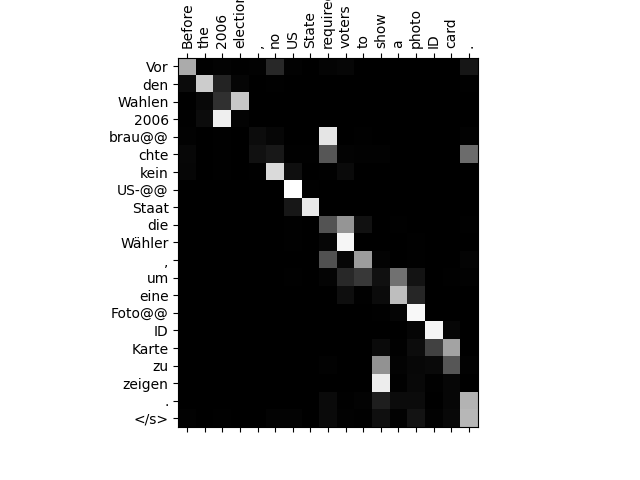

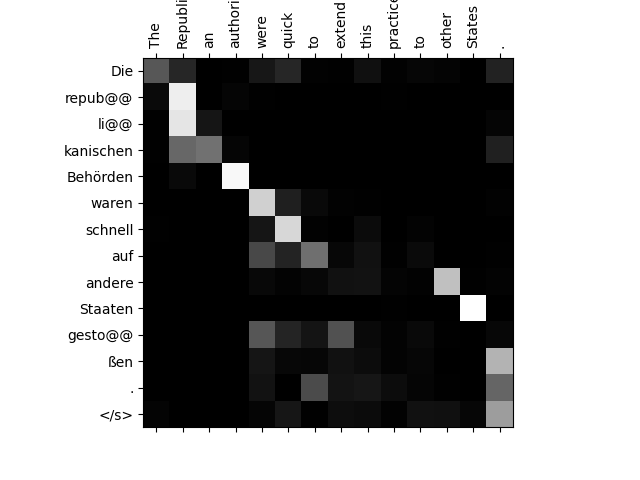

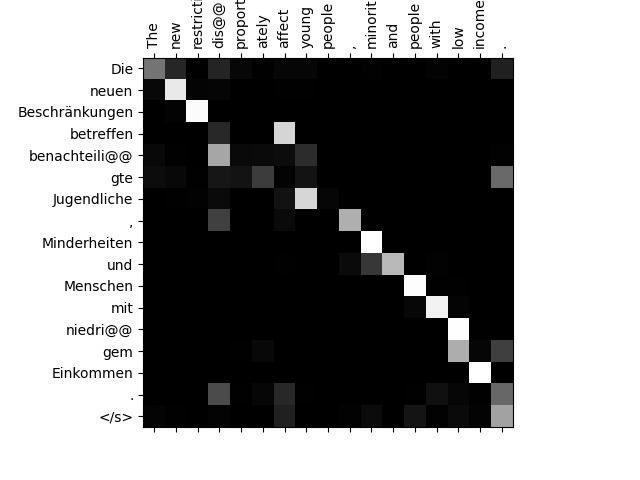

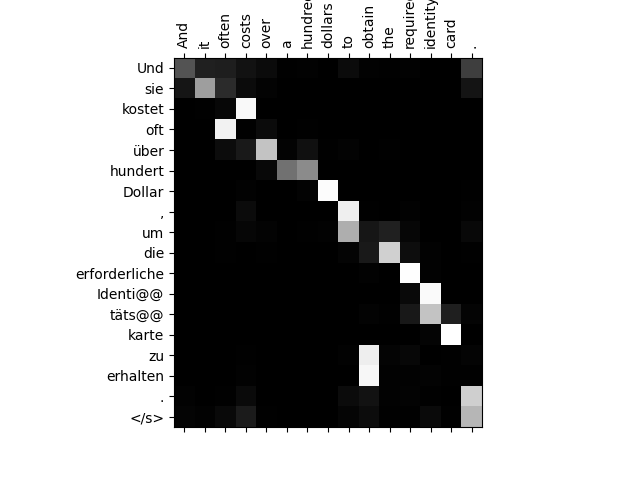

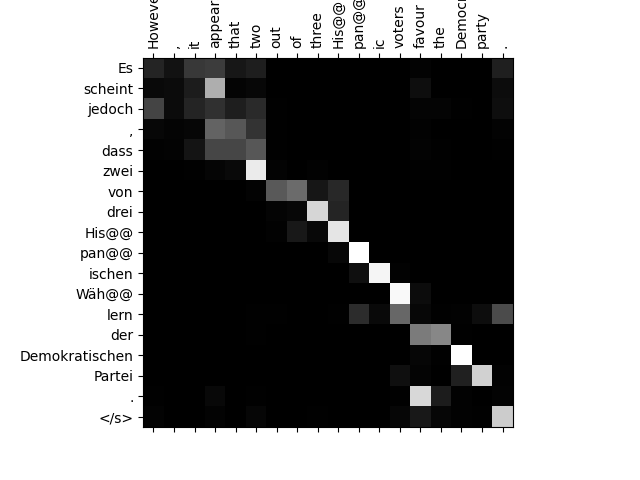

In [1]:
for id in 13 16 22 21 31
do
    plot-attention.py $id < /tmp/out.attn 2> /dev/null | display
done